In [145]:
#Importing necessary libraries 
import warnings
warnings.filterwarnings("ignore")
import itertools 
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf , pacf 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 




# Data Cleaning

## 1.   Load Data, Explore Structure and Summmary of Data 

In [146]:
#Importing our dataset 
df = pd.read_csv('Historical Product Demand.csv')
no_of_rows = len(df)
no_of_columns = len(df.columns)
print(f'The data has {no_of_rows} rows and {no_of_columns} columns ')
df.head()

The data has 1048575 rows and 5 columns 


Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500 
3  Product_0979    Whse_J     Category_028   2012/2/9         500 
4  Product_0979    Whse_J     Category_028   2012/3/2         500

In [147]:
missing_values = df.isnull().sum()
missing_values

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

## 2. Missing values detection

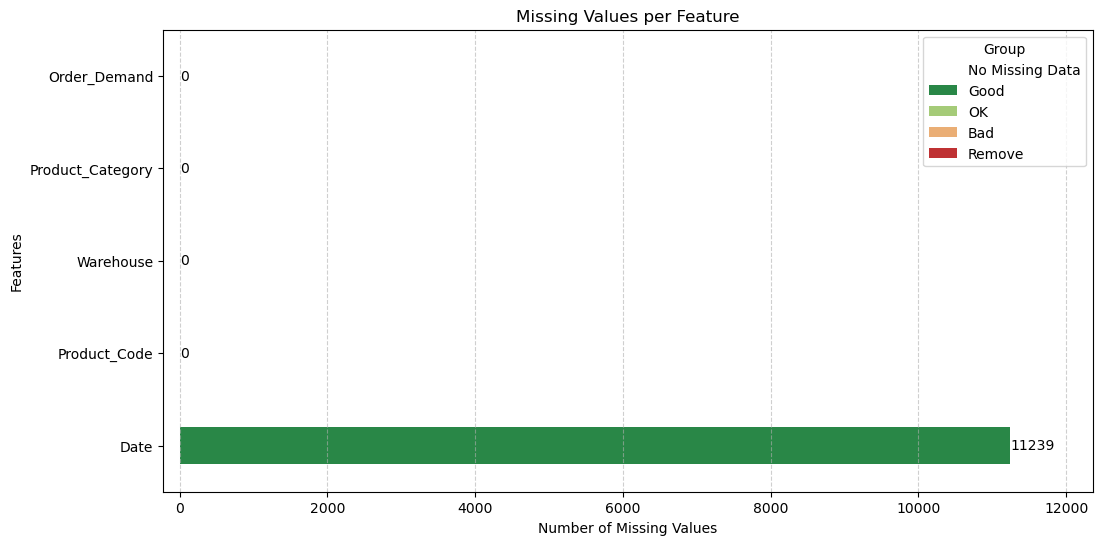

feature  num_missing            group
0              Date        11239             Good
1      Product_Code            0  No Missing Data
2         Warehouse            0  No Missing Data
3  Product_Category            0  No Missing Data
4      Order_Demand            0  No Missing Data

In [148]:
def plot_missing(data, title="Missing Values per Feature"):

    """
    Takes the number of missing values in the data frame and 
    displays a bar chart that shows the number of missing values
    per column and assigns labels- Bad,Good,Ok,Remove, depending 
    on the percentage of missing values in that column 
    params: dataframe: Pandas series
    return: dataframe with each feature , number of missing value
            and label.
    """
    # Count missing values per column
    missing_values = data.isnull().sum()

    #Create dataframe with features and no of missing values
    missing_df = pd.DataFrame({
        'feature': missing_values.index, 
        'num_missing': missing_values.values
    }).reset_index(drop=True) 
    
    # Function that assign label based on percentage of missing values
    def categorize_missing(num):
        if num == 0:
            return "No Missing Data"
        elif num < 0.05 * len(data):
            return "Good"
        elif num < 0.4 * len(data):
            return "OK"
        elif num < 0.8 * len(data):
            return "Bad"
        else:
            return "Remove"

    # Broad cast the function to the missing values dataframe 
    missing_df['group'] = missing_df['num_missing'].apply(categorize_missing)

    # Sort by number of missing values (descending) to maintain correct order
    missing_df = missing_df.sort_values(by="num_missing", ascending=False).reset_index(drop=True)

    # Define palette
    palette = {
        "No Missing Data": "#FFFFFF",  # No color
        "Good": "#1a9641",  # Green
        "OK": "#a6d96a",  # Light green
        "Bad": "#fdae61",  # Orange
        "Remove": "#d7191c"  # Red
    }

    hue_order = ["No Missing Data", "Good", "OK", "Bad", "Remove"]

    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=missing_df, y="feature", x="num_missing", hue="group",
        palette=palette, hue_order=hue_order, dodge=False, width=0.4
    )
    for index, row in missing_df.iterrows():
        plt.text(row.num_missing + 0.5, index, f"{int(row.num_missing)}", va='center')

    plt.xlabel("Number of Missing Values")
    plt.ylabel("Features")
    plt.title(title)

    plt.legend(title="Group", loc="upper right", bbox_to_anchor=(1, 1), frameon=True)

    plt.gca().invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.6)

    ax.set_xlim(left=-0.02 * max(missing_df["num_missing"]), right=max(missing_df["num_missing"]) * 1.1)

    plt.show()
    
    return missing_df  # Return DataFrame for further inspection


plot_missing(df)



#### The dataset is mostly complete, but since the 'Date' column—an important column—has some missing values, we will drop them before proceeding 

In [149]:
data = df.copy()
data = data.dropna(subset=['Date'])
len(data)

1037336

In [150]:
data.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

# EDA

## 3. Individual Features visualization 

### 3a.  Histogram of demand

##### - The Demand column needs some preprocessing - the column needs to be converted to a numerical column for computations
##### - The demands need to be aggregated daily To visualize the demand distribution on a day to day basis.
##### - Demand also needs to be visualized across all stores and products and so a new data frame is created factoring out the different stores and product.

In [151]:
# Convert Order Demand column to numeric
data['Order_Demand'] = data['Order_Demand'].astype(str).str.replace(r'[^\d]', '', regex=True)
data['Order_Demand'] = pd.to_numeric(data['Order_Demand'], errors='coerce')

#Convert date to datetime
data['Date'] = pd.to_datetime(data['Date']) 

#Sort date by ascending and aggregate demand by day 
data = data.sort_values(by=['Date'], ascending=True)
demand_data = data.groupby('Date')['Order_Demand'].sum().reset_index()

In [152]:
demand_data.head()

Date  Order_Demand
0 2011-01-08             2
1 2011-05-31           108
2 2011-06-24         92000
3 2011-09-02          1250
4 2011-09-27            28

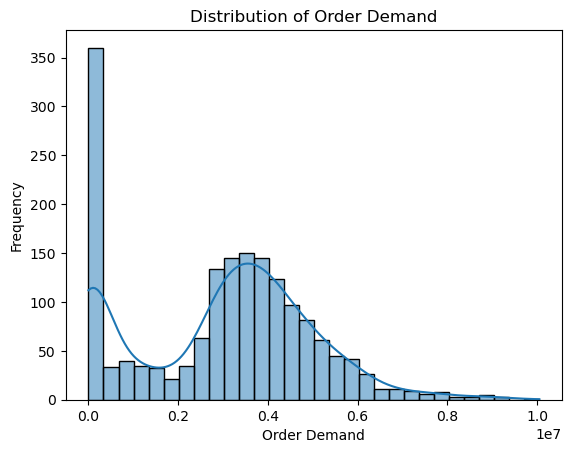

In [153]:

sns.histplot(demand_data['Order_Demand'], bins=30, kde=True)
plt.xlabel('Order Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Order Demand')
plt.show()


In [154]:
demand_data

Date  Order_Demand
0    2011-01-08             2
1    2011-05-31           108
2    2011-06-24         92000
3    2011-09-02          1250
4    2011-09-27            28
...         ...           ...
1724 2017-01-03          2400
1725 2017-01-04         29250
1726 2017-01-05         83929
1727 2017-01-06        175140
1728 2017-01-09          4178

[1729 rows x 2 columns]

##### We can see that our data has a normal distribution except for a huge left skew in the data,
##### Next I will check if these are outliers or not. if they are not then I want to know if they are
##### concentrated within a certain time period say - during the business's early years or they are randomly 
##### distributed, which means that this is recurring and would require further analysis as to why

#### Visualizing Left skewed values 

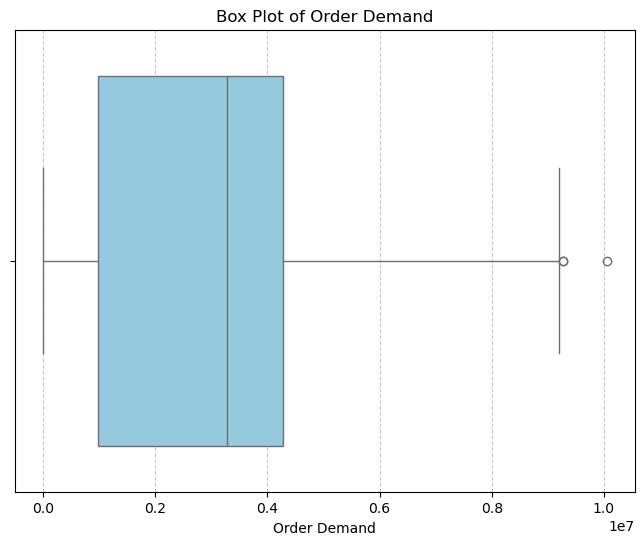

In [155]:

#Defining a function to compute upper fence
def computeLowerFence(data, lower = True):
    """
    Computes the upper/lower fence for a given column.
    Params:
        df_col: Pandas series, dataframe column
        up: boolean, True for lower fence, False for upper fence
    Return:
        upper/lower fence value : float
    """
    iqr = data.quantile(.75) - data.quantile(.25)
    if lower:
         return data.quantile(.25) - iqr * 1.5
    return data.quantile(.25) - iqr * 1.5 

# outliers in the demand column
demand = demand_data['Order_Demand']
lower_fence = computeLowerFence(demand)
filtered_outliers = demand_data[lower_fence> demand]
filtered_outliers    

#Visualizing Outliers with box plot 
# Create the figure
plt.figure(figsize=(8, 6))

# Box plot for Order Demand
sns.boxplot(x=demand_data['Order_Demand'], color="skyblue")

# Customize the plot
plt.title("Box Plot of Order Demand")
plt.xlabel("Order Demand")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()



##### We can see that the left skewed data has a little above 350  values, i will extract those values and 
##### Visualize them over time to see if they are concentrated or evenly distributed over the years,
##### the latter would mean that there is a pattern - a period where demand falls drastically, we want to know 
##### why this is the case. 

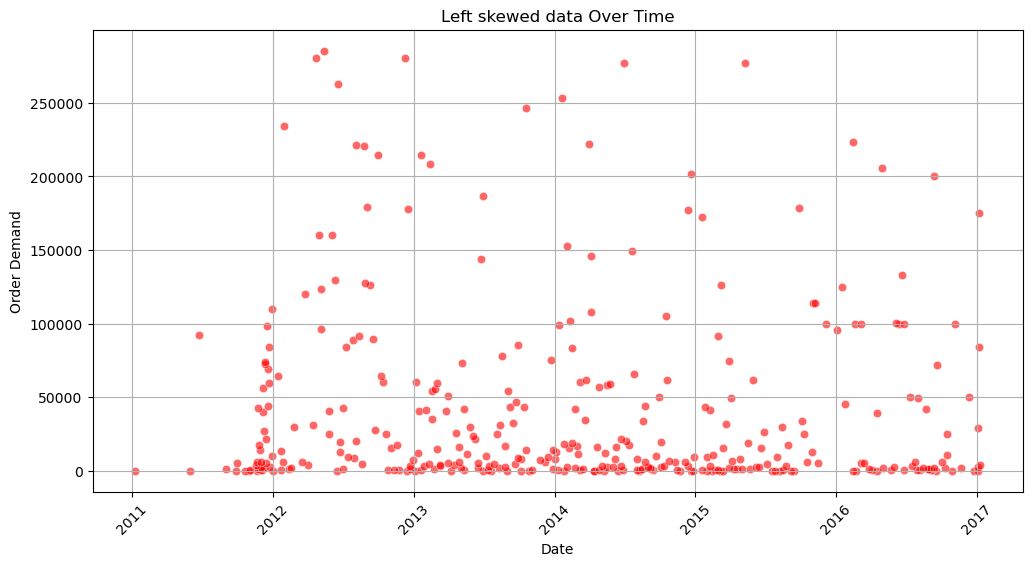

In [156]:
Left_skewed_data = demand_data.sort_values(by=['Order_Demand'],ascending = True).reset_index()
Left_skewed_data = Left_skewed_data.head(350)

plt.figure(figsize=(12, 6))

# Scatter plot of outliers over time
sns.scatterplot(x=Left_skewed_data['Date'], y=Left_skewed_data['Order_Demand'], color='red', alpha=0.6)

# Customise the plot
plt.title("Left skewed data Over Time")
plt.xlabel("Date")
plt.ylabel("Order Demand")
plt.xticks(rotation=45) 
plt.grid(True)

plt.show()


##### The plot above confirms that the values are evenly distributed confirming that there
##### is a pattern to be uncovered 

### 3b. Growth per date 

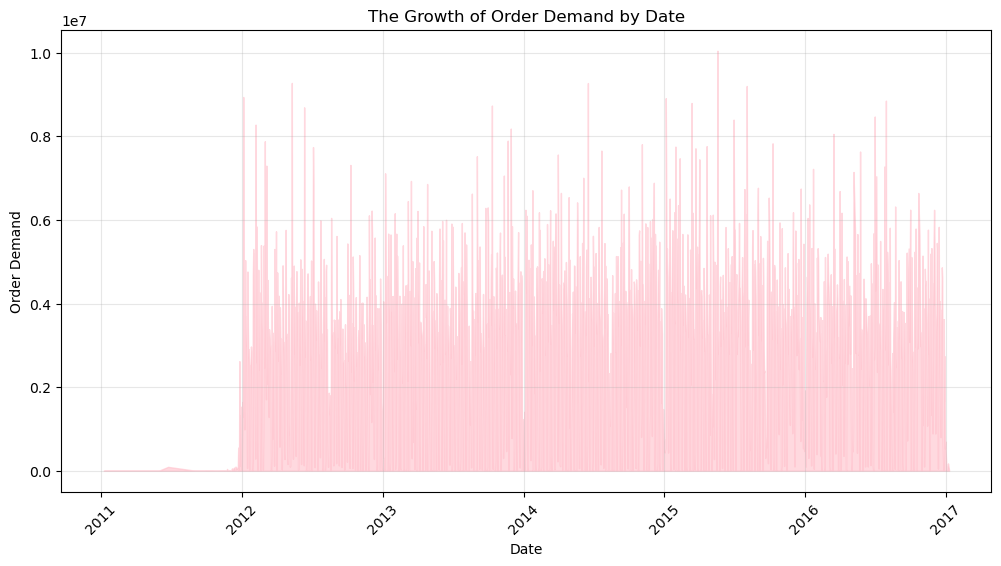

In [157]:
# Aggregate Order_Demand by date (calculate mean demand per date)
MSP = demand_data.groupby('Date', as_index=False)['Order_Demand'].mean()

# Calculate Growth Rate
MSP['rate'] = MSP['Order_Demand'].pct_change() * 100  # Percentage change

# Set up the figure
plt.figure(figsize=(12, 6))

# Create an area plot
plt.fill_between(MSP['Date'], MSP['Order_Demand'], color="pink", alpha=0.6)

# Customize plot
plt.title("The Growth of Order Demand by Date")
plt.xlabel("Date")
plt.ylabel("Order Demand")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# Show the plot

plt.show()


##### - The above plot analyzing the Growth sales over time shows that the growth has high variation as we can see from the sudden spikes in the demand.
##### - We can also see that there is no increase over time.

### 3c. Growth Rate by Year 

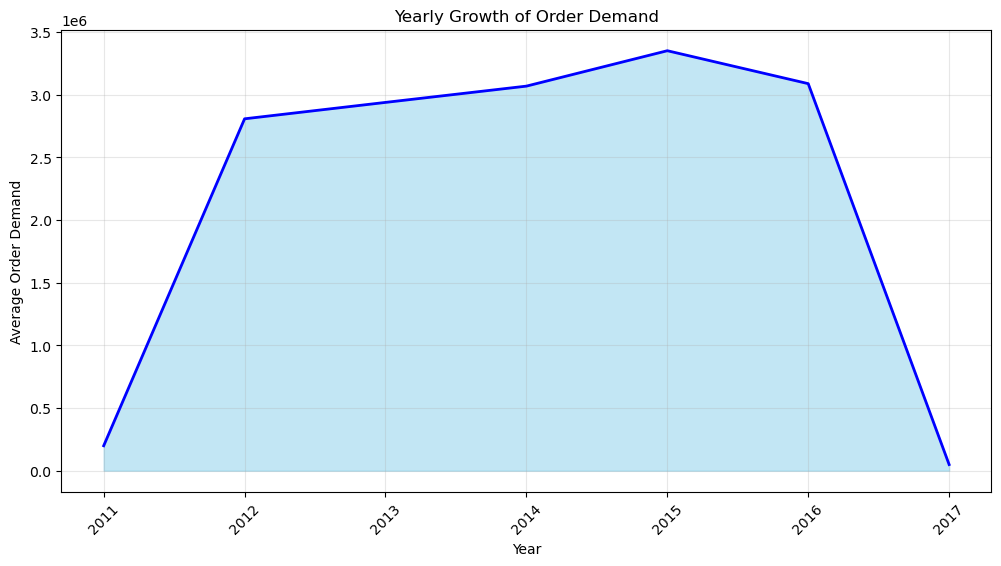

In [158]:
# Extract year and aggregate Order_Demand by year
demand_data['Year'] = demand_data['Date'].dt.year
MSP_yearly = demand_data.groupby('Year', as_index=False)['Order_Demand'].mean()

# Set up figure
plt.figure(figsize=(12, 6))

# Area plot
plt.fill_between(MSP_yearly['Year'], MSP_yearly['Order_Demand'], color="skyblue", alpha=0.5)

# Line plot overlay
sns.lineplot(data=MSP_yearly, x='Year', y='Order_Demand', color="blue", linewidth=2)

# Customize plot
plt.title("Yearly Growth of Order Demand")
plt.xlabel("Year")
plt.ylabel("Average Order Demand")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# Show plot
plt.show()

##### The plot illustrates the yearly growth of demand, showing a generally weak trend,
##### except for a sharp rise in 2011 and a decline in 2017. A quick look at the data reveals 
##### that these two years have limited records, which we will explore further in the next slide.









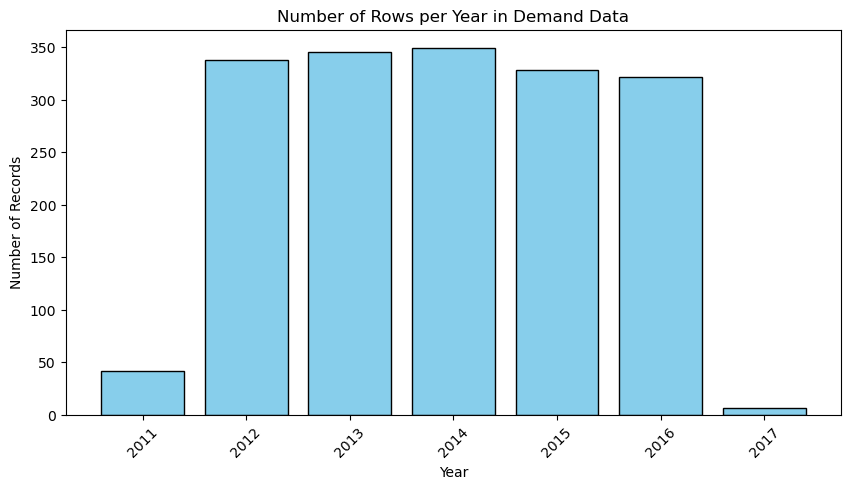

In [159]:
# Count the number of rows per year
yearly_counts = demand_data['Year'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(yearly_counts.index, yearly_counts.values, color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Records")
plt.title("Number of Rows per Year in Demand Data")
plt.xticks(rotation=45)

# Show plot
plt.show()


##### The bar chart reveals that the years 2011 and 2017 have significantly fewer data points compared to other years.
##### This data imbalance could negatively impact our ARIMA and Prophet models, leading to misleading dips and spikes in predictions.
##### To ensure more reliable forecasting, I will exclude these years, as we have over 300 records for each of the other years,
##### providing a sufficient dataset for the model to learn from.

In [160]:
def drop_year_rows(df, years_list):
    """
    Drops rows corresponding to the years provided in years_list.

    Parameters:
        df (pd.DataFrame): The DataFrame containing a 'Date' column.
        years_list (list): A list of years to be removed from the DataFrame.

    Returns:
        pd.DataFrame: A new DataFrame with the specified years removed.
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    df['Year'] = df['Date'].dt.year  # Extract year from Date column
    df_filtered = df[~df['Year'].isin(years_list)].reset_index(drop=True)  # Remove specified years & reset index
    return df_filtered  # Keep 'Year' column in the returned DataFrame


demand_data = drop_year_rows(demand_data, [2011,2017])

demand_data

Date  Order_Demand  Year
0    2012-01-01             2  2012
1    2012-01-02        680277  2012
2    2012-01-03       1645257  2012
3    2012-01-04       1295861  2012
4    2012-01-05       8941774  2012
...         ...           ...   ...
1676 2016-12-26       3628370  2016
1677 2016-12-27       1674226  2016
1678 2016-12-28       2740302  2016
1679 2016-12-29        530487  2016
1680 2016-12-30        702950  2016

[1681 rows x 3 columns]


### 3c. Visualizing the updated Growth per year 

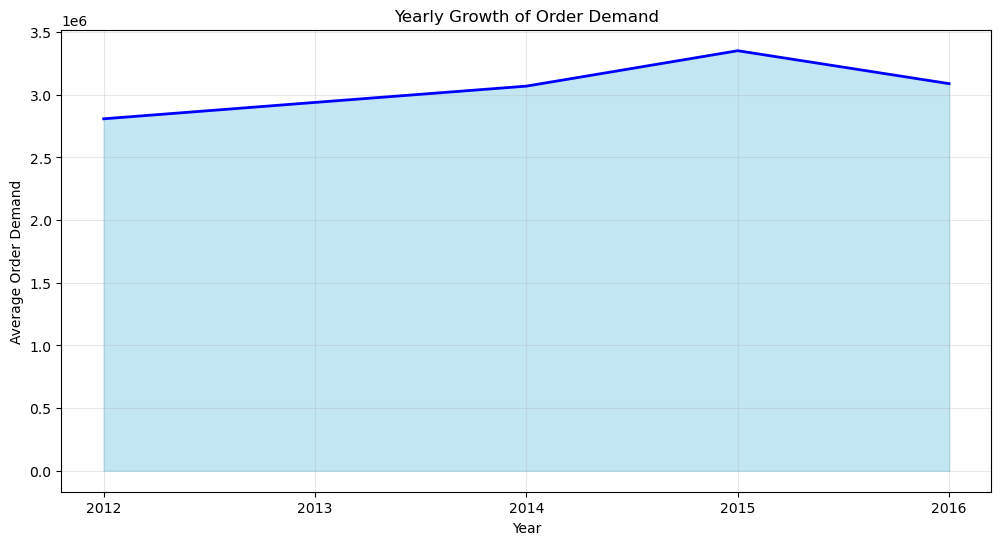

YearMonth Warehouse  Order_Demand  Year  Month
0 2012-01-01    Whse_A       1920567  2012      1
1 2012-01-01    Whse_C       4255664  2012      1
2 2012-01-01    Whse_J      51534181  2012      1
3 2012-01-01    Whse_S      16620625  2012      1
4 2012-02-01    Whse_A       2552035  2012      2

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by year and calculate mean order demand
MSP_yearly = demand_data.groupby('Year', as_index=False)['Order_Demand'].mean()

# Convert 'Year' to integer for proper plotting
MSP_yearly['Year'] = MSP_yearly['Year'].astype(int)

# Set up figure
plt.figure(figsize=(12, 6))

# Area plot with discrete x-axis values
plt.fill_between(MSP_yearly['Year'], MSP_yearly['Order_Demand'], color="skyblue", alpha=0.5)

# Line plot overlay
sns.lineplot(data=MSP_yearly, x='Year', y='Order_Demand', color="blue", linewidth=2)

# Customize plot
plt.title("Yearly Growth of Order Demand")
plt.xlabel("Year")
plt.ylabel("Average Order Demand")
plt.xticks(MSP_yearly['Year']) 
plt.grid(alpha=0.3)

# Show plot
plt.show()
warehouse_monthly.head()


### 3d. Growth by strore 

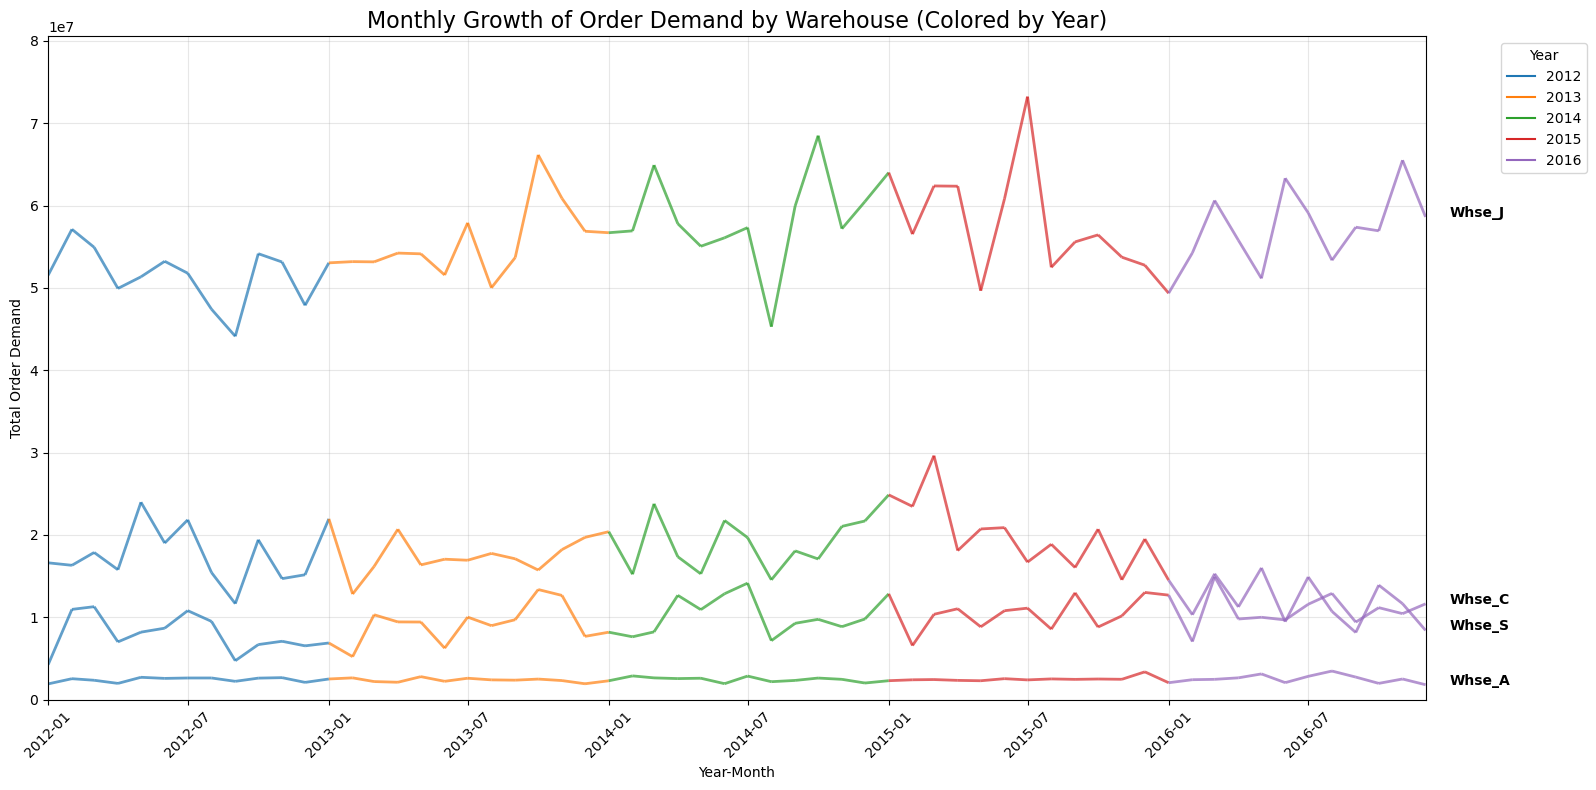

In [162]:
# Create a DataFrame that includes the store column to analyze demand by stores 
# from 2012 to 2016 (where the data is complete) and identify patterns.

store_data = data.groupby(['Date','Warehouse'])['Order_Demand'].sum().reset_index()

# Calling the function 'drop_year_rows' to remove the years 2011 and 2017
store_data =  drop_year_rows(store_data ,[2011,2017])

# Aggregate demand data by month and warehouse
store_data['YearMonth'] = store_data['Date'].dt.to_period('M')  # Convert to Year-Month period
warehouse_monthly = store_data.groupby(['YearMonth', 'Warehouse'], as_index=False)['Order_Demand'].sum()

# Convert YearMonth back to datetime for plotting
warehouse_monthly['YearMonth'] = warehouse_monthly['YearMonth'].dt.to_timestamp()


# Preparing data
warehouse_monthly['Year'] = warehouse_monthly['YearMonth'].dt.year
warehouse_monthly['Month'] = warehouse_monthly['YearMonth'].dt.month

# Create color map for each year
years = sorted(warehouse_monthly['Year'].unique())
year_palette = sns.color_palette('tab10', len(years))
year_color_map = dict(zip(years, year_palette))

# Create the figure
fig, ax = plt.subplots(figsize=(16, 8))

from matplotlib.collections import LineCollection

# Plot each warehouse
for warehouse in warehouse_monthly['Warehouse'].unique():
    warehouse_data = warehouse_monthly[warehouse_monthly['Warehouse'] == warehouse].sort_values('YearMonth')

    # Convert dates to numbers
    import matplotlib.dates as mdates
    dates_num = mdates.date2num(warehouse_data['YearMonth'])
    order_demand = warehouse_data['Order_Demand'].values

    # Prepare segments for LineCollection
    points = np.array([dates_num, order_demand]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Define colors for each segment
    segment_years = warehouse_data['Year'].values[:-1]  # year at the start of each segment
    colors = [year_color_map[year] for year in segment_years]

    # Create LineCollection
    lc = LineCollection(segments, colors=colors, linewidths=2, alpha=0.7)
    ax.add_collection(lc)

    # Add warehouse name at last point
    last_row = warehouse_data.iloc[-1]
    ax.text(last_row['YearMonth'] + pd.DateOffset(months=1),
            last_row['Order_Demand'],
            warehouse,
            fontsize=10,
            fontweight='bold',
            color='black')

# Set limits
ax.set_xlim(warehouse_monthly['YearMonth'].min(), warehouse_monthly['YearMonth'].max())
ax.set_ylim(0, warehouse_monthly['Order_Demand'].max() * 1.1)

# X-axis formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Create custom legend for years
handles = [plt.Line2D([], [], color=year_color_map[year], label=str(year)) for year in years]
ax.legend(handles=handles, title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Titles
plt.title("Monthly Growth of Order Demand by Warehouse (Colored by Year)", fontsize=16)
plt.xlabel("Year-Month")
plt.ylabel("Total Order Demand")
plt.grid(alpha=0.3)

plt.tight_layout()

# Show plot
plt.show()



##### The plot shows that while demand across warehouses exhibits fluctuations, the overall mean remains fairly constant over time, with only a slight upward trend.
##### This suggests that demand does not increase or decrease significantly but instead grows gradually over time. One notable exception is Warehouse_S, which experiences
##### a drop in demand towards the end of the period. Further analysis of this warehouse's operations may help determine whether this decline is due to warehouse-specific
##### factors or broader external influences. Additionally, the fluctuations in demand do not appear entirely consistent over time. There are stronger spikes from 
##### mid-2014 to mid-2015, which occur across all warehouses. Since this pattern is shared among warehouses, it is likely caused by external factors rather than internal
##### warehouse operations. A deeper industry analysis could help uncover the causes of this unpredictability. Incorporating these insights into our forecasting model could
##### improve its accuracy by accounting for these external influences.

### 3e. Growth by Products 

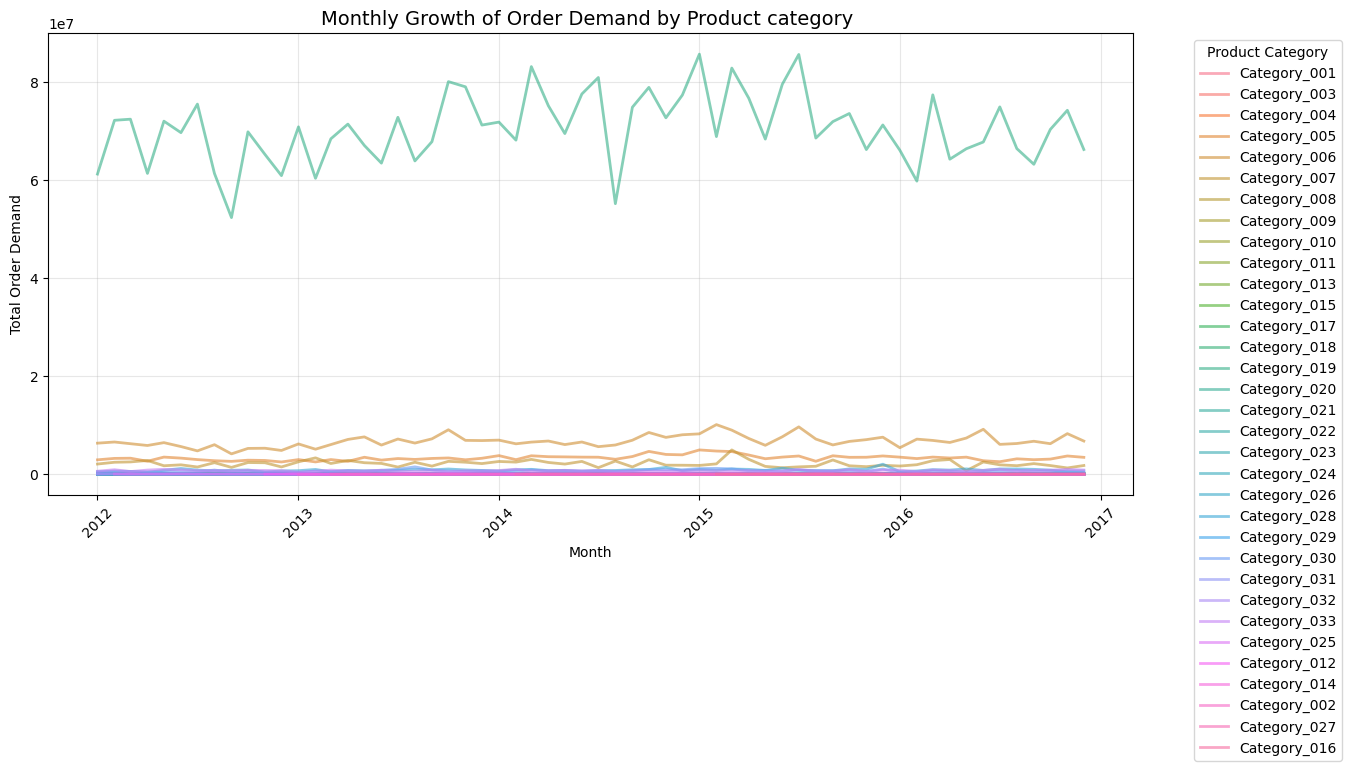

Date Product_Category  Order_Demand  Year YearMonth
0     2012-01-01     Category_024             2  2012   2012-01
1     2012-01-02     Category_001           107  2012   2012-01
2     2012-01-02     Category_005          3500  2012   2012-01
3     2012-01-02     Category_006         13000  2012   2012-01
4     2012-01-02     Category_011            25  2012   2012-01
...          ...              ...           ...   ...       ...
31652 2016-12-30     Category_005         32000  2016   2016-12
31653 2016-12-30     Category_007            70  2016   2016-12
31654 2016-12-30     Category_019        621700  2016   2016-12
31655 2016-12-30     Category_021           100  2016   2016-12
31656 2016-12-30     Category_030         49000  2016   2016-12

[31657 rows x 5 columns]

In [163]:
# Create a DataFrame that includes the Product category column to analyze demand by products 
# from 2012 to 2016 (where the data is complete) and identify patterns.

product_category_data = data.groupby(['Date','Product_Category'])['Order_Demand'].sum().reset_index()

# Calling the function 'drop_year_rows' to remove the years 2011 and 2017
product_category_data =  drop_year_rows(product_category_data ,[2011,2017])

# Aggregate demand data by month and warehouse
product_category_data['YearMonth'] = product_category_data['Date'].dt.to_period('M')  # Convert to Year-Month period
product_category_monthly = product_category_data.groupby(['YearMonth', 'Product_Category'], as_index=False)['Order_Demand'].sum()

# Convert YearMonth back to datetime for plotting
product_category_monthly['YearMonth'] = product_category_monthly['YearMonth'].dt.to_timestamp()

# Set up figure
plt.figure(figsize=(14, 6))

# Line plot for each product catefory (monthly trend)
sns.lineplot(data=product_category_monthly, x='YearMonth', y='Order_Demand', hue='Product_Category', alpha=0.6, linewidth=2)

# Customize plot
plt.title("Monthly Growth of Order Demand by Product category ", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Total Order Demand")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()
product_category_data

##### we can see that the demand of the products over time looks very similar to the warehouse demand 
##### over time in terms of its mean and variance.
##### Category_019's total demands is way above the rest.
##### in the next slide i will be visualizing the magnitude of the 
##### total demand for the top 5 and Bottom 5 product categories 

### 3e. Visualizing the Top 5 and Bottom 5 product categories 

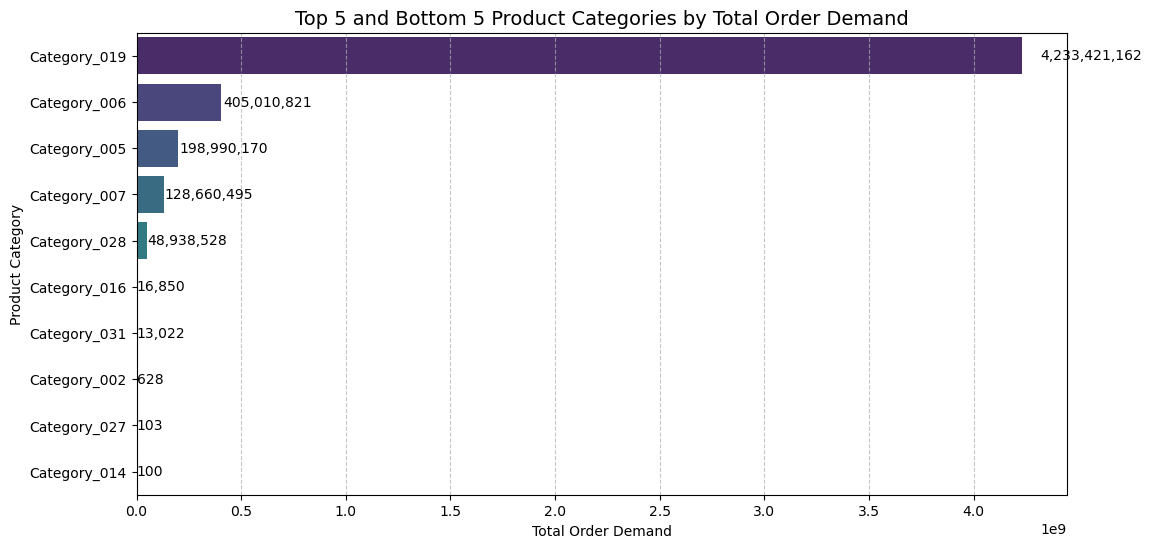

In [164]:
# Aggregate total demand by product category
category_demand = product_category_data.groupby("Product_Category")["Order_Demand"].sum().reset_index()

# Get the top 5 and bottom 5 categories by demand
top_5 = category_demand.nlargest(5, "Order_Demand")
bottom_5 = category_demand.nsmallest(5, "Order_Demand")

# Combine both into one DataFrame for visualization
top_bottom = pd.concat([top_5, bottom_5])

# Sort for better visualization
top_bottom = top_bottom.sort_values(by="Order_Demand", ascending=False)

# Set up the figure
plt.figure(figsize=(12, 6))

# Create the barplot
ax = sns.barplot(data=top_bottom, x="Order_Demand", y="Product_Category", palette="viridis")

# Add value labels to each bar
for index, value in enumerate(top_bottom["Order_Demand"]):
    ax.text(value + (0.02 * value), index, f"{value:,}", va='center', fontsize=10)  # Format with commas

# Customize the plot
plt.title("Top 5 and Bottom 5 Product Categories by Total Order Demand", fontsize=14)
plt.xlabel("Total Order Demand")
plt.ylabel("Product Category")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show plot
plt.show()



##### We can see the Total demand for the Top 5 and Bottom 5 products over the years it is clear that the last 5 products 
##### contibute so little to the total demand. 

### 4. Preparing dataset

In [165]:
# Prepare the entire monthly demand 
entire_monthly_demand = demand_data[['Order_Demand','Date']].set_index('Date')

# Resample monthly demand to smooth the trend.
entire_monthly_demand = entire_monthly_demand.Order_Demand.resample('M').sum()

# Prepare demand by warehouse 

# Dictionary to store separate DataFrames for each warehouse
demand_by_store = {}

# Loop through each unique warehouse
for warehouse in store_data['Warehouse'].unique():
    # Filter data for the warehouse
    warehouse_df = store_data[store_data['Warehouse'] == warehouse].copy()
    
    # Set Date as index
    warehouse_df.set_index('Date', inplace=True)
    
    # Resample monthly and sum the Order_Demand
    monthly_df = warehouse_df['Order_Demand'].resample('M').sum().to_frame()
    
    # Rename column for clarity
    monthly_df.columns = ['Monthly_Demand']
    
    # Store in dictionary
    demand_by_store[warehouse] = monthly_df


### 5.  Assessing stationarity

#### 5a. Rolling Statistics 

In [166]:
#Using the rolling statistics to analyse the stationarity of the dataset. 
roll_mean = entire_monthly_demand.rolling(window= 12).mean()
roll_std = entire_monthly_demand.rolling(window= 12).std()


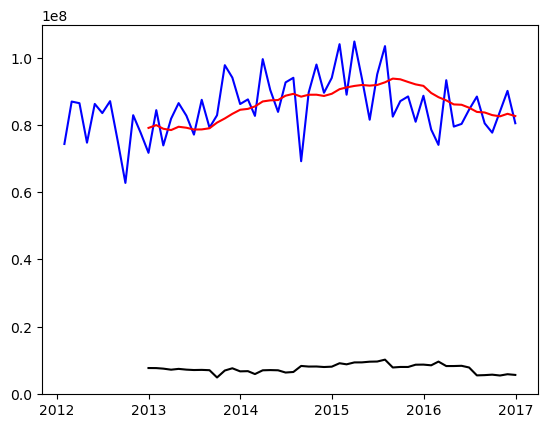

In [167]:
plt.plot(entire_monthly_demand, color = 'Blue', label ='Oringinal')
plt.plot(roll_mean, color = 'Red', label = 'Rolling Mean')
plt.plot(roll_std, color = 'Black', label = 'Rolling Standard Deviation')
plt.show()

##### The above shows that the mean is close to being constant, and so is the standard deviation 
##### However, we can see a trend effect here, telling us that we may likely need differencing, 
##### we will perform the ADF test to make our  final decision. 

#### 5b. Augmented Dickey-Fuller (ADF)


In [168]:
# Dickey-Fuller Test
def interpret_dftest(pandas_Series,Component):
    dftest = sm.tsa.adfuller(pandas_Series, autolag = 'AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=[f'{Component} Test Statistic',f'{Component} p-value',f'{Component} Lag used',f'{Component} Number of observation used'])
    for key , value in dftest[4].items():
        dfoutput['Critical_vlaue(%s)' %key] = value 
    return dfoutput

In [169]:
print(interpret_dftest(entire_monthly_demand, 'Oringinal data'),'\n')

Oringinal data Test Statistic                -2.061457
Oringinal data p-value                        0.260293
Oringinal data Lag used                       2.000000
Oringinal data Number of observation used    57.000000
Critical_vlaue(1%)                           -3.550670
Critical_vlaue(5%)                           -2.913766
Critical_vlaue(10%)                          -2.594624
dtype: float64 



##### We will use a p-value of 0.05
##### Null Hypothesis - Non-Stationary
##### Alternate Hypothesis - Stationary
##### We can see that the P-value(0.260293) is significantly higher than 0.05. The test statistic also doesn't come close to the critical value, even at 90% confidence.
##### Therefore we need to perform differencing on the data.


### 6. Performing Differencing

##### To perform stationarity we peforming logarithm and then substract the mean of the logged data from the 
##### logged dataset 
##### I will do this on the entire deman and the demand by ware house. 

#### 6a. Take log and subtract mean 

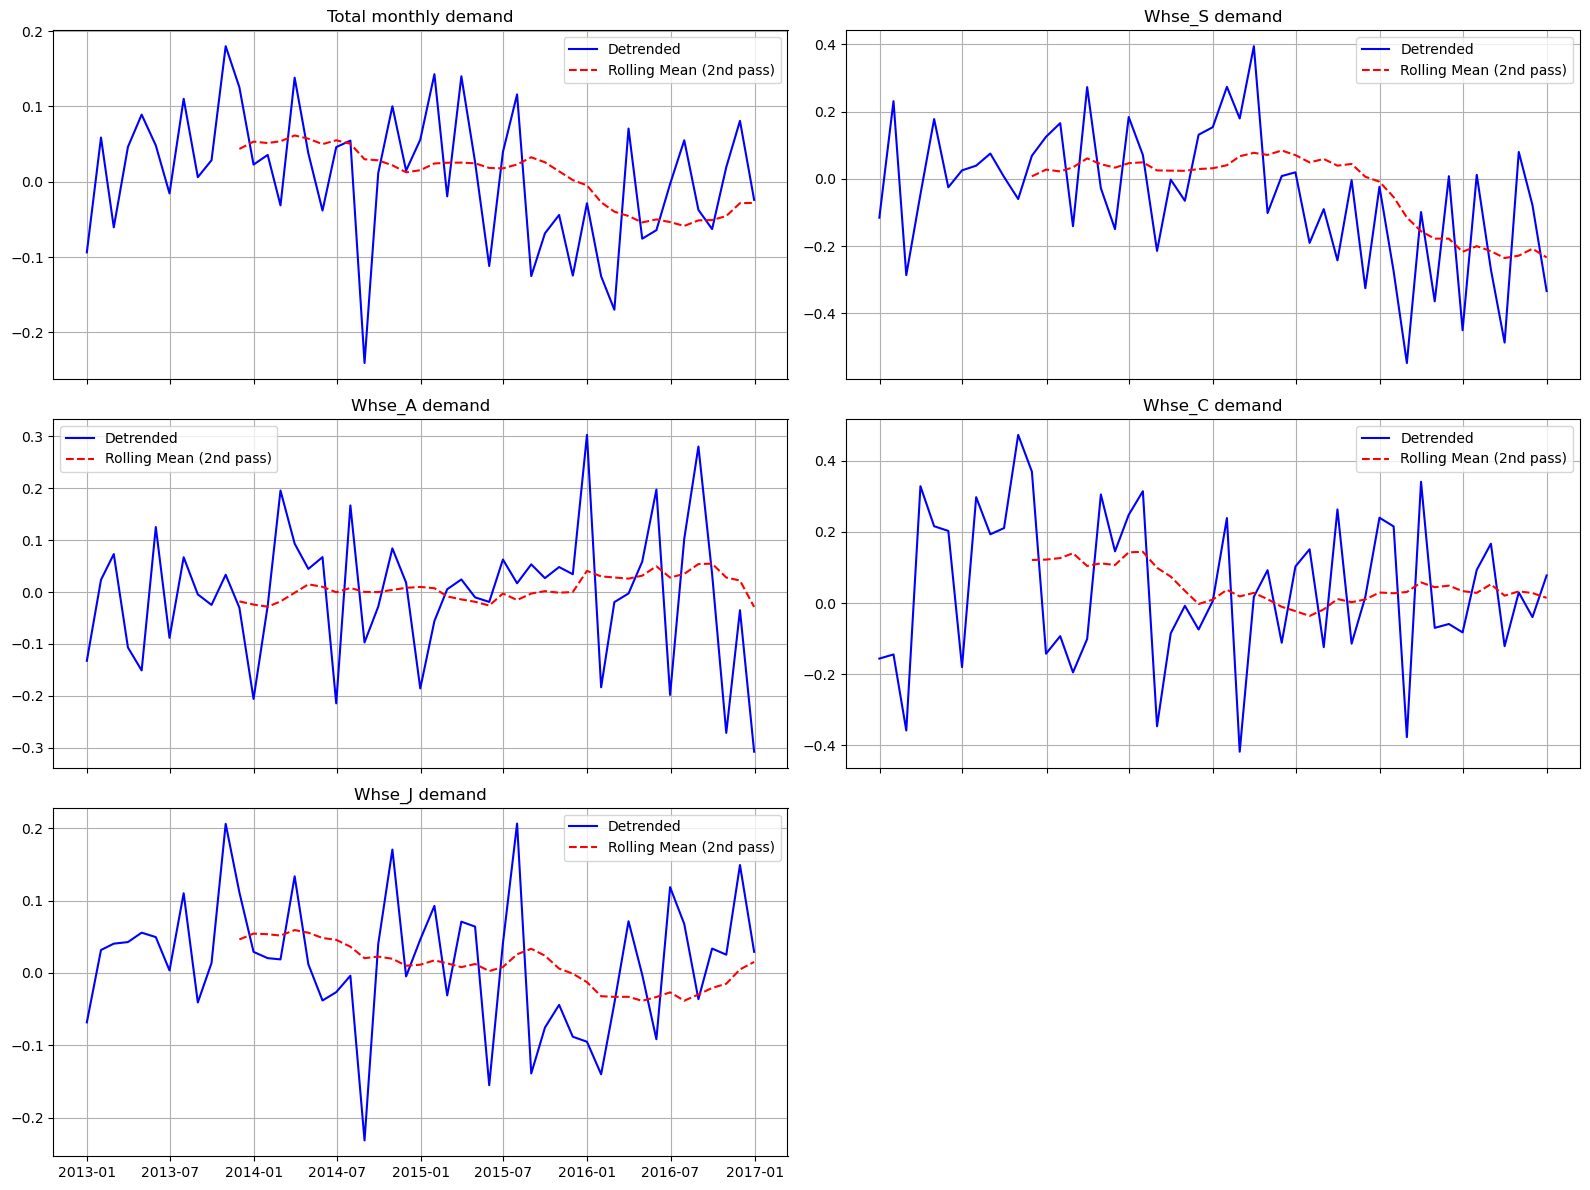

In [170]:
# To make the data stationary, we create a function that 
# takes the log of the data and subtract the mean 
# We do it for the entire demand dataset and demand 
# by warehouse datasets 

def take_log_sub_mean(datasets, dataset_names=None):
    n = len(datasets)
    rows, cols = 3, 2
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12), sharex=True)

    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(n)]

    axes = axes.flatten()
    detrended_results = []
    logged_data_results = []
    moving_average_results = []

    for i, dataset in enumerate(datasets):
        # Log transform
        log_scale_dataset = np.log(dataset)

        # Rolling mean
        moving_average = log_scale_dataset.rolling(window=12).mean()

        # Subtract rolling mean (detrending)
        logged_data_minus_moving_average = log_scale_dataset - moving_average
        logged_data_minus_moving_average.dropna(inplace=True)

        # Store detrended data
        detrended_results.append(logged_data_minus_moving_average)

        # Store logged data minus moving average for return
        logged_data_results.append(logged_data_minus_moving_average)

        # Store the moving average results 
        moving_average_results.append(moving_average)
        

        # Rolling mean of the detrended data
        rolling_mean_detrended = logged_data_minus_moving_average.rolling(window=12).mean()

        # Plot in subplot
        axes[i].plot(logged_data_minus_moving_average, label='Detrended', color='blue')
        axes[i].plot(rolling_mean_detrended, label='Rolling Mean (2nd pass)', color='red', linestyle='--')
        axes[i].set_title(dataset_names[i])
        axes[i].legend()
        axes[i].grid(True)

    # Hide extra subplots if any
    for j in range(n, rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    

    return detrended_results,logged_data_results, moving_average_results, dataset_names



# store demand data 
datasets = [demand_by_store[key]['Monthly_Demand'] for key in demand_by_store]

#adding monthly damand data 
datasets = [entire_monthly_demand] + datasets

dataset_names = ['Total monthly demand'] + [f'{key} demand' for key in demand_by_store]


#view of the progress so far
detrended_datasets, logged_data_minus_moving_average,moving_average, dataset_names = take_log_sub_mean( datasets, dataset_names=dataset_names)


##### After taking the log and subtracting the mea,n our data is looking more stationary
##### but we can still see some upward and downward movement and therefore 
##### I will be differencing the data next 

#### 6b. Difference the data 

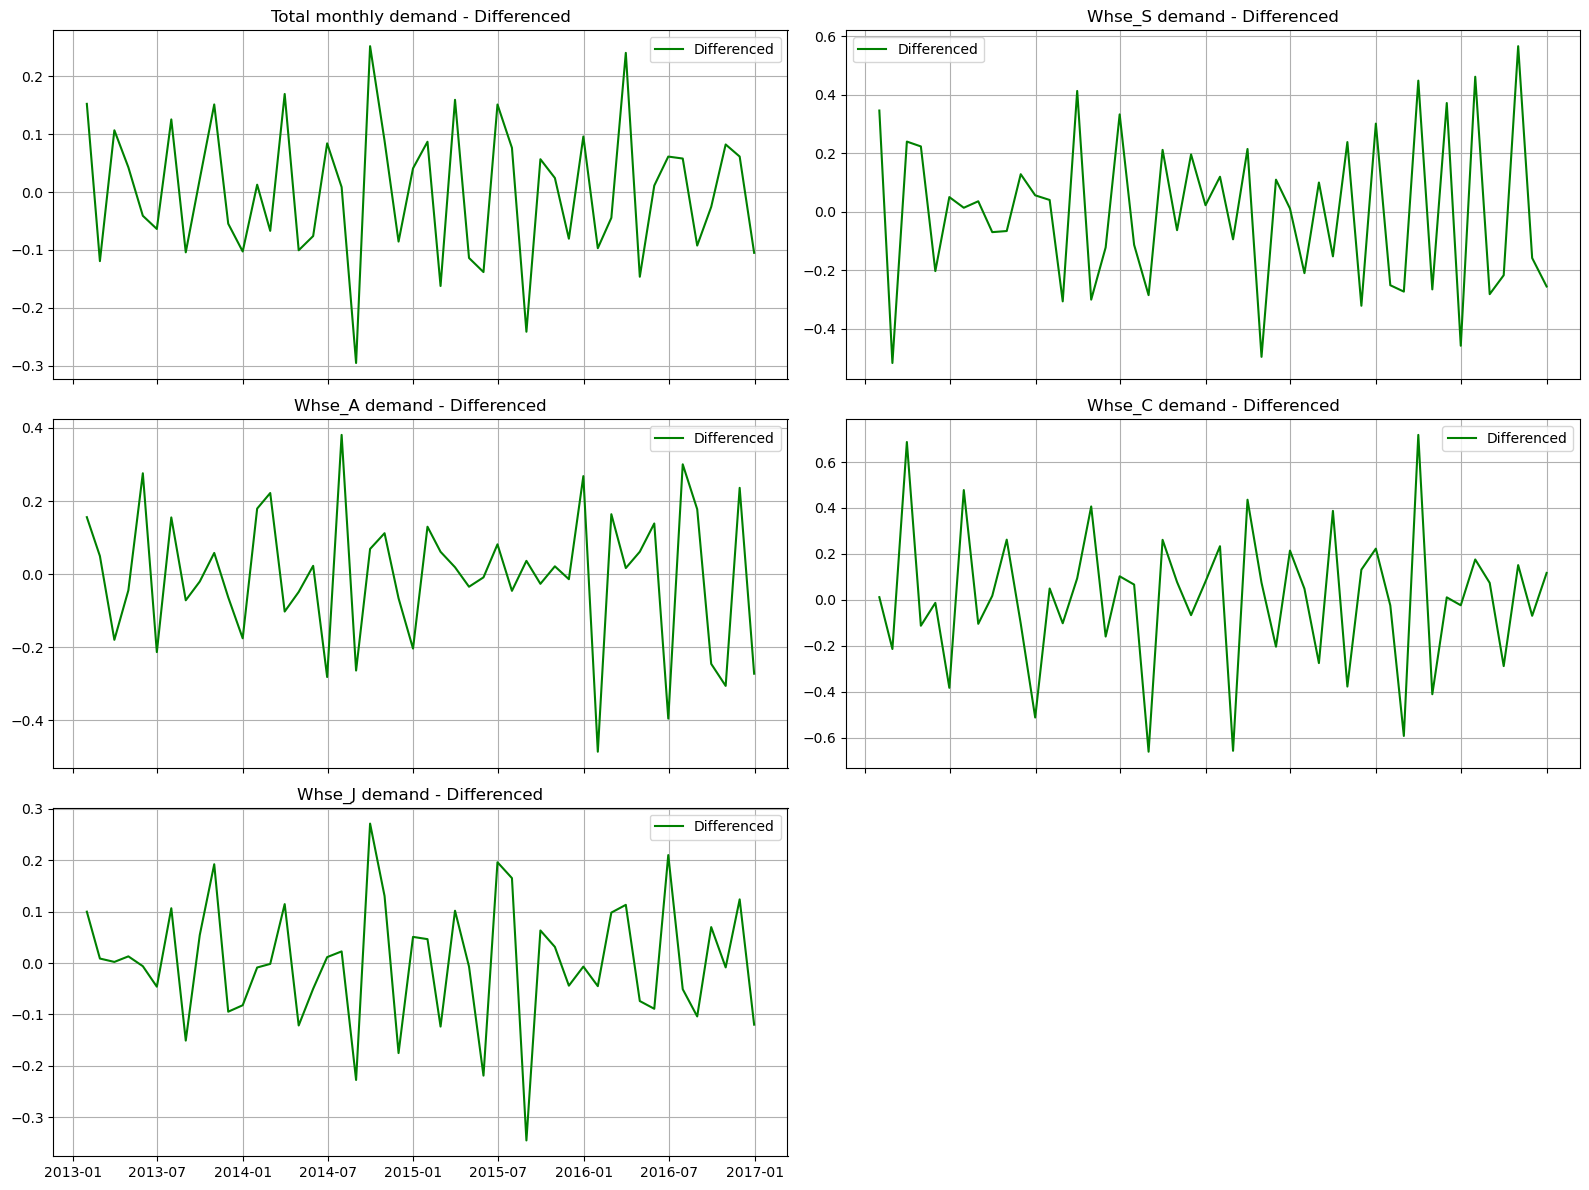

In [171]:
def difference_and_plot(datasets, dataset_names):
    n = len(datasets)
    rows, cols = 3, 2
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12), sharex=True)
    axes = axes.flatten()

    differenced_datasets = []

    for i, dataset in enumerate(datasets):
        differenced_data = dataset.diff().dropna()
        differenced_datasets.append(differenced_data)

        axes[i].plot(differenced_data, label='Differenced', color='green')
        axes[i].set_title(f'{dataset_names[i]} - Differenced')
        axes[i].legend()
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(n, rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return differenced_datasets


differenced_datasets = difference_and_plot(detrended_datasets, dataset_names)


#### 6c. Re-Test with ADF


ADF Test Results for Total monthly demand:
Total monthly demand Test Statistic                 -3.096100
Total monthly demand p-value                         0.026843
Total monthly demand Lag used                       10.000000
Total monthly demand Number of observations used    37.000000
Critical value (1%)                                 -3.620918
Critical value (5%)                                 -2.943539
Critical value (10%)                                -2.610400
dtype: float64


ADF Test Results for Whse_S demand:
Whse_S demand Test Statistic                -1.017646e+01
Whse_S demand p-value                        6.871863e-18
Whse_S demand Lag used                       1.000000e+00
Whse_S demand Number of observations used    4.600000e+01
Critical value (1%)                         -3.581258e+00
Critical value (5%)                         -2.926785e+00
Critical value (10%)                        -2.601541e+00
dtype: float64


ADF Test Results for Whse_A demand:
Whse_A dem

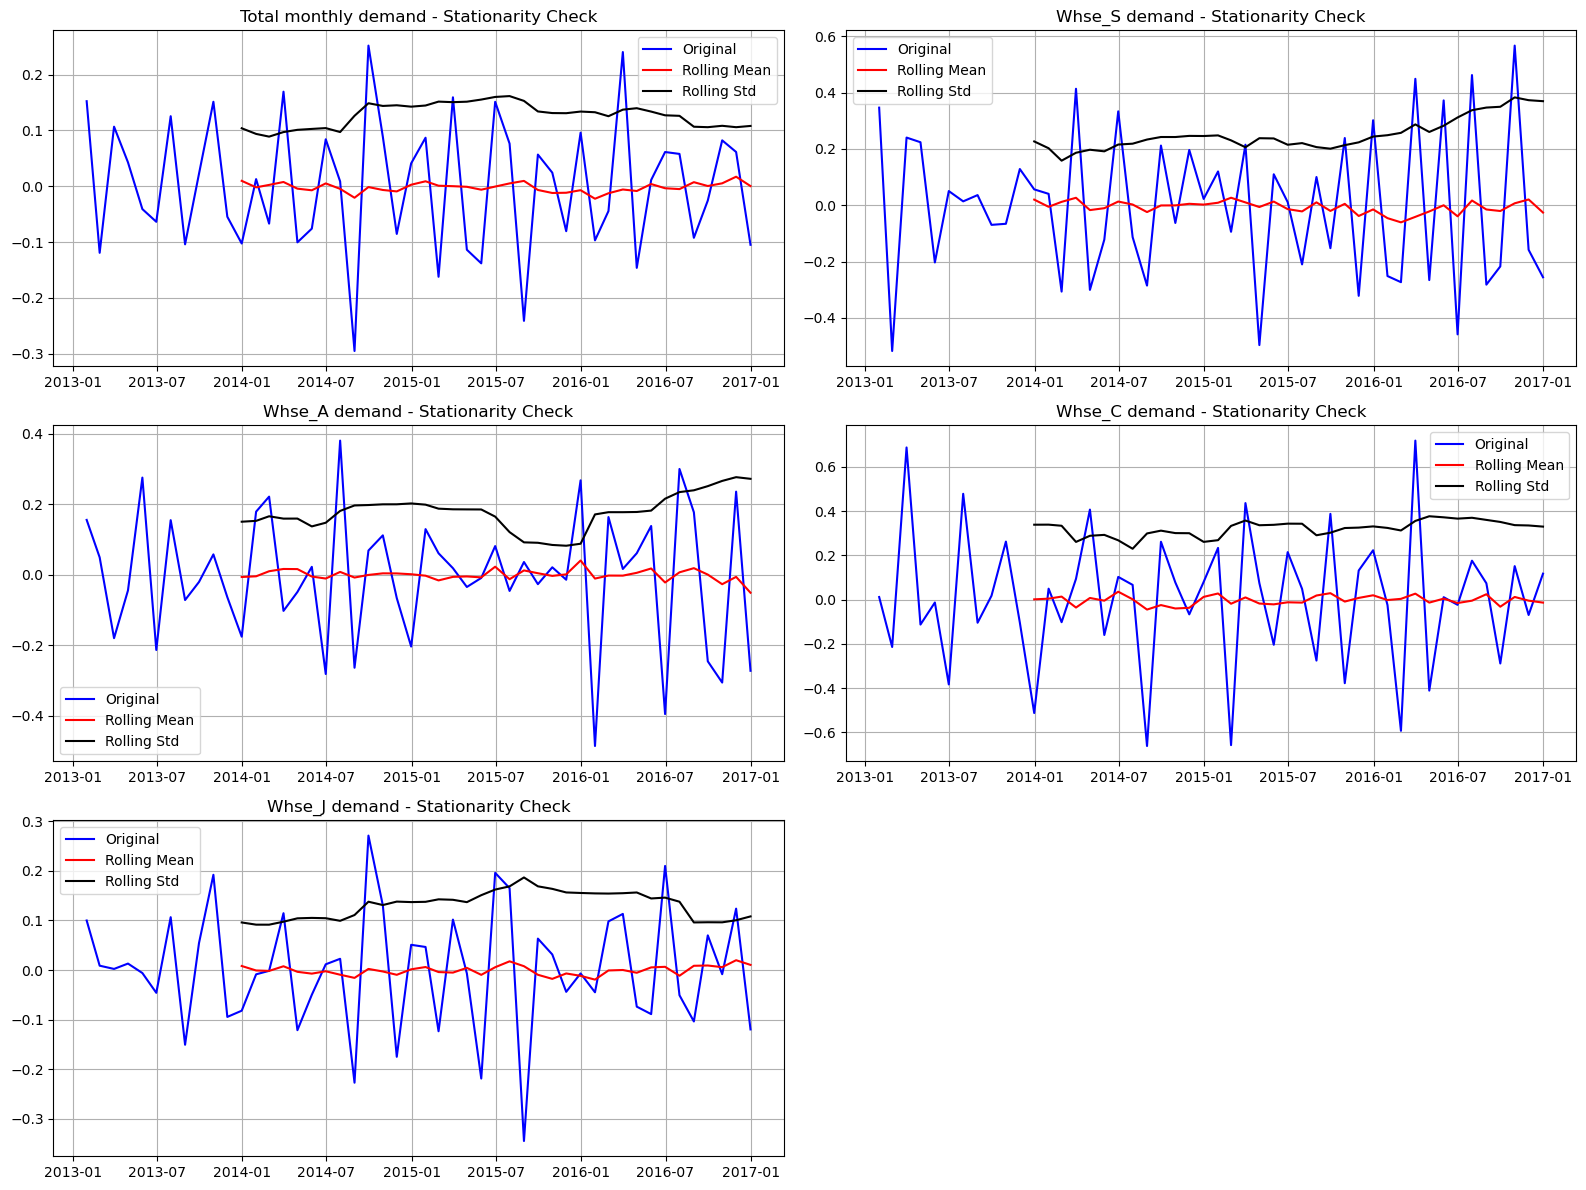

In [172]:

def stationarity_test(differenced_datasets, dataset_names):
    n = len(differenced_datasets)
    rows, cols = 3, 2
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12), sharex=False)
    axes = axes.flatten()

    def interpret_dftest(dataset, dataset_name):
        dftest = sm.tsa.adfuller(dataset, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4],
                             index=[f'{dataset_name} Test Statistic',
                                    f'{dataset_name} p-value',
                                    f'{dataset_name} Lag used',
                                    f'{dataset_name} Number of observations used'])
        for key, value in dftest[4].items():
            dfoutput[f'Critical value ({key})'] = value
        print(f'\nADF Test Results for {dataset_name}:\n{dfoutput}\n')

    for i, (dataset, dataset_name) in enumerate(zip(differenced_datasets, dataset_names)):
        roll_mean = dataset.rolling(window=12).mean()
        roll_std = dataset.rolling(window=12).std()

        axes[i].plot(dataset, color='blue', label='Original')
        axes[i].plot(roll_mean, color='red', label='Rolling Mean')
        axes[i].plot(roll_std, color='black', label='Rolling Std')
        axes[i].set_title(f'{dataset_name} - Stationarity Check')
        axes[i].legend()
        axes[i].grid(True)

        interpret_dftest(dataset, dataset_name)

    # Hide unused subplots
    for j in range(n, rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

 
stationarity_test(differenced_datasets, dataset_names)    


##### After one differencing our data is looking pretty stationary
##### therefore, we will stick with a differencing value of 1.

##### For the Total demand dataset can see a significant decrease in the p-value from a value of 0.26 to 0.026 lower than the threshold of 0.05
##### This means that it is okay to reject the null hypothesis. The test statistics shows that we can reject the null hypothesis at a confidence
##### level of 95%  

##### After the two methods above for centring the mean around zero, subtracting the rolling mean from the logged dataset and then subtracting the weighted average 
##### the weighted average method gave us a better result with a p-value of 0.12. 
##### Substracting the mean centers the data around zero but does not remove the trend component , this is where differencing comes in. 

### 7c. Analysing decomposed data 

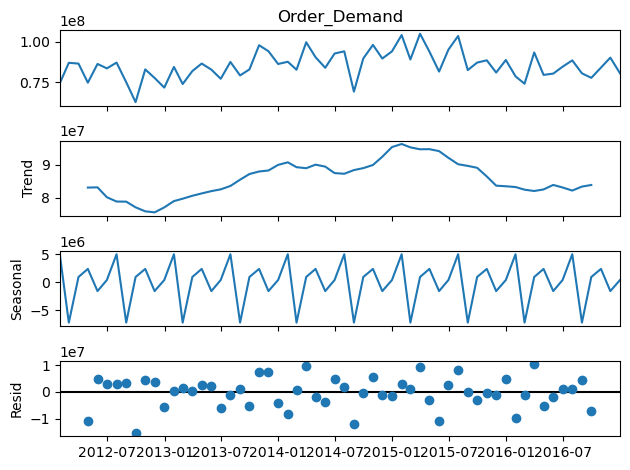

In [173]:
# Decompose time series into components
entire_monthly_demand_components = sm.tsa.seasonal_decompose(entire_monthly_demand, model="additive", period=6)

# Extract components
trend = entire_monthly_demand_components.trend
seasonality = entire_monthly_demand_components.seasonal
resid = entire_monthly_demand_components.resid

# Plot the decomposition
fig = entire_monthly_demand_components.plot() 
plt.show() 

##### Trend:
##### -The trend shows an upward movement in the data, but it is not very strong.     
##### Seasonality:
##### - The seasonal component fluctuates between -5 million and 5 million, showing a repeating pattern however this does not necessarily confirm the presence of seasonality, and the fluctuations may very well be random. we will confirm this further using Exogenous features
##### Residual:
##### - The residuals appear to have a mean around zero and constant variance, which suggests that most variations are captured by the trend and seasonality components,before concluding however, you will check the Autocorrelation (ACF/PACF) to see if any patterns remain unexplained.

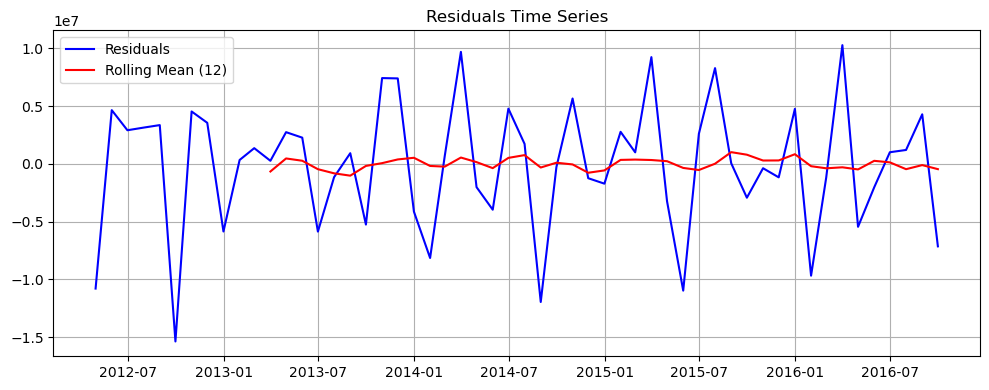


ADF Test Result:

Residuals Test Statistic                 -4.997230
Residuals p-value                         0.000022
Residuals Lags Used                       5.000000
Residuals Number of Observations Used    48.000000
Critical Value (1%)                      -3.574589
Critical Value (5%)                      -2.923954
Critical Value (10%)                     -2.600039
dtype: float64


In [174]:
def test_residual_stationarity(resid, title="Residuals"):
    
    # Drop missing values
    resid = resid.dropna()

    # Calculate rolling mean
    rolling_mean = resid.rolling(window=12).mean()

    # Plot residuals and rolling mean
    plt.figure(figsize=(10, 4))
    plt.plot(resid, label='Residuals', color='blue')
    plt.plot(rolling_mean, label='Rolling Mean (12)', color='red')
    plt.title(f'{title} Time Series')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ADF test
    dftest = sm.tsa.adfuller(resid, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
        f'{title} Test Statistic',
        f'{title} p-value',
        f'{title} Lags Used',
        f'{title} Number of Observations Used'
    ])

    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value

    print("\nADF Test Result:\n")
    print(dfoutput)

test_residual_stationarity(resid, title="Residuals")

### 8. Determining the values for AR and MA

##### We have our value for the 'I' component in ARIMA as 1, now we must get the
##### AR(number of past forecast data(p)) and MA(number of past forecast errors(q)) values  

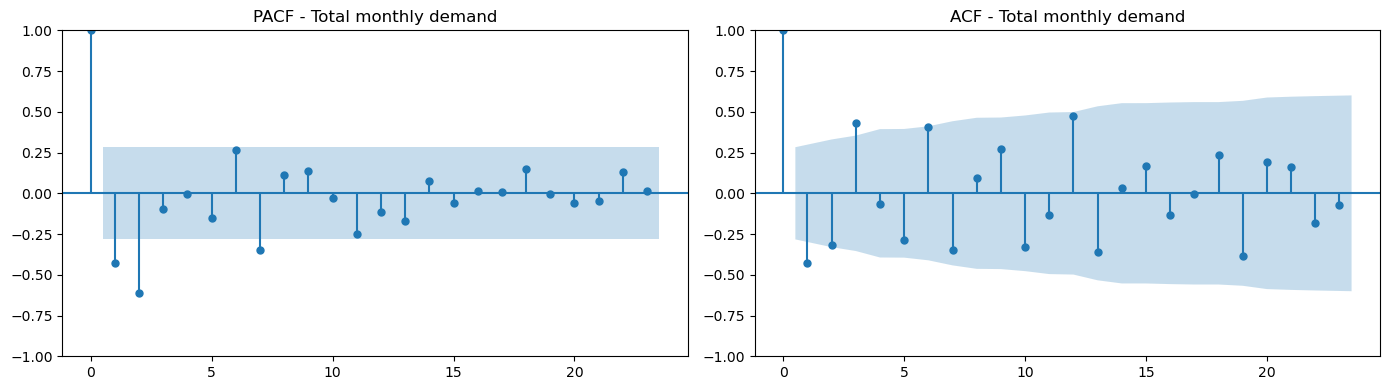

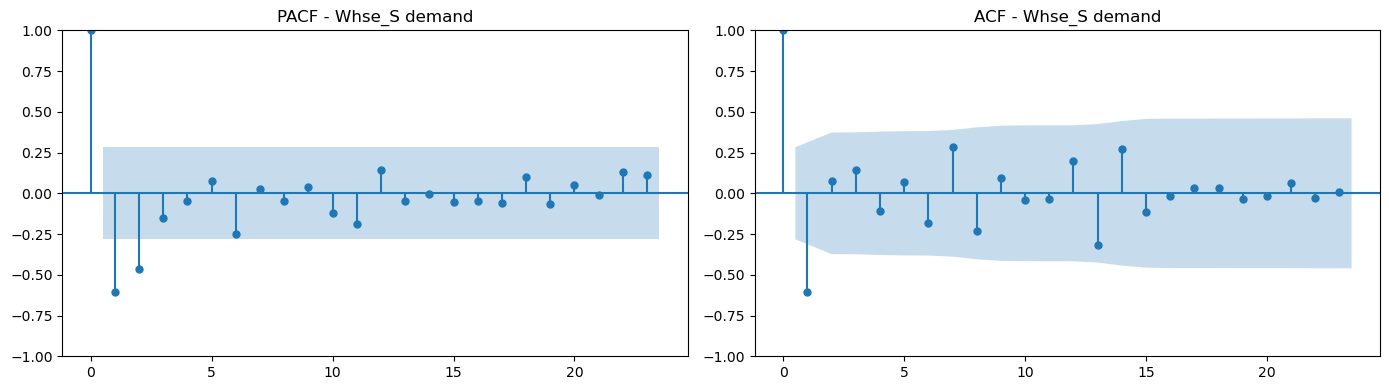

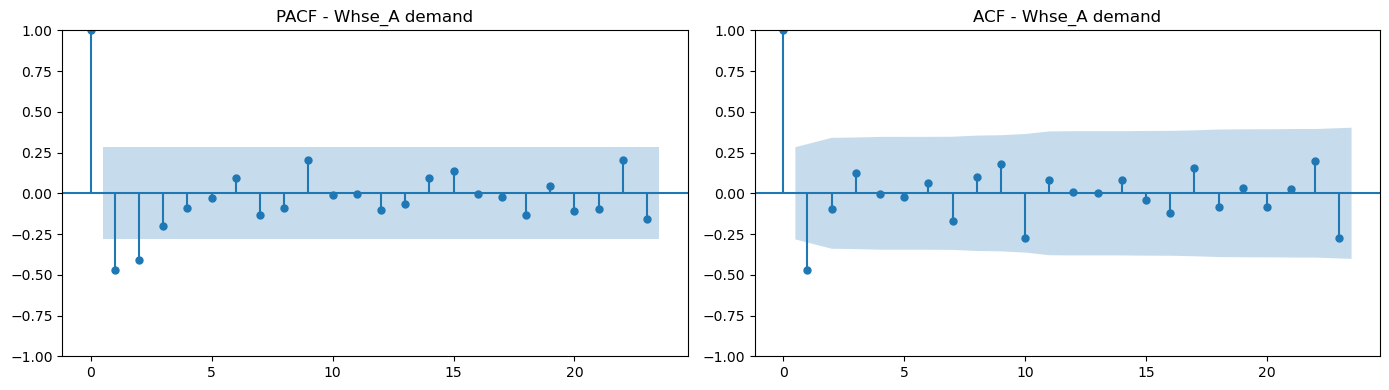

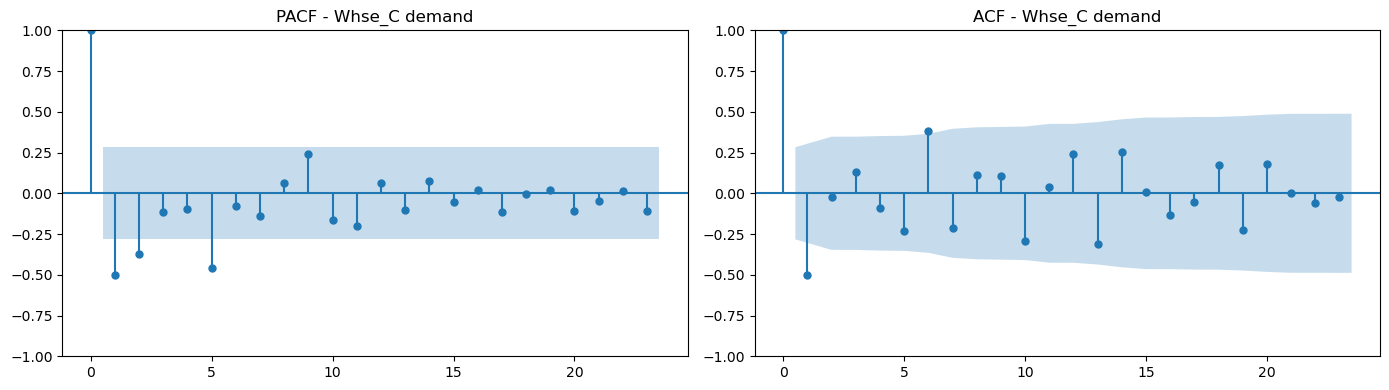

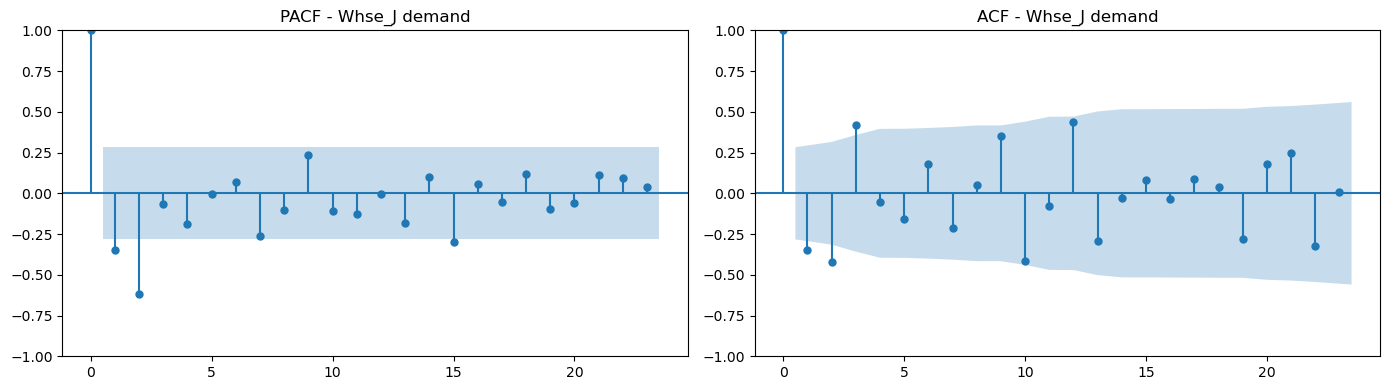

In [175]:
def plot_pcaf_acf(differenced_datasets, dataset_names):
    for dataset, dataset_name in zip(differenced_datasets, dataset_names):
        dataset = dataset.dropna()
        max_lags = min(40, len(dataset) // 2 - 1)  

        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        # Plot PACF
        plot_pacf(dataset, ax=axes[0], lags=max_lags, method='ywm')
        axes[0].set_title(f'PACF - {dataset_name}')

        # Plot ACF
        plot_acf(dataset, ax=axes[1], lags=max_lags)
        axes[1].set_title(f'ACF - {dataset_name}')

        plt.tight_layout()
        plt.show()


plot_pcaf_acf(differenced_datasets, dataset_names)

# The significant lags for PACF and ACF for the 5 datasets

pacf_acf_values = [(2,3),(2,1),(2,1),(2,1),(2,3)]

##### The 5 plot above shows the PACF and ACF values for the Total demand dataset and each ware house demand dataset
##### looking at the first two plots for the Total demand we see that we have 2 lags has spiked out of the 
##### confidence interval followed by a flatline of the rest therefore out ideal PACF(p) value is 2 and then the 
##### second plot shows us only 1 lag spiked beyound the confidence interval there the ideal value for the ACF(q) is 1
##### i have put together the values on a list  which i will pass to the ARIMA model.


### 6.  ARIMA Model Building

#### 6a. Grid Search

In [176]:
from statsmodels.tsa.arima.model import ARIMA

def evaluate_arima_models(time_series, dataset_names, p_values, d_values, q_values):
    results = []

    # Loop through datasets and time series to fit ARIMA models
    for name, series in zip(dataset_names, time_series):
        for p, d, q in itertools.product(p_values, d_values, q_values):
            try:
                model = ARIMA(series, order=(p, d, q))
                model_fit = model.fit()
                results.append({
                    'dataset': name,
                    'p': p,
                    'd': d,
                    'q': q,
                    'AIC': model_fit.aic
                })
            except Exception as e:
                print(f"Failed: {name} ARIMA({p},{d},{q}) - {e}")
                continue
    
    # Create DataFrame from results
    df = pd.DataFrame(results)
    
    # If no models were fitted, return an empty dictionary and the DataFrame
    if df.empty:
        print("No models were successfully fitted.")
        return {}, df

    # Find the best ARIMA model (lowest AIC) for each dataset
    best_params = {}
    grouped = df.groupby('dataset')
    for name, group in grouped:
        best_row = group.loc[group['AIC'].idxmin()]
        best_params[name] = (
            best_row['p'], best_row['d'], best_row['q'], best_row['AIC']
        )

    return best_params, df.sort_values(by=["dataset", "AIC"]).reset_index(drop=True)

p=d=q = range(0,3) 
a_grid_result = evaluate_arima_models(detrended_datasets,dataset_names, p, d, q)



##### The AIC evaluation above gives us the ideal order for each dataset containing the demand for a unique warehouse 
##### Total demand = (2,1,0) , Whse_S = (2,1,0) , Whse_A = (1,0,1) , Whse_C = (0,0,0) , Whse_J = (2,0,2)
##### We can see that the total demand has the best AIC when we have an AR value of 2 , differencing of 1 and an MA value of Zero
##### This means that we are using 2 past lag values and Zero error values for our Total demand model.  
##### Now I will be overriding the pacf_acf_values variable, replacing it with the order from the grid search.

In [177]:
search_values = a_grid_result[0]
search_values.values()
a_orders = [v[:3] for v in search_values.values()]

print(a_orders)

[(0, 0, 0), (0, 0, 0), (0, 0, 0), (2, 0, 2), (2, 1, 0)]


#### 6b. Fitting Model

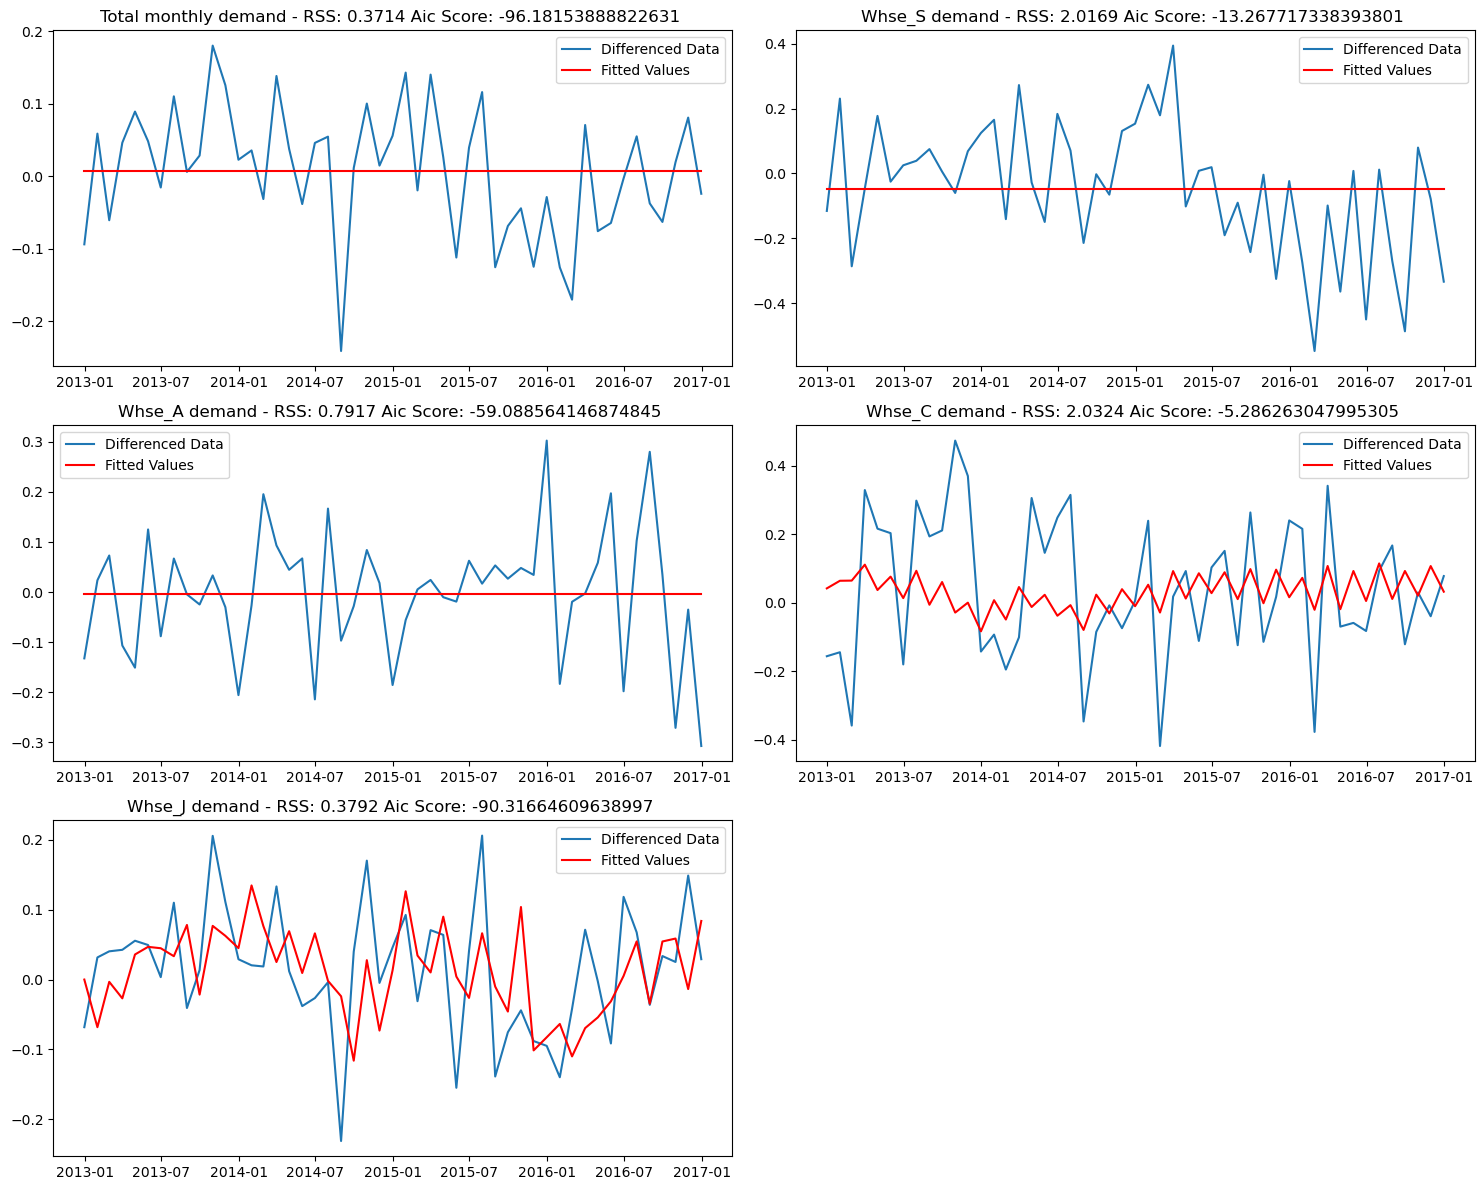

In [178]:
from statsmodels.tsa.arima.model import ARIMA

def model_building(detrended_datasets, orders, dataset_names):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
    axes = axes.flatten()

    fitted_models = []
    for i, (dataset, order, dataset_name) in enumerate(zip(detrended_datasets, orders, dataset_names)):
        dataset = dataset.dropna()
        model = ARIMA(dataset, order=(order[0],order[1], order[2]))
        fitted_model = model.fit()
        fitted_models.append(fitted_model)

        axes[i].plot(dataset, label='Differenced Data')
        axes[i].plot(fitted_model.fittedvalues, color='red', label='Fitted Values')

        # Align indices to avoid datetime subtraction issues
        residuals = fitted_model.fittedvalues.align(dataset, join='inner')[0] - dataset
        rss = (residuals ** 2).sum()

        axes[i].set_title(f"{dataset_name} - RSS: {rss:.4f} Aic Score: {fitted_model.aic} ")
        axes[i].legend()

    # Remove the unused subplot if less than 6 datasets
    for j in range(len(differenced_datasets), 6):
        fig.delaxes(axes[j])
     
    plt.tight_layout()
    plt.show()
    
    return fitted_models

fitted_models = model_building(detrended_datasets, a_orders, dataset_names)

#### 6c. Visualizing fitted predition against Original datset. 

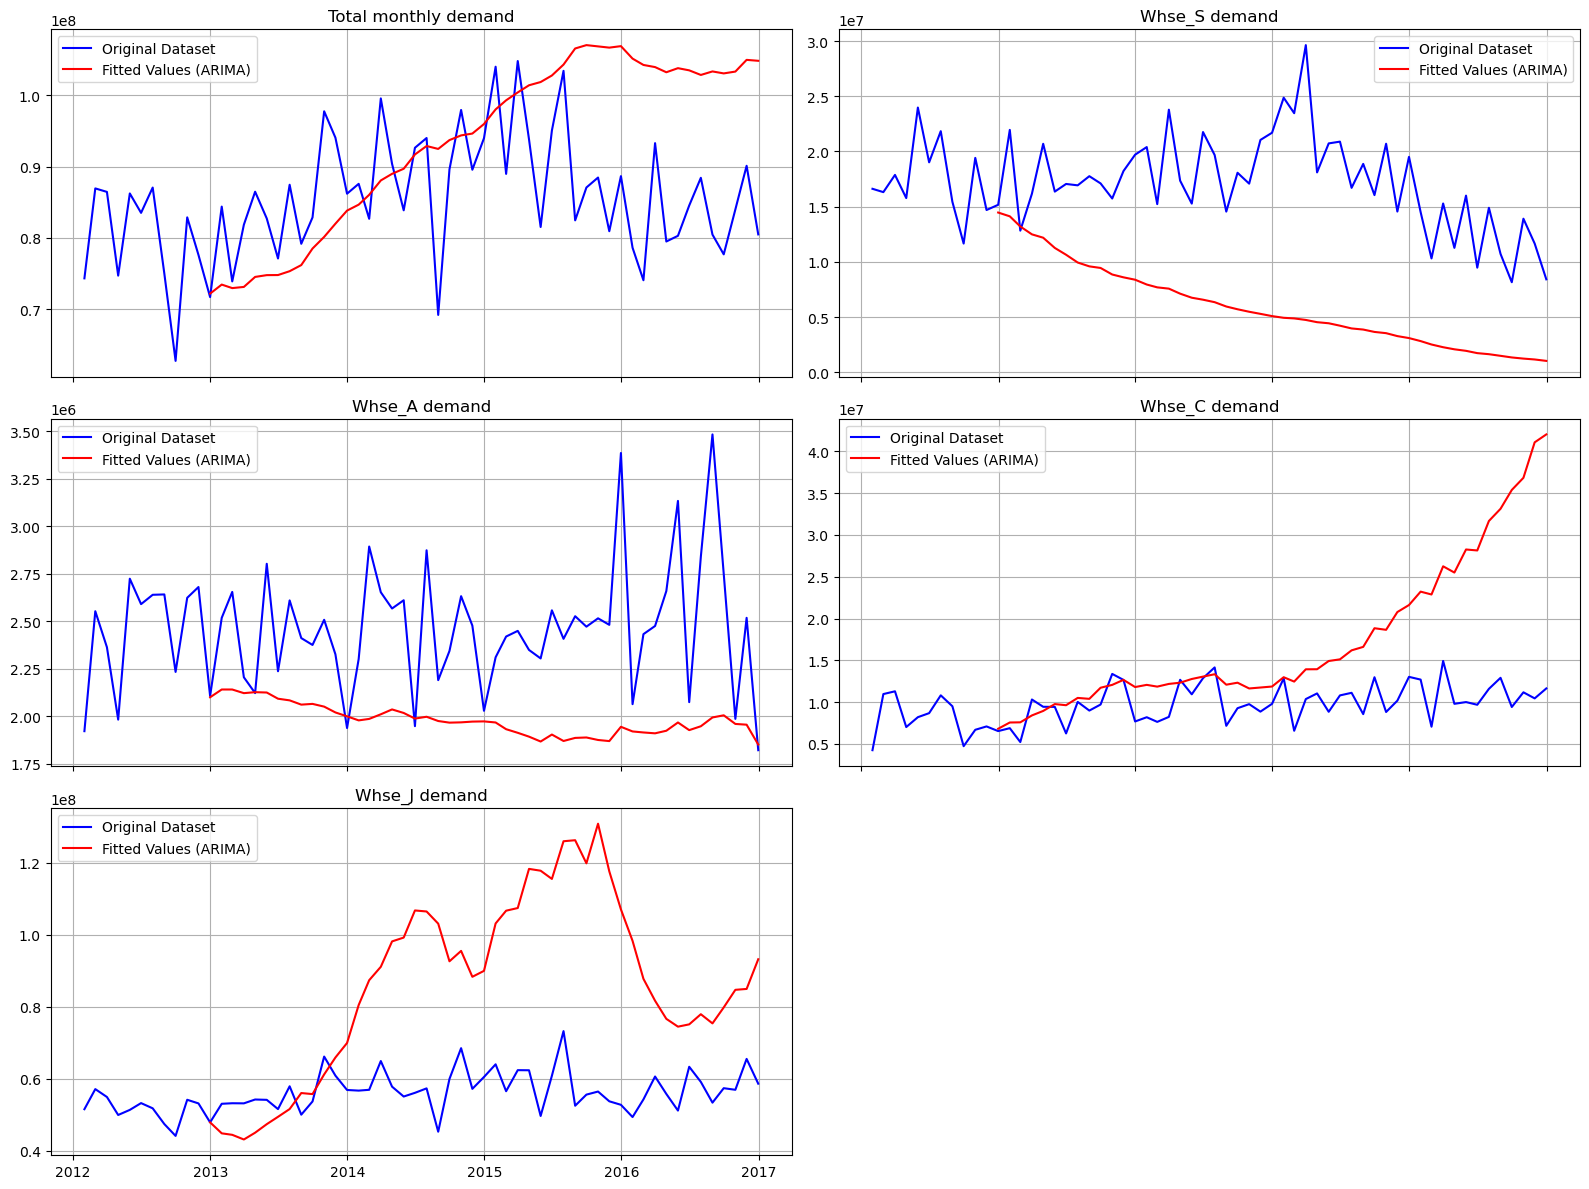

In [179]:
def plot_predictions_with_fitted(datasets, dataset_names, fitted_models, logged_data_minus_moving_average, moving_average):
    n = len(datasets)
    rows, cols = 3, 2
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12), sharex=True)

    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(n)]

    axes = axes.flatten()

    for i, (dataset, model, log_subtract_rollingmean_dataset, moving_average_) in enumerate(zip(datasets, fitted_models, logged_data_minus_moving_average, moving_average)):
        # put the prediction in a pandas series
        prediction_ARIMA_diff = pd.Series(model.fittedvalues, copy=True)

        # calculate the cumulative sum
        prediction_ARIMA_cumsum = pd.Series(prediction_ARIMA_diff.values.cumsum(), index=prediction_ARIMA_diff.index)

        # add back the trend component
        reconstructed_detrended = prediction_ARIMA_cumsum + log_subtract_rollingmean_dataset.iloc[0]

        # Reconstruct from log detrended to log scale
        final_log_predictions = reconstructed_detrended + moving_average_.loc[reconstructed_detrended.index]

        # Finally, revert the data to the normal scale
        final_predictions = np.exp(final_log_predictions)

        # Plotting
        axes[i].plot(dataset, label='Original Dataset', color='blue')
        axes[i].plot(final_predictions, label='Fitted Values (ARIMA)', color='red')
        axes[i].set_title(f"{dataset_names[i]}")
        axes[i].legend()
        axes[i].grid(True)

    # Hide extra subplots if any
    for j in range(n, rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
# Example usage:
# Assuming `fitted_models`, `logged_data_minus_moving_average`, and `moving_averages` are lists containing your fitted ARIMA models, detrended data, and rolling averages respectively.
plot_predictions_with_fitted(datasets, dataset_names, fitted_models, logged_data_minus_moving_average, moving_average)

#### 6d. Forecast 

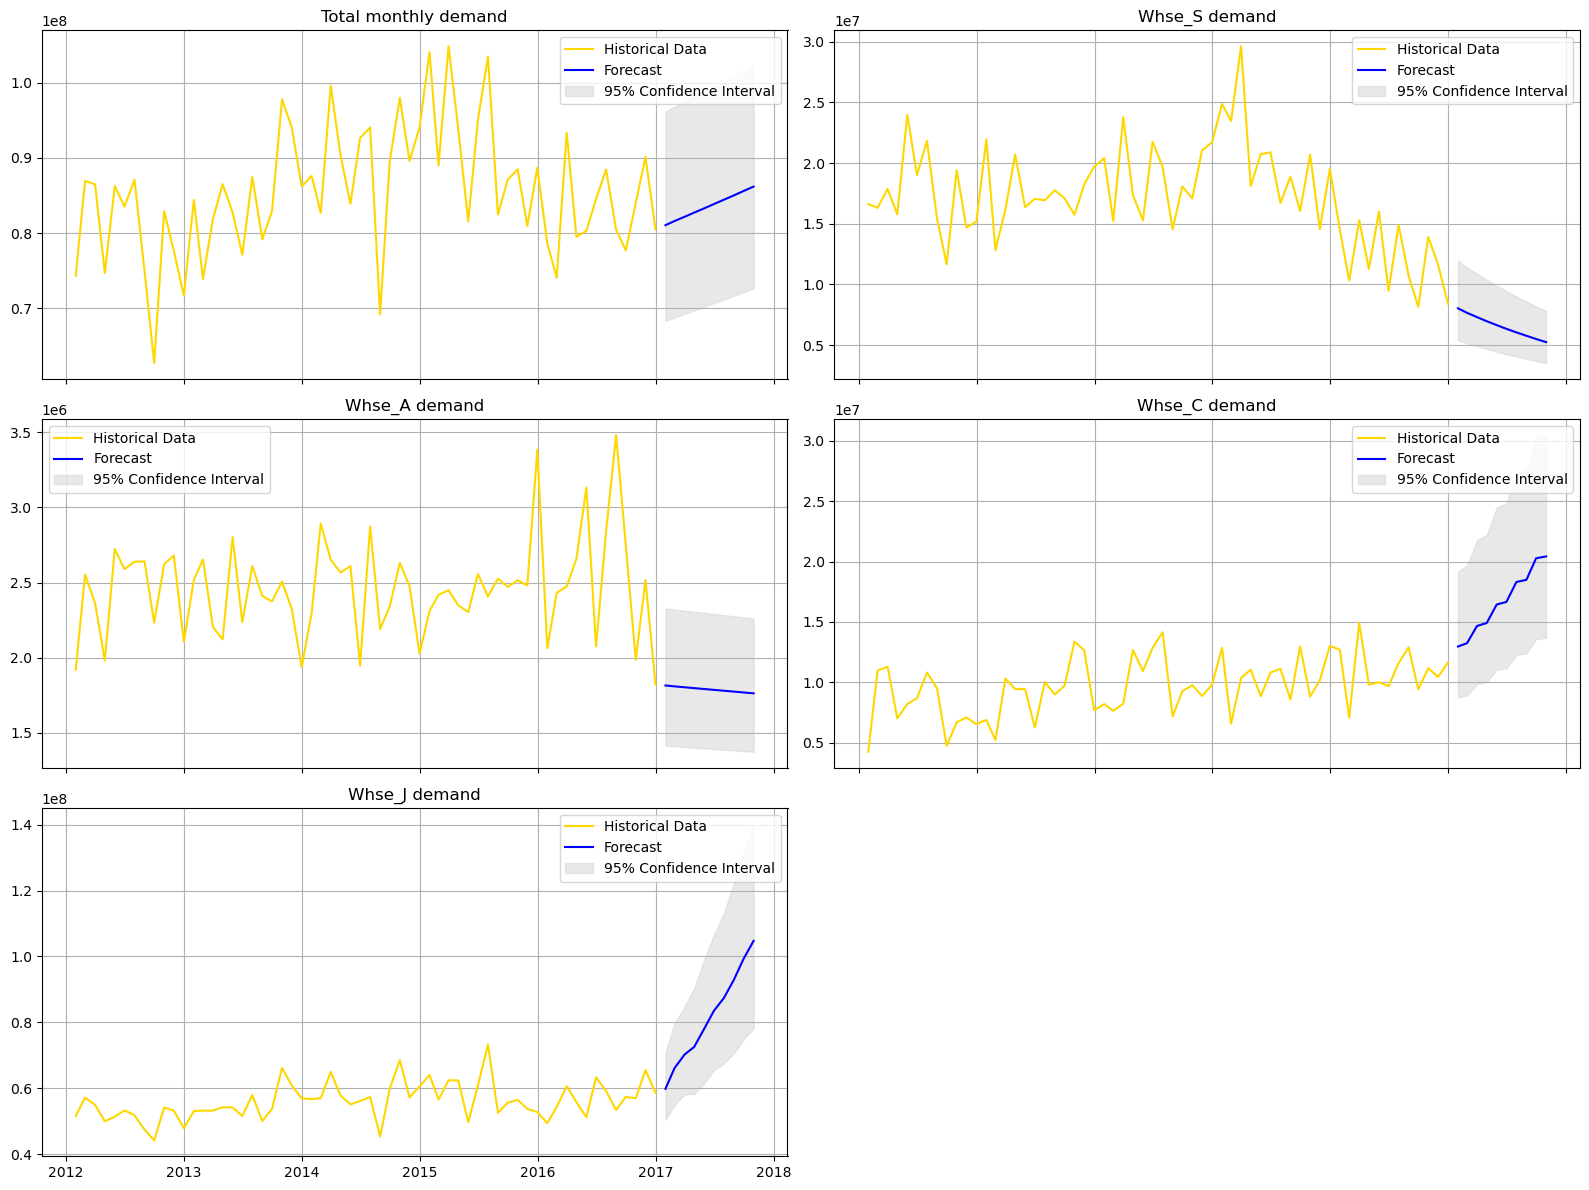

In [180]:

def forecast_and_plot(datasets, dataset_names, fitted_models, n_steps=10):
    fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
    axes = axes.flatten()

    for i, (dataset,log_subtract_rollingmean_dataset,moving_average_,dataset_name, model) in enumerate(zip(datasets,logged_data_minus_moving_average,moving_average, dataset_names, fitted_models)):
        # Step 1: Forecasting
        last_date = dataset.index[-1]
        forecast_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=n_steps, freq='M')
        forecast_res = model.get_forecast(steps=n_steps)
        forecast_diff = forecast_res.predicted_mean
        conf_int = forecast_res.conf_int(alpha=0.05)

        # Step 2: Undo differencing
        last_log_detrended_value = log_subtract_rollingmean_dataset.iloc[-1]
        forecast_detrended = last_log_detrended_value + forecast_diff.cumsum()

        # Step 3: Add back trend using flat extrapolation
        last_trend_value = moving_average_.iloc[-1]
        extended_trend = pd.Series([last_trend_value] * n_steps, index=forecast_index)

        forecast_log = forecast_detrended + extended_trend

        # Reconstruct confidence intervals
        conf_int_log = pd.DataFrame(index=forecast_index)
        conf_int_log[0] = forecast_log + (conf_int.iloc[:, 0] - forecast_diff)
        conf_int_log[1] = forecast_log + (conf_int.iloc[:, 1] - forecast_diff)

        # Invert log
        forecast_original = np.exp(forecast_log)
        conf_int_original = np.exp(conf_int_log)

        # Step 6: Get proper forecast index
        forecast_original.index = forecast_index
        conf_int_original.index = forecast_index

        # Step 7: Historical data in original scale
        historical_original = dataset

        # Plotting
        axes[i].plot(historical_original, label='Historical Data', color='gold')
        axes[i].plot(forecast_original, label='Forecast', color='blue')
        axes[i].fill_between(conf_int_original.index, conf_int_original.iloc[:, 0], conf_int_original.iloc[:, 1],
                             color='lightgrey', alpha=0.5, label='95% Confidence Interval')
        axes[i].set_title(f'{dataset_name}')
        axes[i].legend()
        axes[i].grid(True)
    
    # Hide the last unused subplot
    if len(datasets) < len(axes):
        fig.delaxes(axes[len(datasets)])

    plt.tight_layout()
    plt.show()


forecast_and_plot(datasets, dataset_names, fitted_models)


#### 6e. Model validation 

##### To evaluate the model further, we will look at the residuals, i.e the errors. For an ideal model that has captured the entire  
##### pattern of the series, the residuals has to follow a normal distribution and has to be centred around the mean, meaning they 
##### have to be close to zero; there has to be little to no right or left-skewed data caused by large values. We will show this
##### using a Histogram - plotting the PDF and KDF lines, Standardised residuals, QQ plot and the Correlogram, which shows the   
##### correlation between the residuals and past residuals ideally should not show any correlations. 

In [181]:
from scipy import stats

def plot_residual_diagnostics(fitted_models, dataset_names=None):
    for i, model in enumerate(fitted_models):
        residuals = model.resid
        standardized_residuals = (residuals - residuals.mean()) / residuals.std()

        # Title customization
        dataset_label = dataset_names[i] if dataset_names else f"Dataset {i+1}"

        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f"Residual Diagnostics for {dataset_label}", fontsize=14)

        # Plot 1: Residuals Over Time (raw, not standardized)
        axes[0, 0].plot(residuals)
        axes[0, 0].set_title("Residuals Over Time")
        axes[0, 0].set_xlabel("Time")
        axes[0, 0].set_ylabel("Residuals")

        # Plot 2: KDE vs Standard Normal PDF (using standardized residuals)
        sns.kdeplot(standardized_residuals, ax=axes[0, 1], color="orange", label="KDE")
        x_vals = np.linspace(standardized_residuals.min(), standardized_residuals.max(), 100)
        normal_pdf = stats.norm.pdf(x_vals, loc=0, scale=1)
        axes[0, 1].plot(x_vals, normal_pdf, 'g--', label="N(0,1)")
        axes[0, 1].set_title("Standardized Residuals: KDE vs Normal PDF")
        axes[0, 1].legend()

        # Plot 3: Q-Q Plot (standardized residuals)
        stats.probplot(standardized_residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title("Q-Q Plot (Standardized Residuals)")

        # Plot 4: ACF Plot (standardized residuals)
        plot_acf(standardized_residuals, ax=axes[1, 1], lags=20)
        axes[1, 1].set_title("Autocorrelation of Standardized Residuals")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


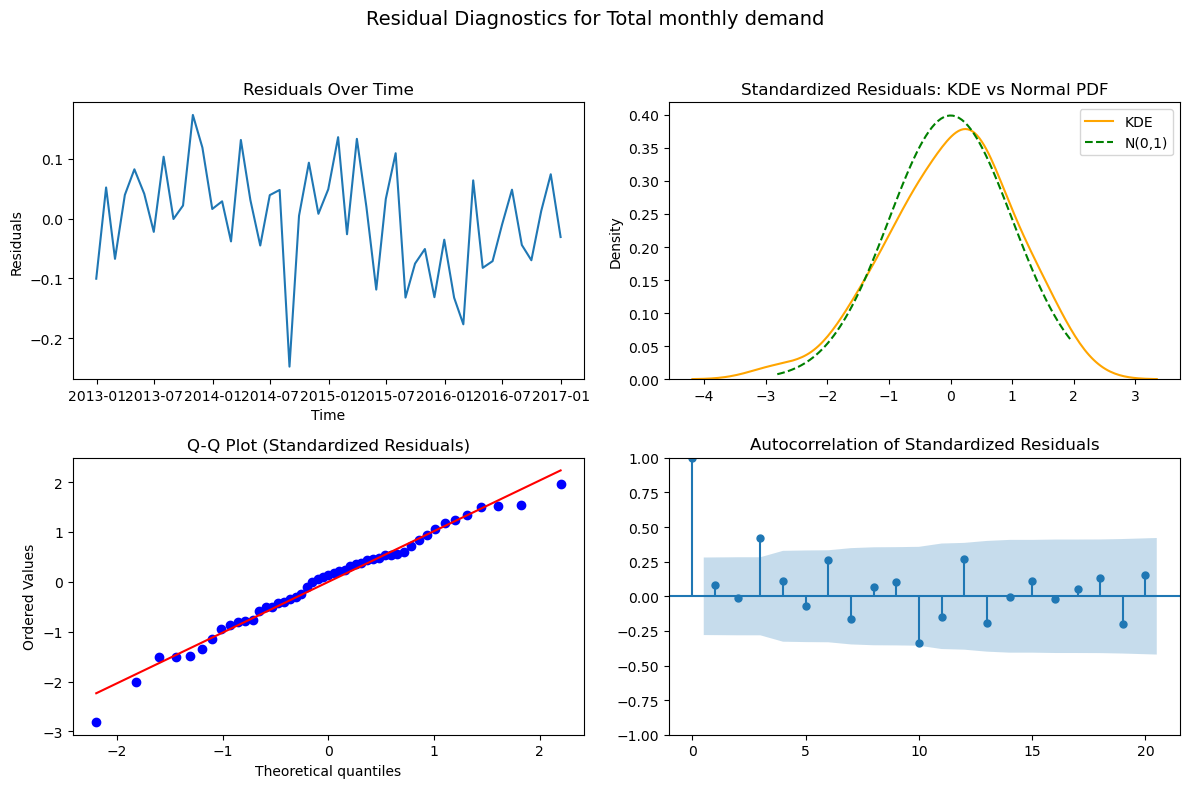

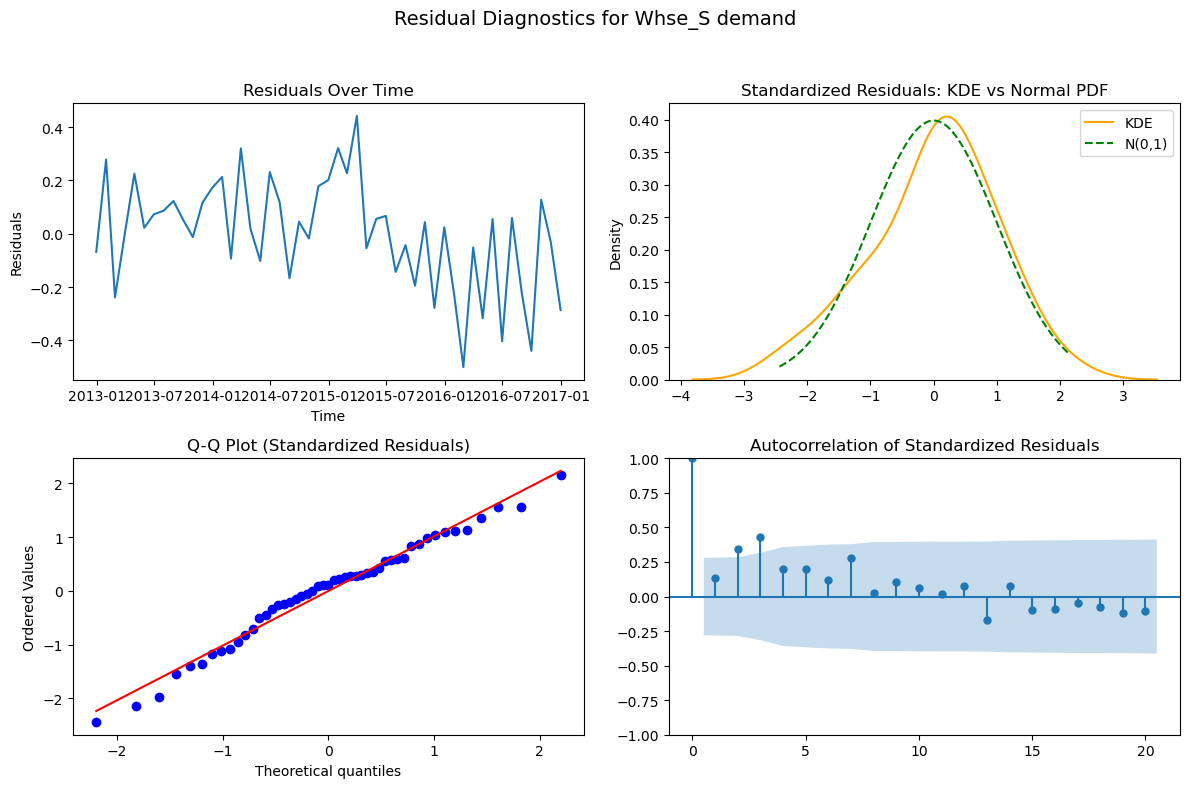

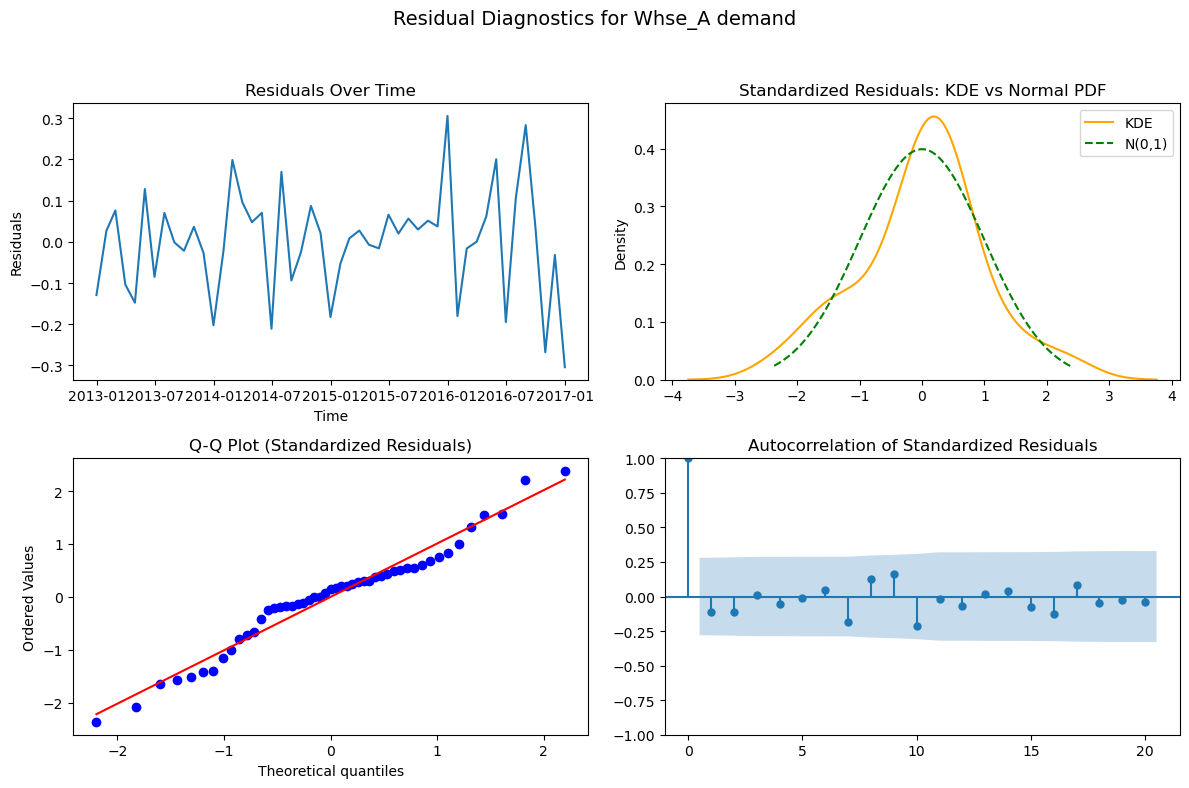

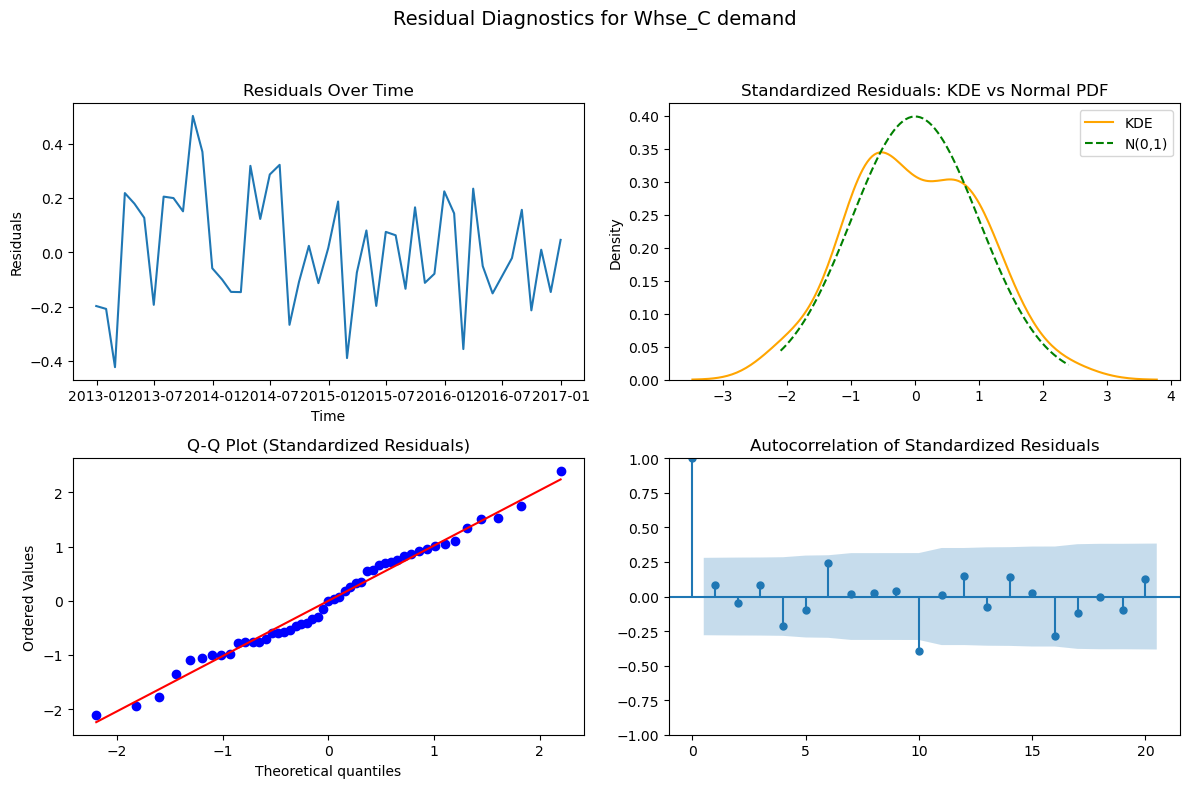

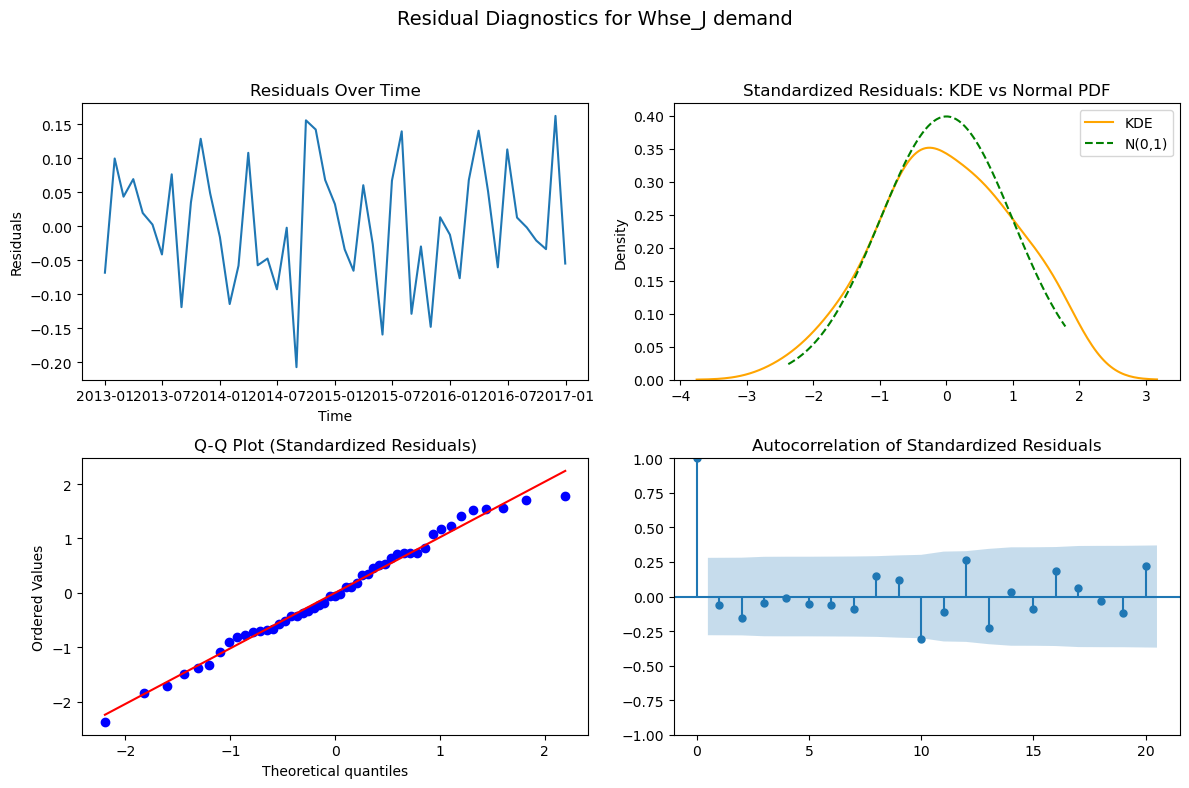

In [182]:
plot_residual_diagnostics(fitted_models,dataset_names)

##### The Histogram plot for our Total demand shows us that the KDE is roughly similar to the standard notation for a 
##### normal distribution with mean 0 and standard deviation of 1, the top of the line is not exactly bell-shaped 
##### and therefore not a perfect model we will be considering a SARIMA incliding seasonality to see if our model is better. 
##### 

### 7. SARIMA Model Building 

#### 7a. Grid Search

In [183]:

import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

def evaluate_sarima_models(time_series, dataset_names, 
                            p_values, d_values, q_values,
                            P_values, D_values, Q_values, seasonal_period):
    results = []

    for name, series in zip(dataset_names, time_series):
        for p, d, q in itertools.product(p_values, d_values, q_values):
            for P, D, Q in itertools.product(P_values, D_values, Q_values):
                try:
                    model = SARIMAX(series,
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, seasonal_period),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
                    model_fit = model.fit(disp=False)
                    results.append({
                        'Dataset': name,
                        'p': p, 'd': d, 'q': q,
                        'P': P, 'D': D, 'Q': Q,
                        's': seasonal_period,
                        'AIC': model_fit.aic
                    })
                except Exception as e:
                    continue

    df = pd.DataFrame(results)
    
    if df.empty:
        print("No models were successfully fitted.")
        return {}, df

    # Find best parameters per dataset (lowest AIC)
    best_params = {}
    grouped = df.groupby('Dataset')
    for name, group in grouped:
        best_row = group.loc[group['AIC'].idxmin()]
        best_params[name] = (
            best_row['p'], best_row['d'], best_row['q'],
            best_row['P'], best_row['D'], best_row['Q'],
            best_row['s']
        )

    return best_params, df.sort_values(by=["Dataset", "AIC"]).reset_index(drop=True)

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
seasonal_period = 12  # For monthly data



grid_result = evaluate_sarima_models(detrended_datasets, dataset_names, 
                            p, d, q,
                            P, D, Q, seasonal_period)



In [184]:
grid_result

({'Total monthly demand': (0, 0, 0, 0, 0, 0, 12),
  'Whse_A demand': (0, 0, 0, 0, 0, 0, 12),
  'Whse_C demand': (0, 0, 0, 1, 0, 0, 12),
  'Whse_J demand': (0, 0, 0, 0, 0, 0, 12),
  'Whse_S demand': (1, 1, 1, 0, 0, 0, 12)},
                   Dataset  p  d  q  P  D  Q   s          AIC
 0    Total monthly demand  0  0  0  0  0  0  12   -95.996184
 1    Total monthly demand  1  0  0  0  0  0  12   -94.395989
 2    Total monthly demand  0  0  1  0  0  0  12   -92.247693
 3    Total monthly demand  1  0  1  0  0  0  12   -91.954909
 4    Total monthly demand  0  1  1  0  0  0  12   -89.305917
 ..                    ... .. .. .. .. .. ..  ..          ...
 315         Whse_S demand  1  1  0  1  0  1  12  1156.281136
 316         Whse_S demand  1  1  0  0  0  1  12  1168.633012
 317         Whse_S demand  0  1  0  0  0  1  12  1201.150717
 318         Whse_S demand  1  1  1  1  0  1  12  1392.538543
 319         Whse_S demand  1  1  1  0  0  1  12  1404.480780
 
 [320 rows x 9 columns])

In [185]:
search_values = grid_result[0]
search_values.values()
s_orders = [v[:3] for v in search_values.values()]
seasonal_orders = [v[3:] for v in search_values.values()]

print(s_orders)
print(seasonal_orders)

[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 0, 12), (1, 0, 0, 12), (0, 0, 0, 12), (0, 0, 0, 12)]


##### Grid search on the sarima model shows us that the ideal p, q, and d values for, for example, the total demand is (0,0,0) . 
##### it also shows that the ideal values for the P, D, and Q are also (0,0,0). This tells us that there is not much
##### of a pattern to capture in the data.

#### 7b. Fitting Model

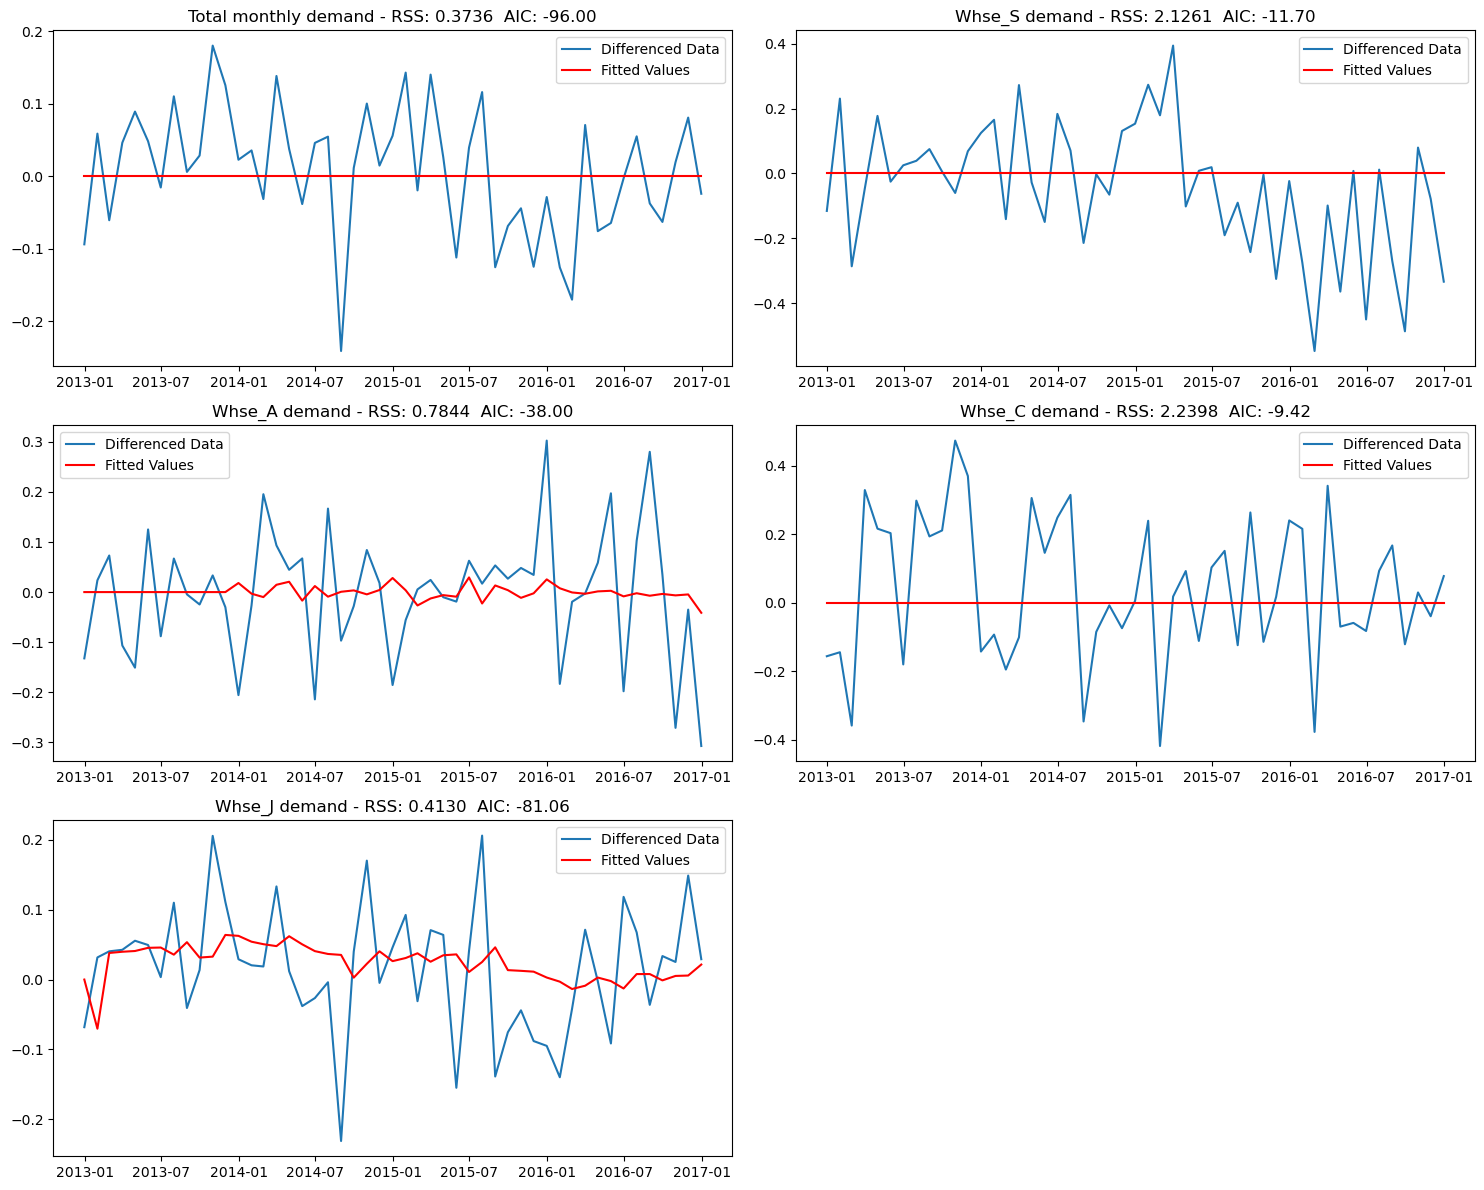

In [186]:

def model_building_sarima(detrended_datasets, orders, seasonal_orders, dataset_names):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
    axes = axes.flatten()

    s_fitted_models = []

    for i, (dataset, order, seasonal_order, dataset_name) in enumerate(zip(detrended_datasets, orders, seasonal_orders, dataset_names)):
        dataset = dataset.dropna()
        
        # Build SARIMA model
        model = SARIMAX(dataset, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        s_fitted_model = model.fit(disp=False)
        s_fitted_models.append(s_fitted_model)

        # Plot data and fitted values
        axes[i].plot(dataset, label='Differenced Data')
        axes[i].plot(s_fitted_model.fittedvalues, color='red', label='Fitted Values')

        # Align indices and calculate residuals
        residuals = s_fitted_model.fittedvalues.align(dataset, join='inner')[0] - dataset
        rss = (residuals ** 2).sum()

        # Title includes dataset name, RSS, and AIC
        axes[i].set_title(f"{dataset_name} - RSS: {rss:.4f}  AIC: {s_fitted_model.aic:.2f}")
        axes[i].legend()

    # Remove any unused subplots
    for j in range(len(detrended_datasets), 6):
        fig.delaxes(axes[j])
     
    plt.tight_layout()
    plt.show()
    
    return s_fitted_models


s_fitted_models = model_building_sarima(detrended_datasets, s_orders , seasonal_orders ,dataset_names )


#### 7c. Visualizing fitted predition against Original datset. 

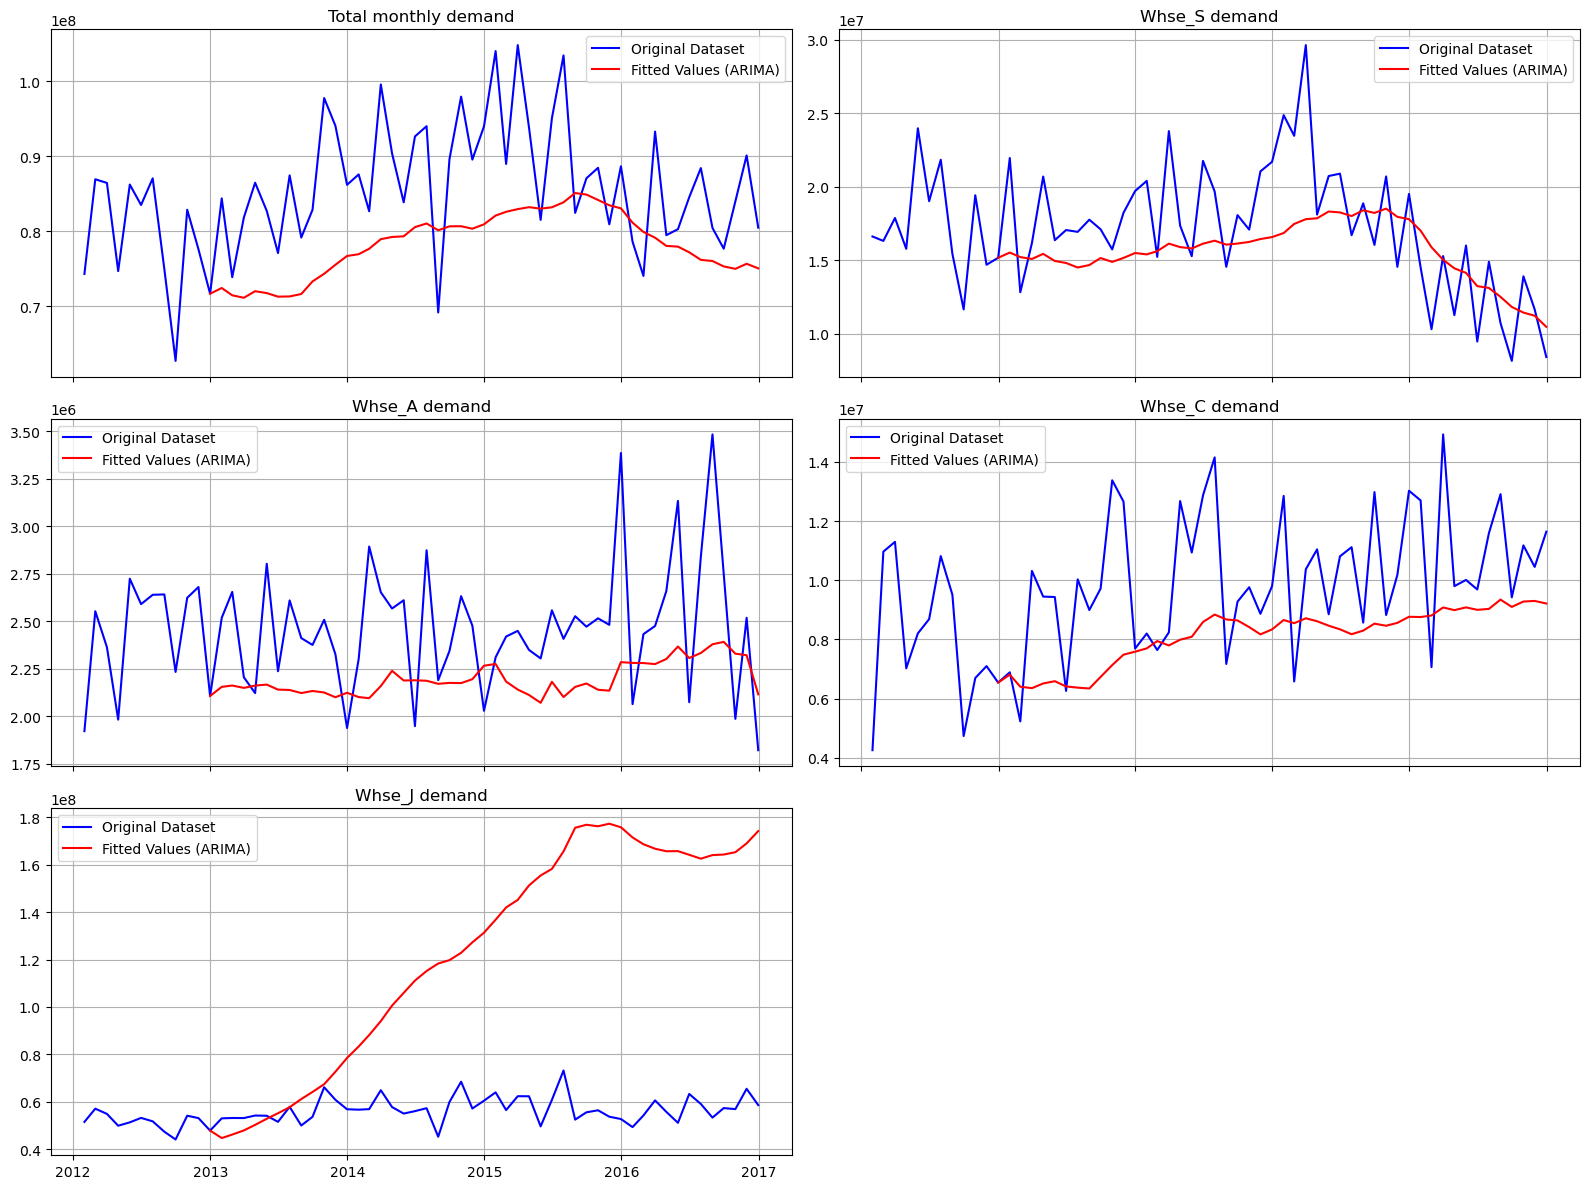

In [187]:
def plot_predictions_with_fitted(datasets, dataset_names, fitted_models, logged_data_minus_moving_average, moving_average):
    n = len(datasets)
    rows, cols = 3, 2
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12), sharex=True)

    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(n)]

    axes = axes.flatten()

    for i, (dataset, model, log_subtract_rollingmean_dataset, moving_average_) in enumerate(zip(datasets, fitted_models, logged_data_minus_moving_average, moving_average)):
        # put the prediction in a pandas series
        prediction_ARIMA_diff = pd.Series(model.fittedvalues, copy=True)

        # calculate the cumulative sum
        prediction_ARIMA_cumsum = pd.Series(prediction_ARIMA_diff.values.cumsum(), index=prediction_ARIMA_diff.index)

        # add back the trend component
        reconstructed_detrended = prediction_ARIMA_cumsum + log_subtract_rollingmean_dataset.iloc[0]

        # Reconstruct from log detrended to log scale
        final_log_predictions = reconstructed_detrended + moving_average_.loc[reconstructed_detrended.index]

        # Finally, revert the data to the normal scale
        final_predictions = np.exp(final_log_predictions)

        # Plotting
        axes[i].plot(dataset, label='Original Dataset', color='blue')
        axes[i].plot(final_predictions, label='Fitted Values (ARIMA)', color='red')
        axes[i].set_title(f"{dataset_names[i]}")
        axes[i].legend()
        axes[i].grid(True)

    # Hide extra subplots if any
    for j in range(n, rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_predictions_with_fitted(datasets, dataset_names, s_fitted_models, logged_data_minus_moving_average, moving_average)

#### 7d. Forecast 

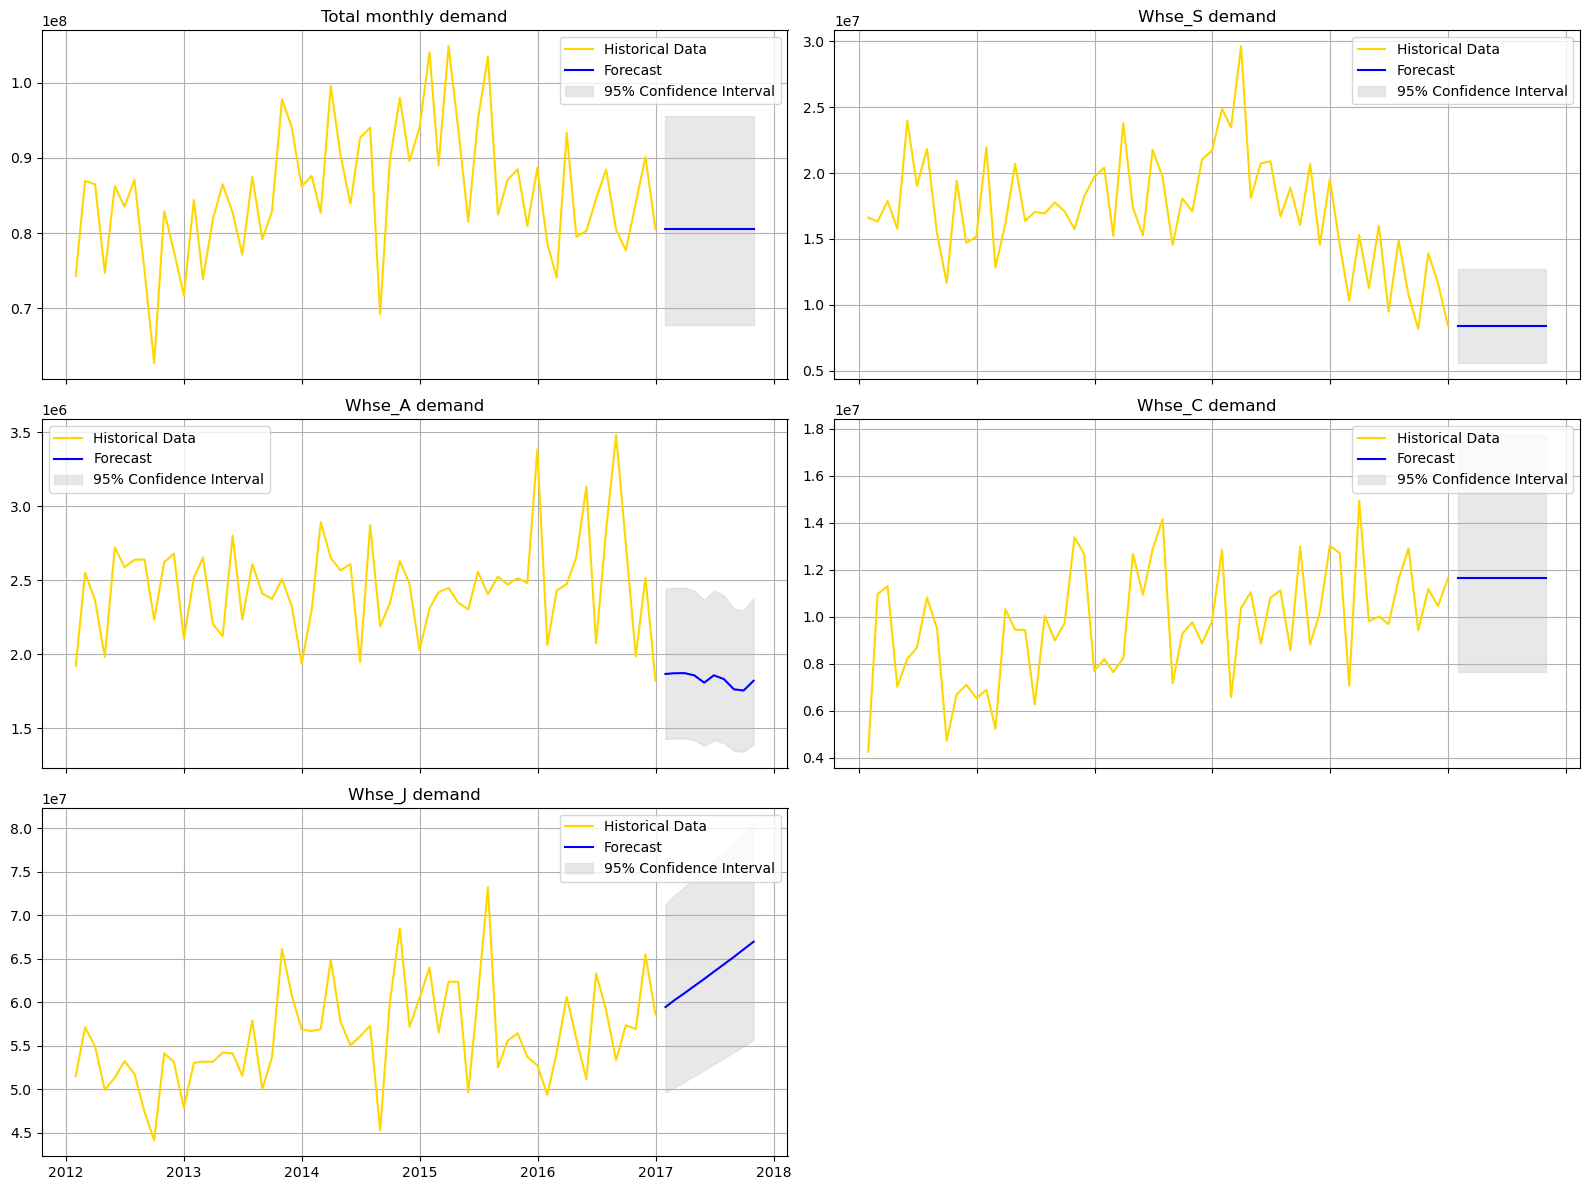

In [188]:
def forecast_and_plot(datasets, dataset_names, fitted_models, n_steps=10):
    fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
    axes = axes.flatten()

    for i, (dataset,log_subtract_rollingmean_dataset,moving_average_,dataset_name, model) in enumerate(zip(datasets,logged_data_minus_moving_average,moving_average, dataset_names, fitted_models)):
        # Step 1: Forecasting
        last_date = dataset.index[-1]
        forecast_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=n_steps, freq='M')
        forecast_res = model.get_forecast(steps=n_steps)
        forecast_diff = forecast_res.predicted_mean
        conf_int = forecast_res.conf_int(alpha=0.05)

        # Step 2: Undo differencing
        last_log_detrended_value = log_subtract_rollingmean_dataset.iloc[-1]
        forecast_detrended = last_log_detrended_value + forecast_diff.cumsum()

        # Step 3: Add back trend using flat extrapolation
        last_trend_value = moving_average_.iloc[-1]
        extended_trend = pd.Series([last_trend_value] * n_steps, index=forecast_index)

        forecast_log = forecast_detrended + extended_trend

        # Reconstruct confidence intervals
        conf_int_log = pd.DataFrame(index=forecast_index)
        conf_int_log[0] = forecast_log + (conf_int.iloc[:, 0] - forecast_diff)
        conf_int_log[1] = forecast_log + (conf_int.iloc[:, 1] - forecast_diff)

        # Invert log
        forecast_original = np.exp(forecast_log)
        conf_int_original = np.exp(conf_int_log)

        # Step 6: Get proper forecast index
        forecast_original.index = forecast_index
        conf_int_original.index = forecast_index

        # Step 7: Historical data in original scale
        historical_original = dataset

        # Plotting
        axes[i].plot(historical_original, label='Historical Data', color='gold')
        axes[i].plot(forecast_original, label='Forecast', color='blue')
        axes[i].fill_between(conf_int_original.index, conf_int_original.iloc[:, 0], conf_int_original.iloc[:, 1],
                             color='lightgrey', alpha=0.5, label='95% Confidence Interval')
        axes[i].set_title(f'{dataset_name}')
        axes[i].legend()
        axes[i].grid(True)
    
    # Hide the last unused subplot
    if len(datasets) < len(axes):
        fig.delaxes(axes[len(datasets)])

    plt.tight_layout()
    plt.show()


forecast_and_plot(datasets, dataset_names, s_fitted_models)


#### 7e. Model Evaluation 

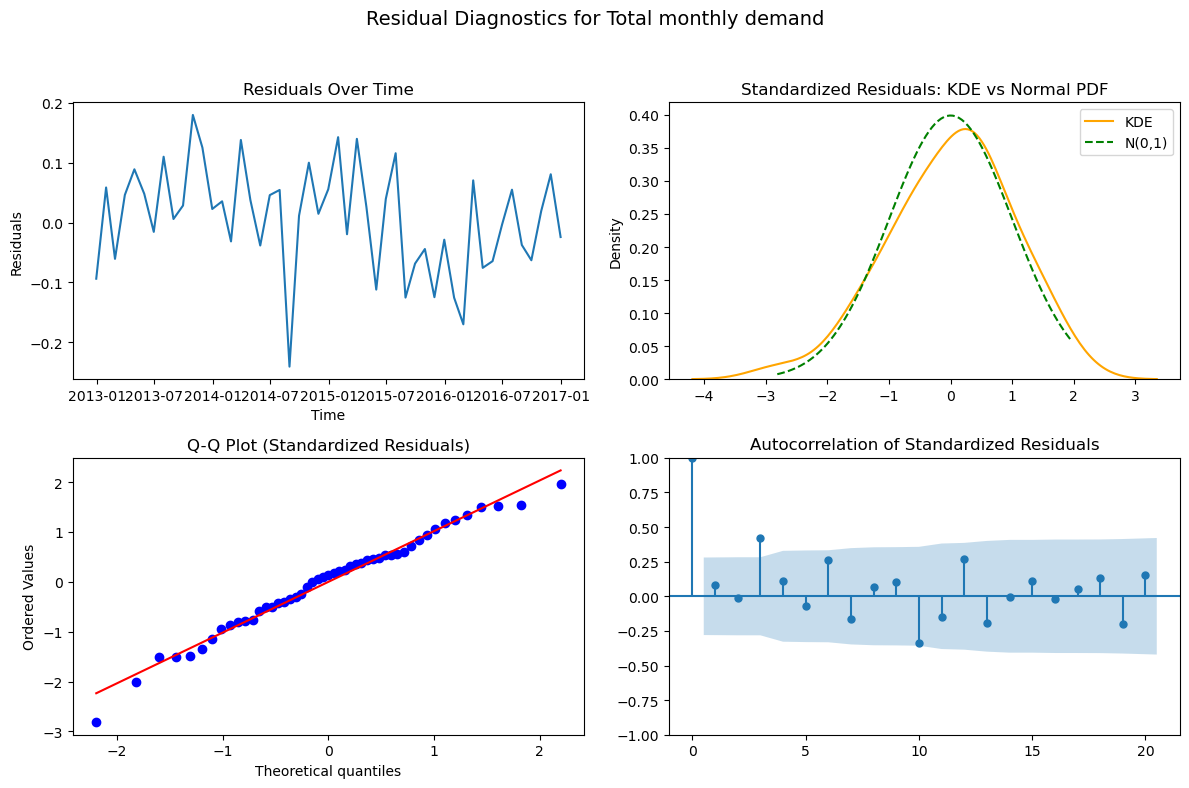

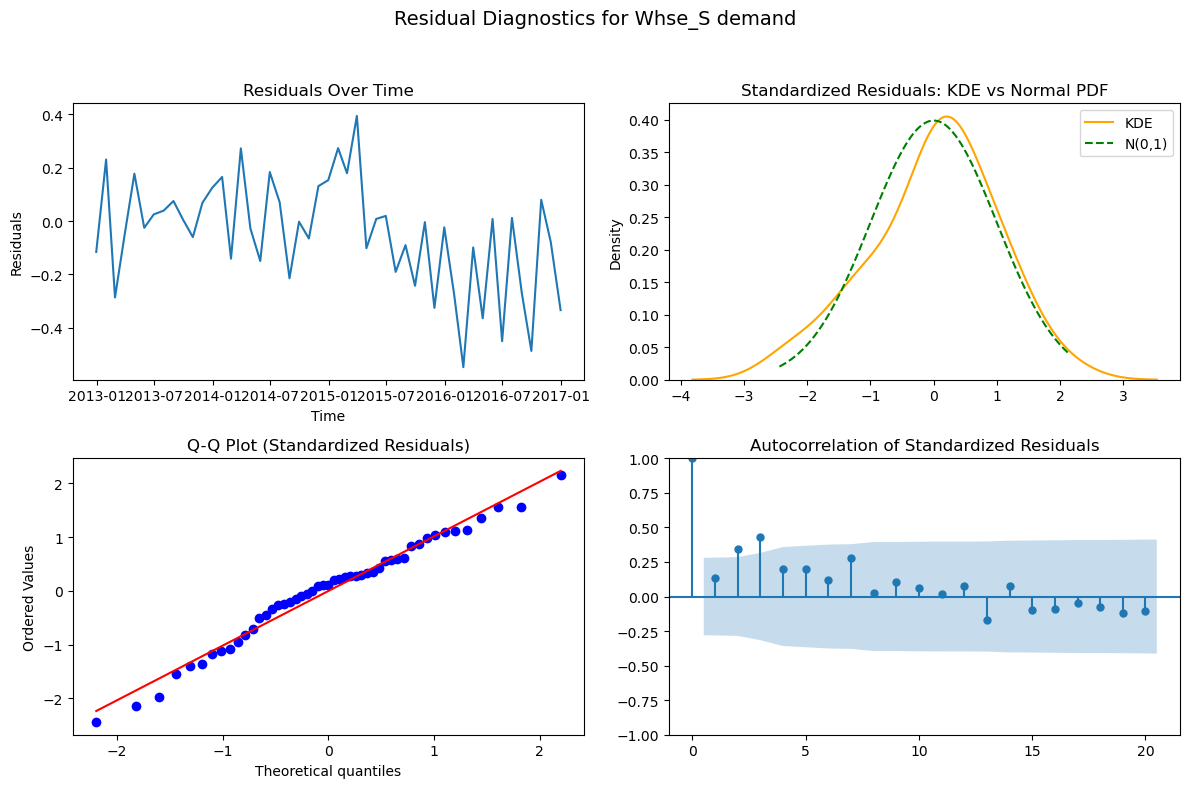

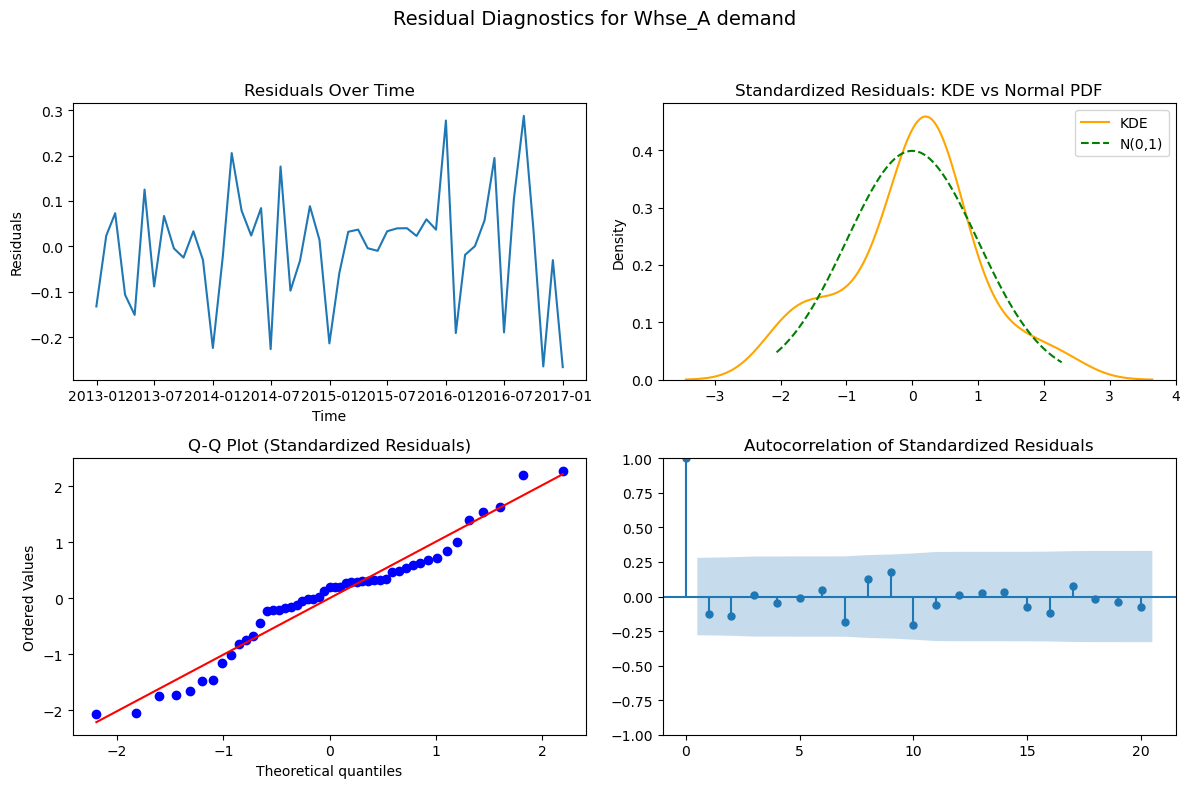

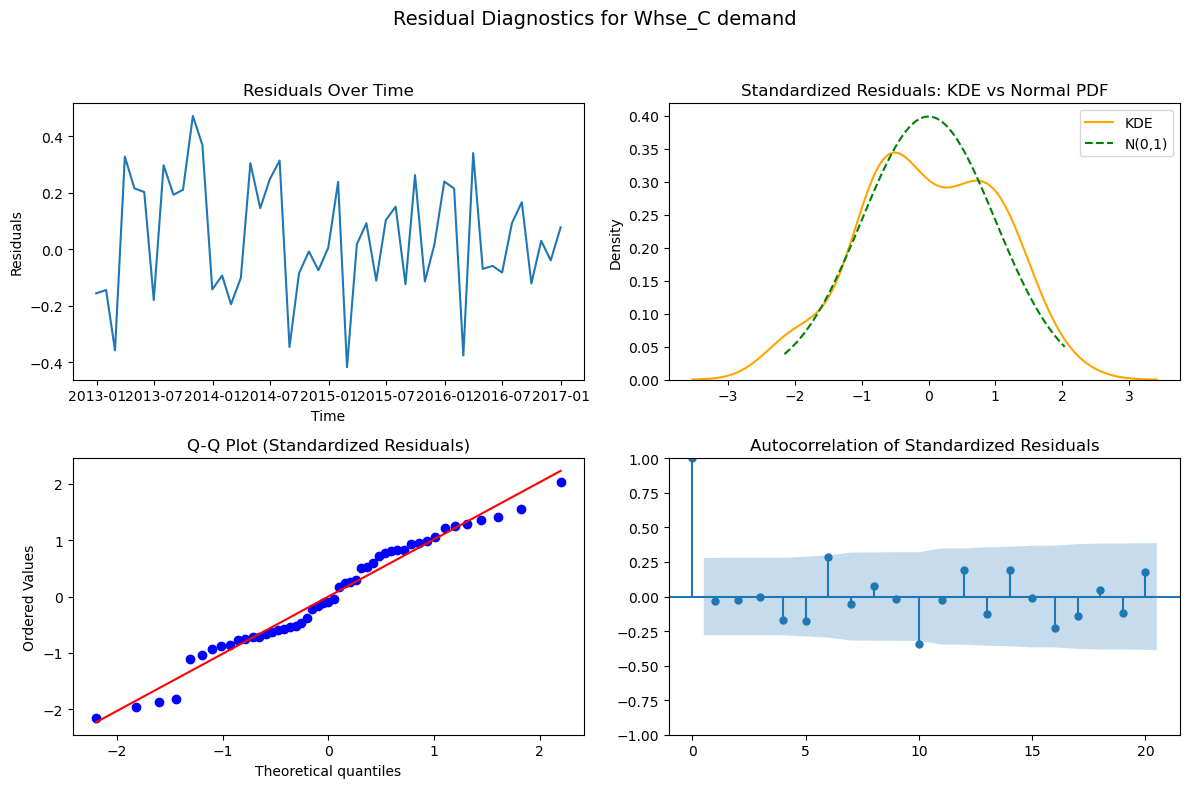

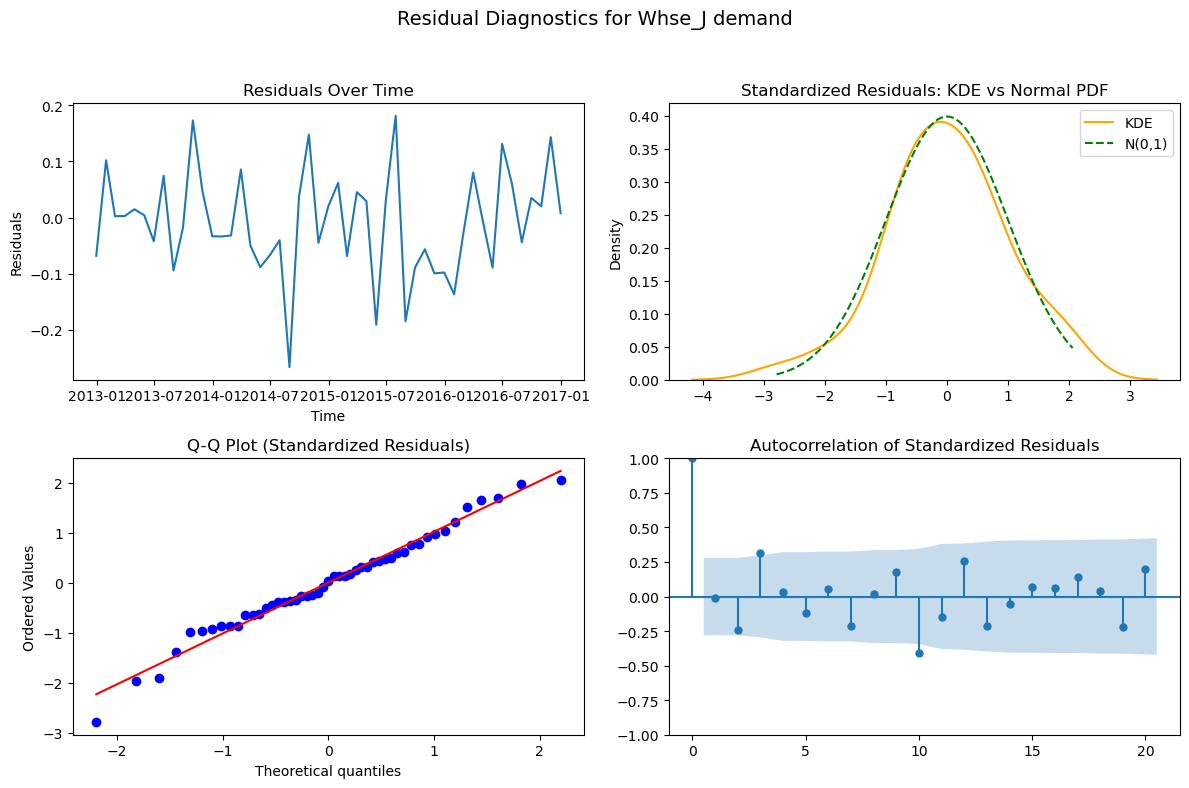

In [189]:
def plot_residual_diagnostics(fitted_models, dataset_names=None):
    for i, model in enumerate(fitted_models):
        residuals = model.resid
        standardized_residuals = (residuals - residuals.mean()) / residuals.std()

        # Title customization
        dataset_label = dataset_names[i] if dataset_names else f"Dataset {i+1}"

        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f"Residual Diagnostics for {dataset_label}", fontsize=14)

        # Plot 1: Residuals Over Time (raw, not standardized)
        axes[0, 0].plot(residuals)
        axes[0, 0].set_title("Residuals Over Time")
        axes[0, 0].set_xlabel("Time")
        axes[0, 0].set_ylabel("Residuals")

        # Plot 2: KDE vs Standard Normal PDF (using standardized residuals)
        sns.kdeplot(standardized_residuals, ax=axes[0, 1], color="orange", label="KDE")
        x_vals = np.linspace(standardized_residuals.min(), standardized_residuals.max(), 100)
        normal_pdf = stats.norm.pdf(x_vals, loc=0, scale=1)
        axes[0, 1].plot(x_vals, normal_pdf, 'g--', label="N(0,1)")
        axes[0, 1].set_title("Standardized Residuals: KDE vs Normal PDF")
        axes[0, 1].legend()

        # Plot 3: Q-Q Plot (standardized residuals)
        stats.probplot(standardized_residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title("Q-Q Plot (Standardized Residuals)")

        # Plot 4: ACF Plot (standardized residuals)
        plot_acf(standardized_residuals, ax=axes[1, 1], lags=20)
        axes[1, 1].set_title("Autocorrelation of Standardized Residuals")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
plot_residual_diagnostics(s_fitted_models,dataset_names)

##### We have better results from our second model , we an see that for the Total demand dataset the histogram plot(Top right)
##### shows that the KDE line follows closely with the PDF line and we have a sharp peak as oppose to the first model with a dented peak  
##### the standardized residual over time plot(Top left) shows that we do not have a pattern in the residual confirming that there is no
##### pattern left to model in the data. 

### Next i will build an ARIMA model capturing the last complete 12 months to see if there is any patterns to capture in the data 


In [541]:
# Sort by date 
data = data.sort_values('Date', ascending=True)

# Convert Order_Demand column to numeric
data['Order_Demand'] = data['Order_Demand'].astype(str).str.replace(r'[^\d]', '', regex=True)
data['Order_Demand'] = pd.to_numeric(data['Order_Demand'], errors='coerce')

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Extracting demand for 2015
data_2015 = data[data['Date'].dt.year == 2015]
entire_demand_2015 = data_2015[['Order_Demand', 'Date']].set_index('Date')
weekly_demand_2015 = entire_demand_2015['Order_Demand'].resample('W').sum()

# Extracting demand for 2016
data_2016 = data[data['Date'].dt.year == 2016]
entire_demand_2016 = data_2016[['Order_Demand', 'Date']].set_index('Date')
weekly_demand_2016 = entire_demand_2016['Order_Demand'].resample('W').sum()

# Dictionary to store separate DataFrames for each warehouse (2015)
demand_by_store_2015 = {}

for warehouse in data_2015['Warehouse'].unique():
    warehouse_df = data_2015[data_2015['Warehouse'] == warehouse].copy()
    warehouse_df.set_index('Date', inplace=True)
    weekly_df = warehouse_df['Order_Demand'].resample('W').sum().to_frame()
    weekly_df.columns = ['Weekly_Demand']
    demand_by_store_2015[warehouse] = weekly_df

# Dictionary to store separate DataFrames for each warehouse (2016)
demand_by_store_2016 = {}

for warehouse in data_2016['Warehouse'].unique():
    warehouse_df = data_2016[data_2016['Warehouse'] == warehouse].copy()
    warehouse_df.set_index('Date', inplace=True)
    weekly_df = warehouse_df['Order_Demand'].resample('W').sum().to_frame()
    weekly_df.columns = ['Weekly_Demand']
    demand_by_store_2016[warehouse] = weekly_df


### Assessing Stationarity 

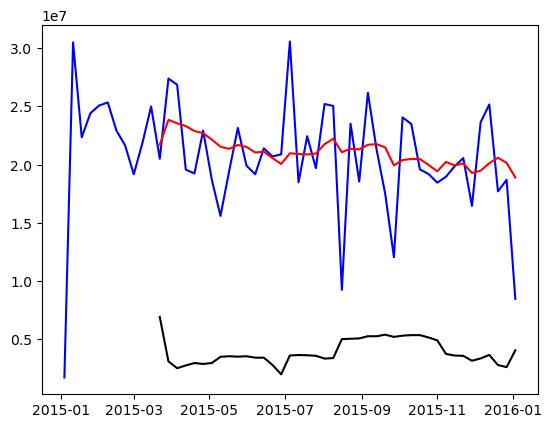

In [542]:
#Using the rolling statistics to analyse the stationarity of the dataset. 
roll_mean = weekly_demand_2015.rolling(window= 12).mean()
roll_std = weekly_demand_2015.rolling(window= 12).std()

plt.plot(weekly_demand_2015, color = 'Blue', label ='Oringinal')
plt.plot(roll_mean, color = 'Red', label = 'Rolling Mean')
plt.plot(roll_std, color = 'Black', label = 'Rolling Standard Deviation')
plt.show()

##### we can see that the first & last value of the series is small compared to the others and this is likely
##### due to that fact that we have less days that amounted to that week as we saw for our monthly data 
##### so i will be dropping the first and the last values of the weekly series 


In [543]:
# merging datasets
# store demand data 
datasets = [demand_by_store_2015[key]['Weekly_Demand'] for key in demand_by_store_2015]

#adding weekly damand data 
datasets = [weekly_demand_2015] + datasets



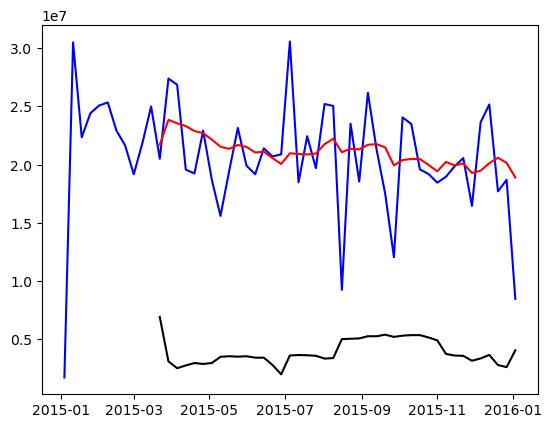

In [544]:
#Using the rolling statistics to analyse the stationarity of the dataset. 
roll_mean = weekly_demand_2015.rolling(window= 12).mean()
roll_std = weekly_demand_2015.rolling(window= 12).std()

plt.plot(datasets[0], color = 'Blue', label ='Oringinal')
plt.plot(roll_mean, color = 'Red', label = 'Rolling Mean')
plt.plot(roll_std, color = 'Black', label = 'Rolling Standard Deviation')
plt.show()

In [545]:
# Dickey-Fuller Test
def interpret_dftest(pandas_Series,Component):
    dftest = sm.tsa.adfuller(pandas_Series, autolag = 'AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=[f'{Component} Test Statistic',f'{Component} p-value',f'{Component} Lag used',f'{Component} Number of observation used'])
    for key , value in dftest[4].items():
        dfoutput['Critical_vlaue(%s)' %key] = value 
    return dfoutput

interpret_dftest(weekly_demand_2015,'Weeklydata')

Weeklydata Test Statistic               -8.980592e+00
Weeklydata p-value                       7.328369e-15
Weeklydata Lag used                      0.000000e+00
Weeklydata Number of observation used    5.200000e+01
Critical_vlaue(1%)                      -3.562879e+00
Critical_vlaue(5%)                      -2.918973e+00
Critical_vlaue(10%)                     -2.597393e+00
dtype: float64

##### The ADF test shows that we do not need to apply differencing with a p-value of 7.328369e-15 
##### significantly lower than the 0.05 significance level, I will be moving on to the PACF and ACF tests to 
##### see if there is any correlation for the past time lags and past error lags, but before we do that 
##### I will decompose the dataset to futher assess the trend and seasonlity components. 


###  Time Series Decompose 

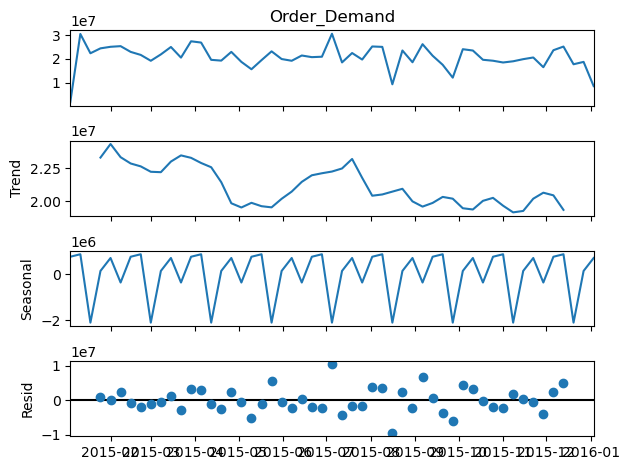

In [546]:
# Decompose time series into components
weekly_demand_2015_components = sm.tsa.seasonal_decompose(weekly_demand_2015, model="additive", period=6)

# Extract components
trend = weekly_demand_2015_components.trend
seasonality = weekly_demand_2015_components.seasonal
resid = weekly_demand_2015_components.resid

# Plot the decomposition
fig = weekly_demand_2015_components.plot() 
plt.show() 

### Testing stationarity on the residuals 

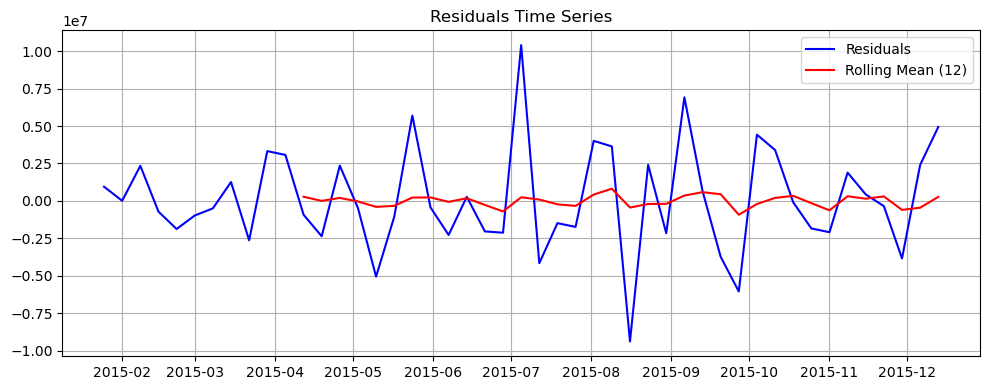


ADF Test Result:

Residuals Test Statistic                -6.751789e+00
Residuals p-value                        2.938461e-09
Residuals Lags Used                      3.000000e+00
Residuals Number of Observations Used    4.300000e+01
Critical Value (1%)                     -3.592504e+00
Critical Value (5%)                     -2.931550e+00
Critical Value (10%)                    -2.604066e+00
dtype: float64


In [547]:
test_residual_stationarity(resid, title="Residuals")

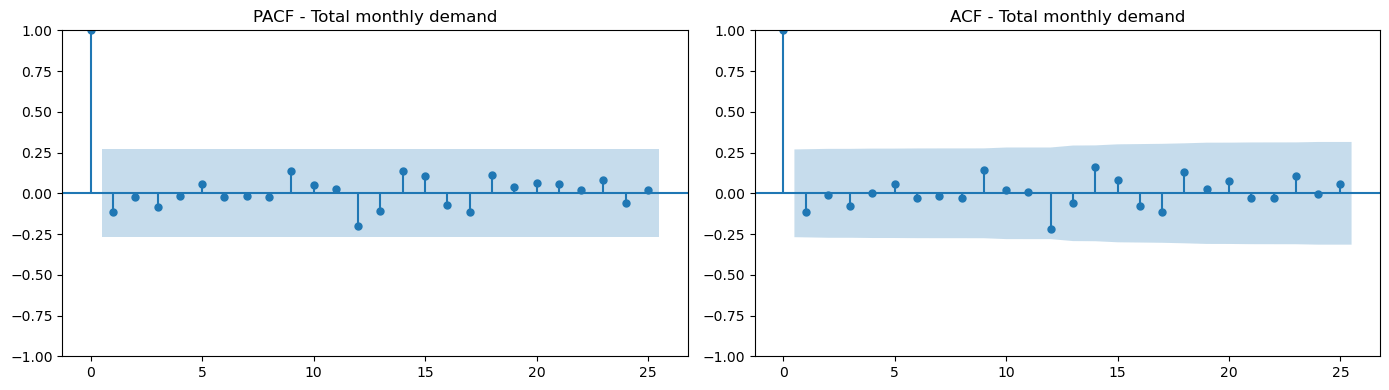

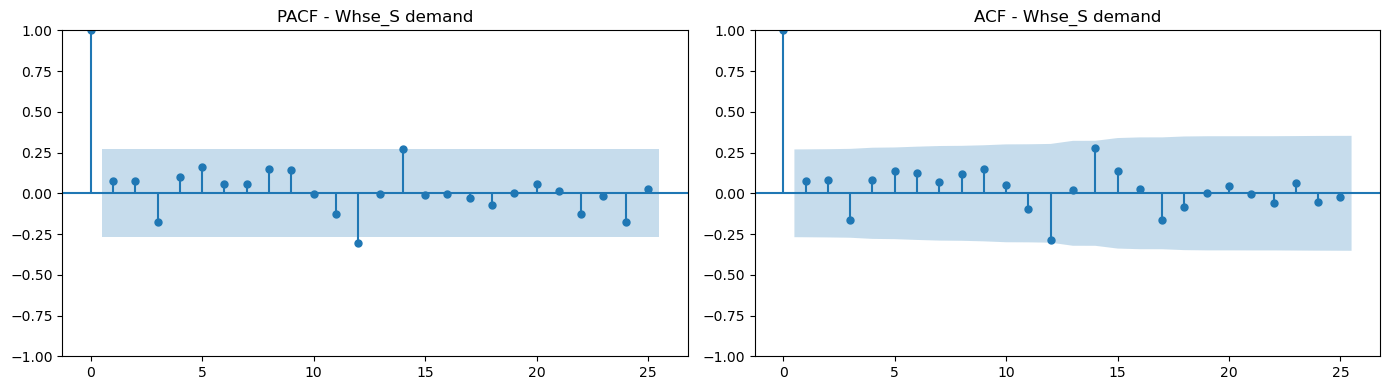

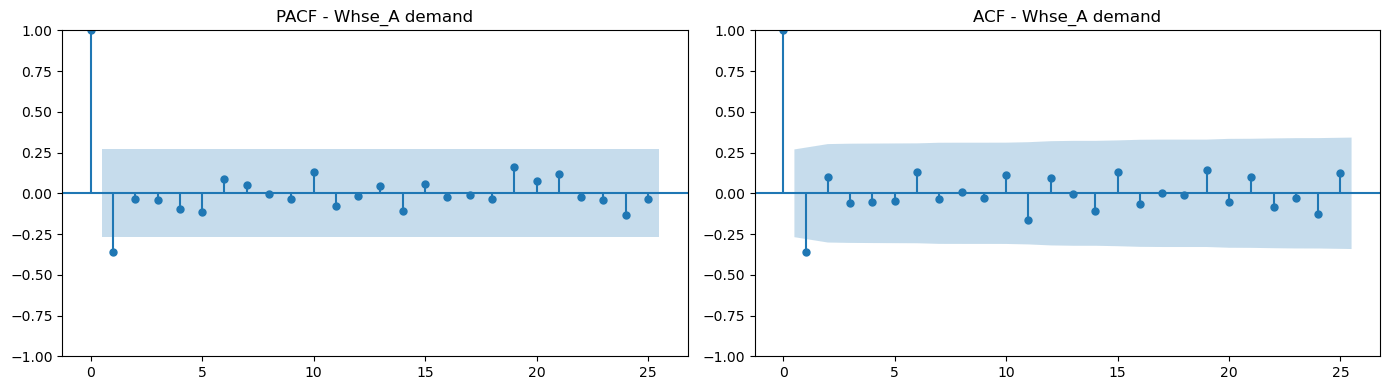

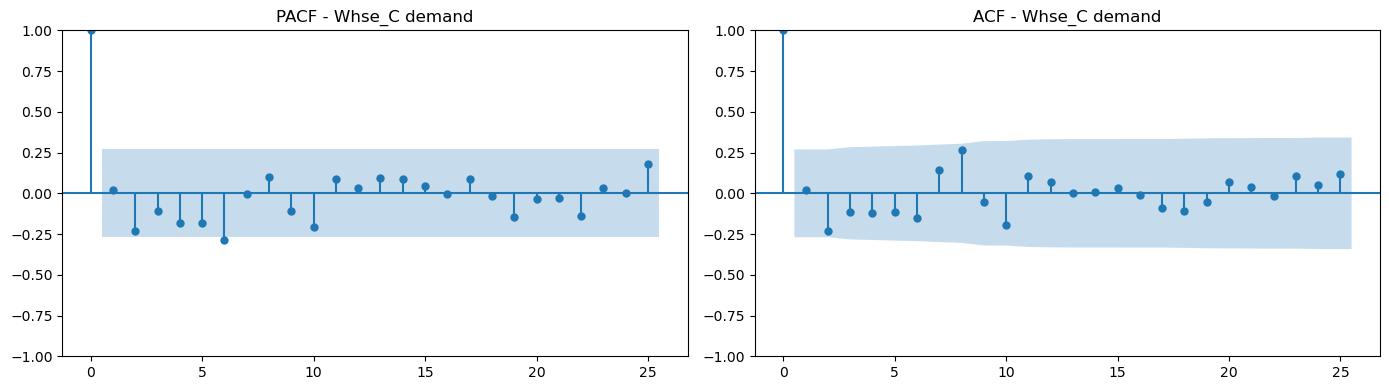

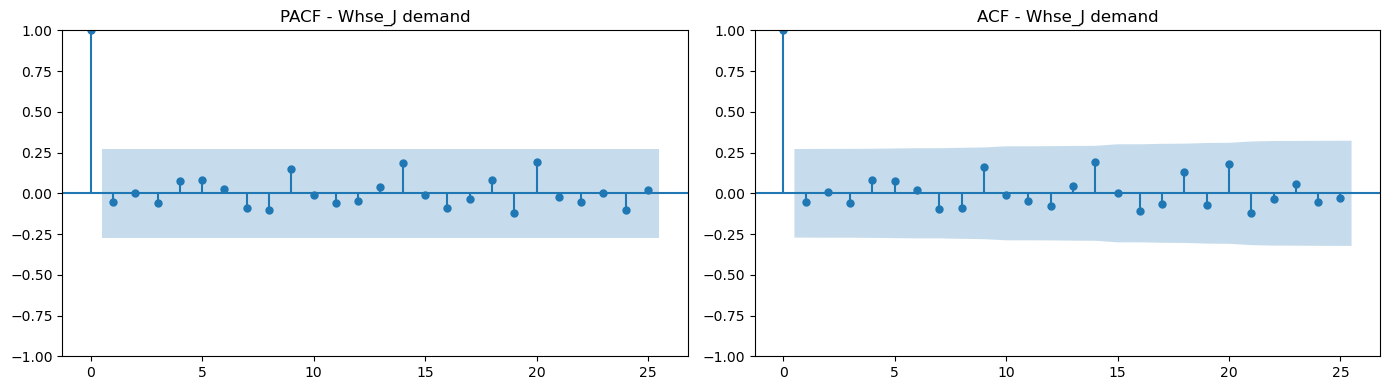

In [548]:
plot_pcaf_acf(datasets, dataset_names)

##### The plots above shows the is no correlation for any past period(AR) or an error for any past period(MA),
##### this suggests that there may be no pattern to be captured by the model just as with the data using the 
##### monthly perspective. i will go ahead and perform a grid search to confirm this. 

### Grid Search 

In [549]:
# Pick values between 0 and 2 
p=d=q = range(0,3)
grid_result = evaluate_arima_models(datasets,dataset_names, p, d, q)


In [550]:
search_values = grid_result[0]
search_values.values()
a_order_2 = [v[:3] for v in search_values.values()]

print(a_order_2)

[(0, 2, 2), (2, 2, 2), (2, 2, 2), (1, 2, 2), (1, 2, 2)]


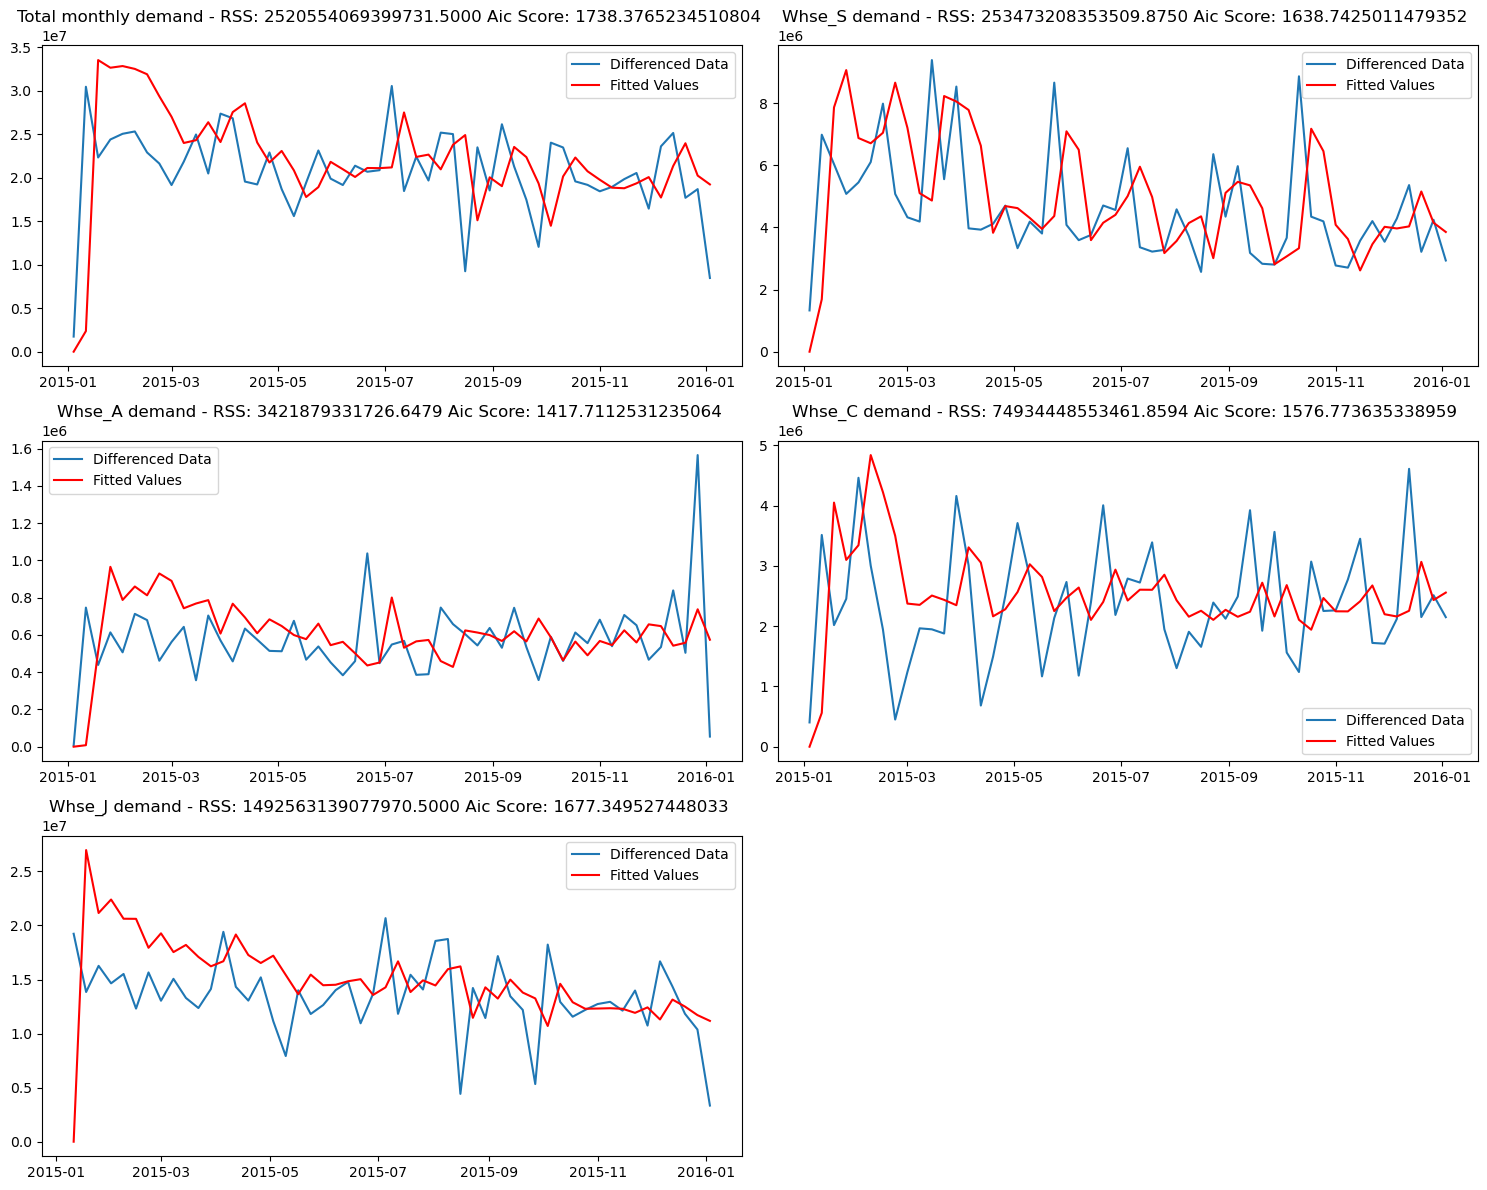

In [551]:
# Visualising on the entire datasets
a_fitted_models_1 = model_building(datasets, a_orders_2, dataset_names)

##### The models above seem to be too tightly fitted, I will do the following to assess what is the best fit for the data 
##### to balance goodness of fit and complexity:
##### - Compare the AIC scores for smaller p,q and d values - a slight decrease in trade AIC might be a good trade-off 
##### - Perform model diagnostics with smaller p,q and d values.
##### - Compare forecast performance using RMSE

### Comapring different p,q and d range of values on the entire demand dataset.

In [552]:
# Use range between 0 and 1 
p=d=q = range(0,2)

# Pass the values with the lowest AIC for this range 
grid_result = evaluate_arima_models(datasets,dataset_names, p, d, q)
search_values = grid_result[0]
search_values.values()
a_order_1 = [v[:3] for v in search_values.values()]

# Selecting the value with the lowest AIC generated for the entire demand dataset using the order:  
a_order_1 = a_order_1[0] # between 0 and 1

a_order_2 = a_order_2[0] # between 0 and 2

#use range just the zero value with no differencing
a_order_0 = (0,0,0) 

# pass the above values to a list
a_orders = [a_order_0,a_order_1,a_order_2]



In [553]:
for order in a_orders:
    print(order)

(0, 0, 0)
(1, 1, 1)
(0, 2, 2)


### Training the model with the different values for p,q and d

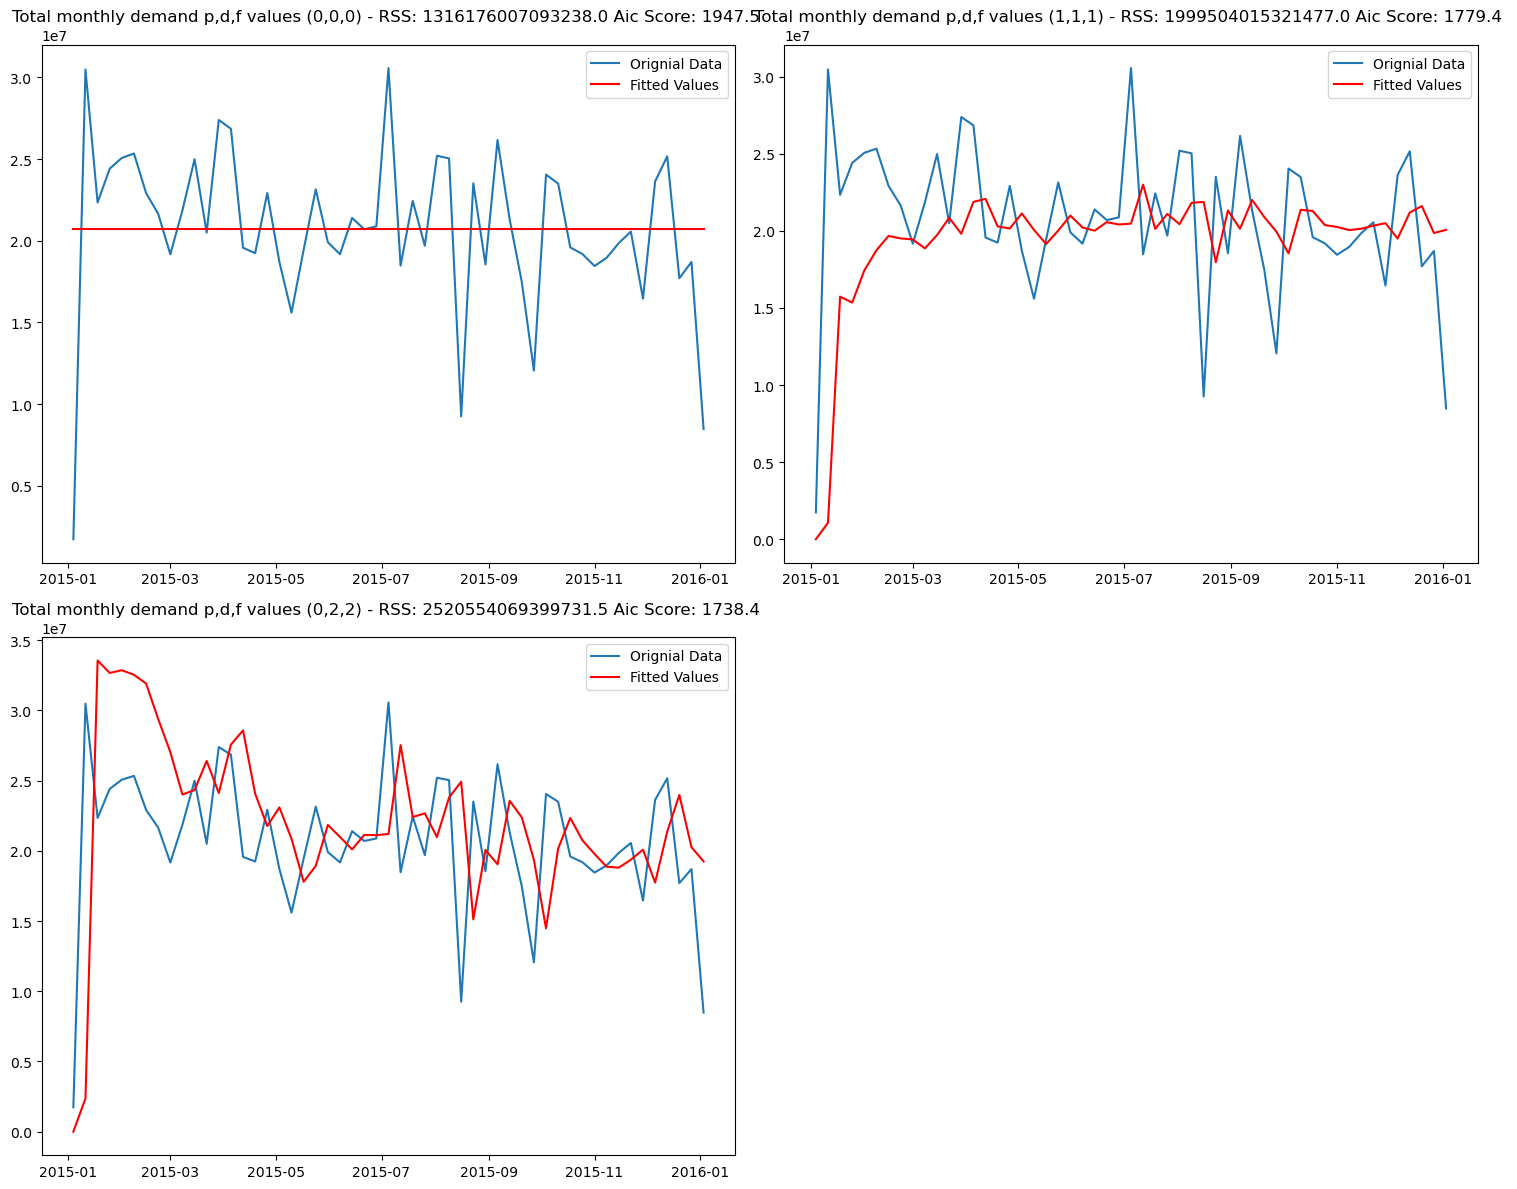

In [554]:
#names to match the p,q and d values 
a_dataset_names = ['Total monthly demand p,d,f values (0,0,0)','Total monthly demand p,d,f values (1,1,1)','Total monthly demand p,d,f values (0,2,2)']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
axes = axes.flatten()

a_fitted_models = []
#iterating over the different orders put in the a_orders list 
for i, (order,names) in enumerate(zip(a_orders,a_dataset_names)):
    #fitting the entire demand dataset in index 0
    model = ARIMA(datasets[0], order=(order[0],order[1], order[2]))
    fitted_model = model.fit()
    a_fitted_models.append(fitted_model)
    axes[i].plot(datasets[0], label='Orignial Data')
    axes[i].plot(fitted_model.fittedvalues, color='red', label='Fitted Values')

    # Align indices to avoid datetime subtraction issues
    residuals = fitted_model.resid
    rss = (residuals ** 2).sum()
    
    
    axes[i].set_title(f"{names} - RSS: {rss:.1f} Aic Score: {round(fitted_model.aic,1)} ")
    axes[i].legend()

    # Hide unused subplots
    for j in range(len(a_orders), len(axes)):
        axes[j].set_visible(False)
 

      
plt.tight_layout()
plt.show()

In [555]:
a_dataset_names = ['Total monthly demand p,d,f values (0,0,0)','Total monthly demand p,d,f values (0,1,1)','Total monthly demand p,d,f values (1,2,2)']

### Models Diagnostics 

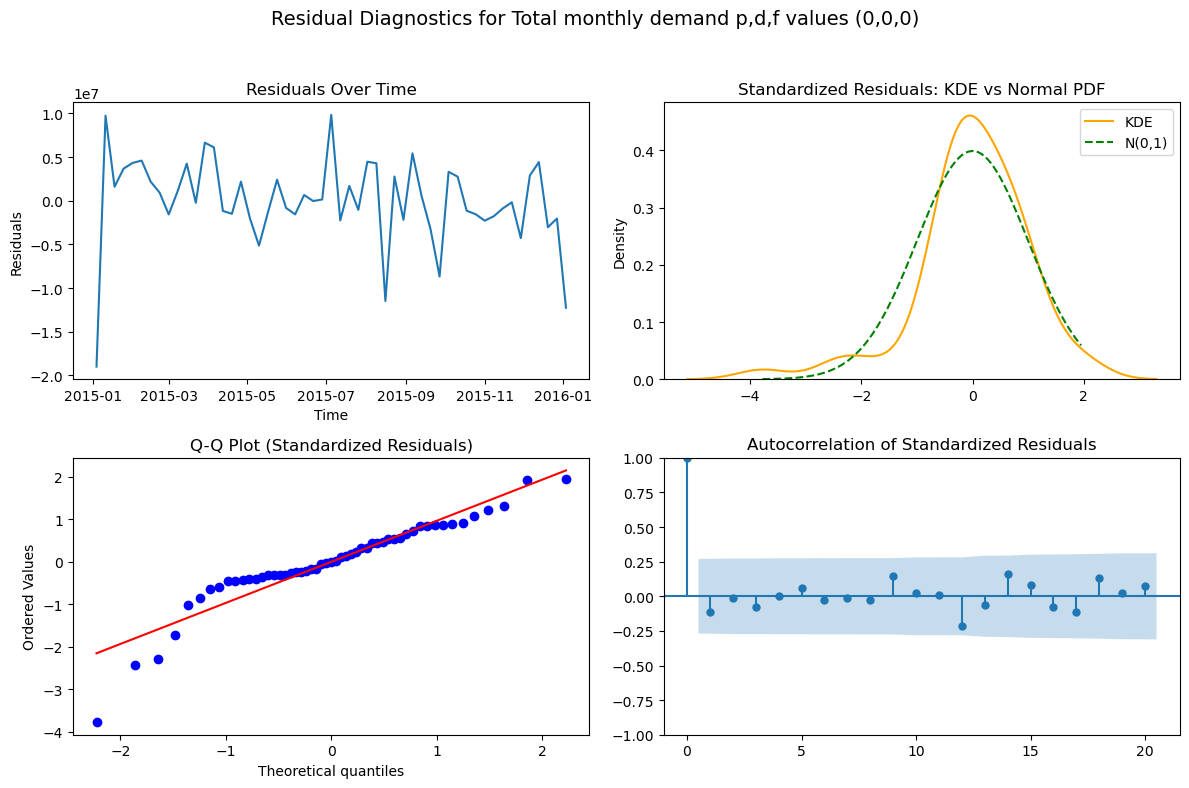

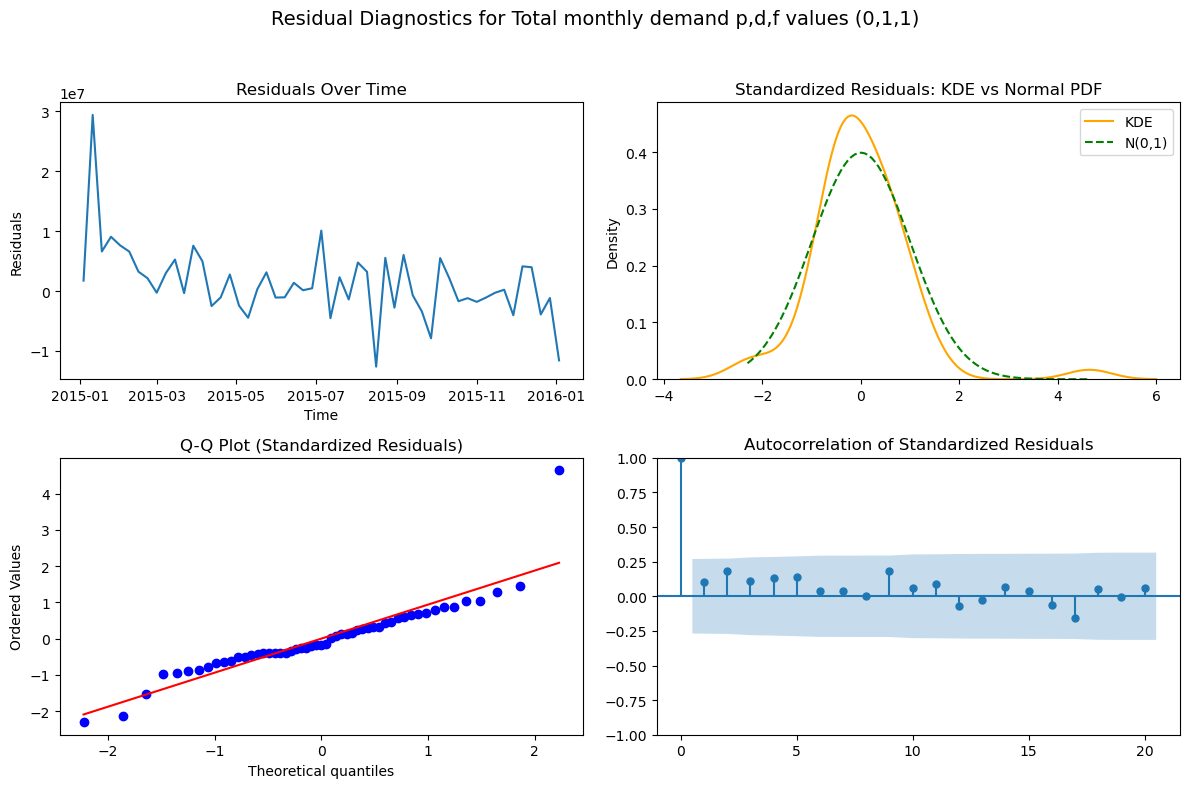

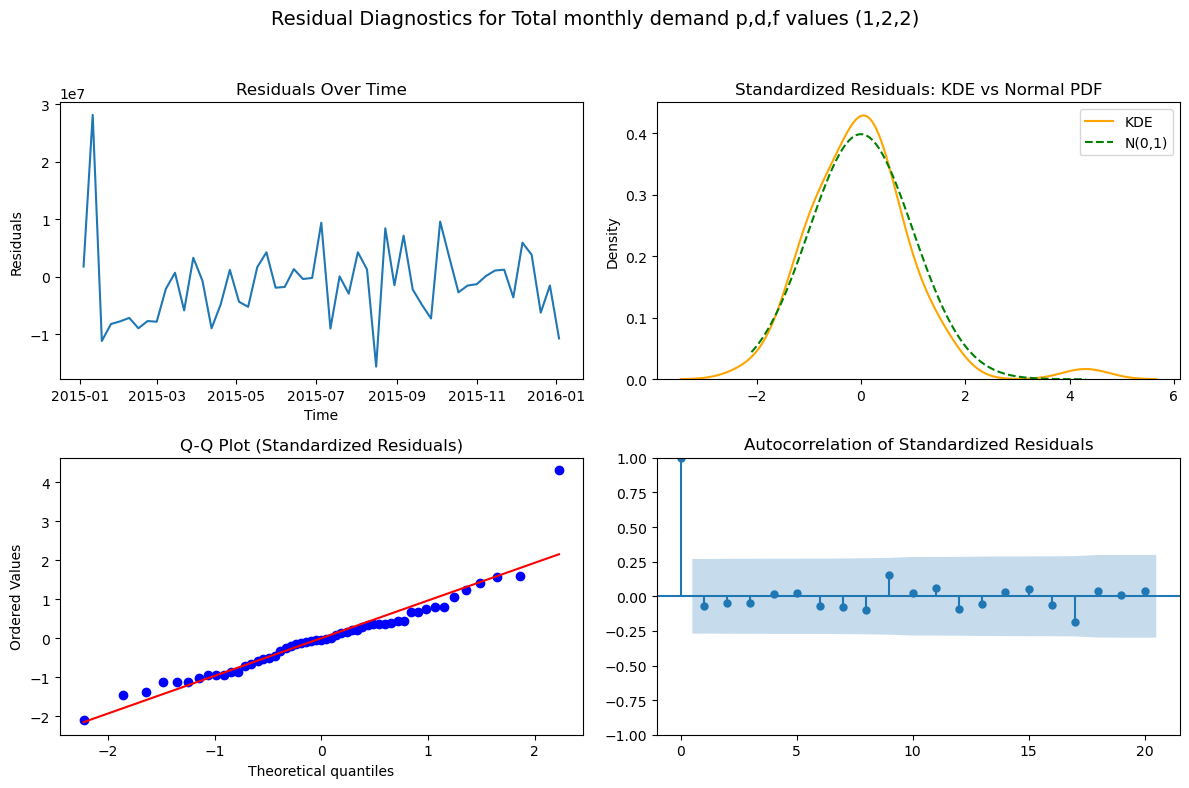

In [556]:
plot_residual_diagnostics(a_fitted_models,a_dataset_names)

### Forecast

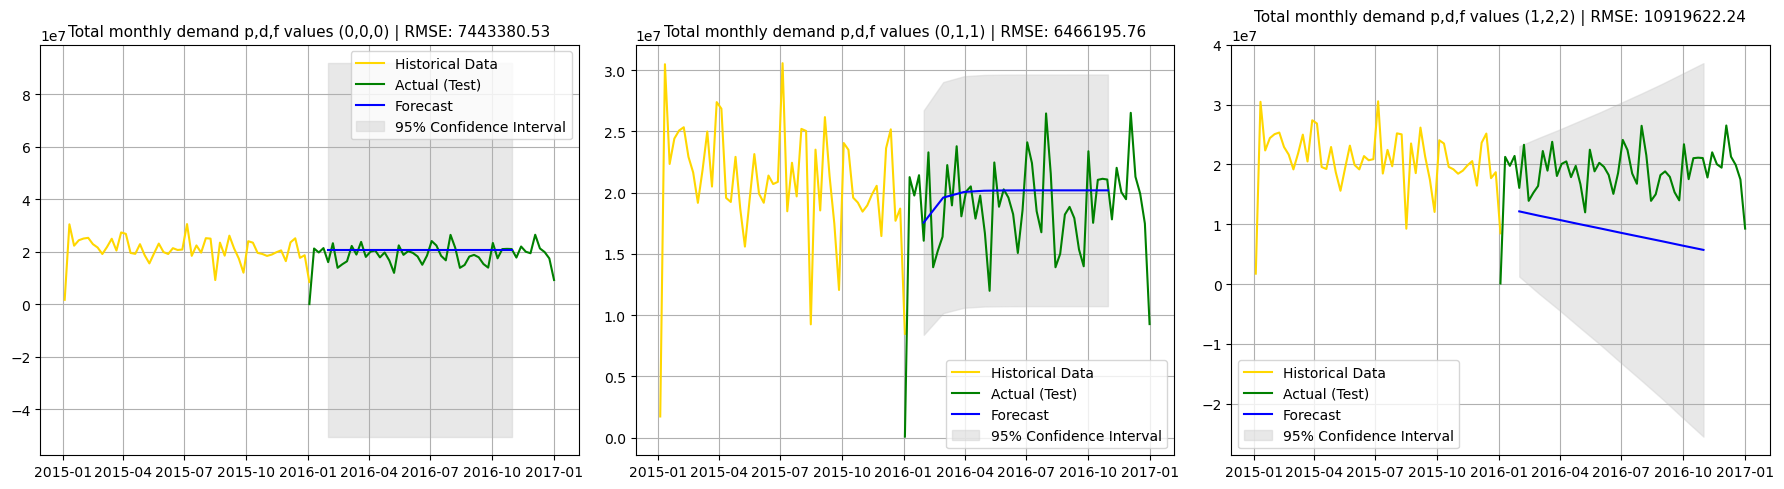

In [557]:
# merging 2016 datasets
# store demand data 
datasets_16 = [demand_by_store_2016[key]['Weekly_Demand'] for key in demand_by_store_2016]

#adding weekly damand data 
testsets = [weekly_demand_2016] + datasets 

# I will forecast only the total demand data to evaluate the RMSE for the different p,q, and d values. 


def forecast_and_plot_single(datasets, dataset_names, a_fitted_models, testsets, n_steps=10):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    
    from sklearn.metrics import mean_squared_error

    dataset = datasets[0]
    testset = testsets[0]

    for i, (model,dataset_name) in enumerate(zip(a_fitted_models, dataset_names)):
        # Step 1: Forecast
        last_date = dataset.index[-1]
        forecast_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=n_steps, freq='M')
        forecast_res = model.get_forecast(steps=n_steps)
        forecast_mean = forecast_res.predicted_mean
        conf_int = forecast_res.conf_int(alpha=0.05)

        # Step 2: Assign forecast index
        forecast_mean.index = forecast_index
        conf_int.index = forecast_index

        # Step 3: Calculate RMSE between forecast and actual test set
        aligned_forecast = forecast_mean[:len(testset)]
        aligned_testset = testset[:len(aligned_forecast)]
        rmse = np.sqrt(mean_squared_error(aligned_testset, aligned_forecast))

        # Step 4: Plotting
        axes[i].plot(dataset, label='Historical Data', color='gold')
        axes[i].plot(testset, label='Actual (Test)', color='green')
        axes[i].plot(forecast_mean, label='Forecast', color='blue')
        axes[i].fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                             color='lightgrey', alpha=0.5, label='95% Confidence Interval')
        axes[i].set_title(f'{dataset_name} | RMSE: {rmse:.2f}', fontsize=11)
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()


forecast_and_plot_single(datasets, a_dataset_names, a_fitted_models, testsets, n_steps=10)

#### Conclusion :
##### The Augmented Dickey-Fuller (ADF) test indicated that the dataset is stationary, suggesting no differencing was needed. also, the ACF and PACF plots showed no significant autocorrelation or partial autocorrelation, implying weak temporal structure in the data.

##### Despite this, a grid search using the Akaike Information Criterion (AIC) revealed that introducing differencing along with AR (p) and MA (q) terms led to lower AIC values. This result appeared to contradict the initial stationarity test, prompting further model validation.

##### After evaluating model diagnostics—including residual plots, stationarity of residuals, and out-of-sample RMSE—it became clear that the ARIMA(1,1,1) model provided the best trade-off between goodness-of-fit and complexity. It significantly outperformed ARIMA(0,0,0) and ARIMA(0,2,2) in terms of RMSE, and had a lower AIC than ARIMA(2,2,2), though the difference was marginal. we can also see that the model(0,1,1) shows are relatively better confidence interval 

##### Residual diagnostics confirmed that ARIMA(1,1,1) effectively captured the structure in the data, as the residuals showed no patterns and no autocorrelation in ACF and PACF plots—indicating a well-fitted model.

### Saving Model & 2016 Total deamd dataset for simulation 

In [561]:
import pickle

model = a_fitted_models[1]
# Save the model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
    

weekly_demand_2016.to_csv('Total demand for 2016.csv',index = False)

In [563]:
weekly_demand_2015

Date
2015-01-04     1738638
2015-01-11    30478354
2015-01-18    22341273
2015-01-25    24412627
2015-02-01    25066737
2015-02-08    25336926
2015-02-15    22920891
2015-02-22    21646621
2015-03-01    19170112
2015-03-08    21861516
2015-03-15    24987268
2015-03-22    20499059
2015-03-29    27387895
2015-04-05    26850041
2015-04-12    19569527
2015-04-19    19239839
2015-04-26    22921277
2015-05-03    18703663
2015-05-10    15599060
2015-05-17    19441656
2015-05-24    23147013
2015-05-31    19907783
2015-06-07    19175102
2015-06-14    21396161
2015-06-21    20702508
2015-06-28    20880209
2015-07-05    30565225
2015-07-12    18480812
2015-07-19    22438818
2015-07-26    19692508
2015-08-02    25201909
2015-08-09    25033496
2015-08-16     9254652
2015-08-23    23509864
2015-08-30    18549278
2015-09-06    26164246
2015-09-13    21305202
2015-09-20    17478205
2015-09-27    12058450
2015-10-04    24047898
2015-10-11    23494760
2015-10-18    19592107
2015-10-25    19190399
2015-1

In [564]:
model.fittedvalues

Date
2015-01-04    0.000000e+00
2015-01-11    1.064500e+06
2015-01-18    1.573553e+07
2015-01-25    1.535118e+07
2015-02-01    1.744043e+07
2015-02-08    1.874647e+07
2015-02-15    1.967670e+07
2015-02-22    1.951240e+07
2015-03-01    1.944910e+07
2015-03-08    1.886669e+07
2015-03-15    1.972962e+07
2015-03-22    2.084938e+07
2015-03-29    1.981588e+07
2015-04-05    2.188196e+07
2015-04-12    2.208009e+07
2015-04-19    2.029402e+07
2015-04-26    2.016003e+07
2015-05-03    2.113522e+07
2015-05-10    2.006408e+07
2015-05-17    1.915006e+07
2015-05-24    2.002632e+07
2015-05-31    2.099647e+07
2015-06-07    2.022302e+07
2015-06-14    2.001588e+07
2015-06-21    2.056852e+07
2015-06-28    2.041782e+07
2015-07-05    2.047448e+07
2015-07-12    2.300206e+07
2015-07-19    2.013599e+07
2015-07-26    2.109996e+07
2015-08-02    2.043878e+07
2015-08-09    2.182197e+07
2015-08-16    2.187980e+07
2015-08-23    1.797199e+07
2015-08-30    2.132825e+07
2015-09-06    2.013851e+07
2015-09-13    2.200859e